In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import tensorflow
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Concatenate
import tensorflow as tf
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


Importing plotly failed. Interactive plots will not work.


In [97]:
import warnings
warnings.filterwarnings('ignore')

### EDA

In [3]:
#precio diario de bitcoin (BTC/USD)
# precio en close desde el 23 de agosto de 2018
test=pd.read_excel("./data/bitcoin.xlsx")

In [4]:
test

timeOpen      timeClose       timeHigh        timeLow  \
0     1746878400000  1746964799999  1746962760000  1746881820000   
1     1746792000000  1746878399999  1746820200000  1746806280000   
2     1746705600000  1746791999999  1746782520000  1746708180000   
3     1746619200000  1746705599999  1746623340000  1746689760000   
4     1746532800000  1746619199999  1746618720000  1746582900000   
...             ...            ...            ...            ...   
2426  1535284800000  1535371199999  1535287440000  1535307241000   
2427  1535198400000  1535284799999  1535207940000  1535226540000   
2428  1535112000000  1535198399999  1535198340000  1535117640000   
2429  1535025600000  1535111999999  1535105640000  1535025840000   
2430  1534939200000  1535025599999  1534946642000  1535019540000   

          priceOpen      priceHigh       priceLow     priceClose        volume  
0     102973.714228  104961.764391  102830.481623  104696.327291  4.227671e+10  
1     103239.125164  104297.490908  102343.090330  102970.849744  5.819859e+10  
2      97034.246889  103969.536490   96913.872397  103241.460830  6.989540e+10  
3      96800.194497   97625.805345   95829.332067   97032.318967  7.698382e+10  
4      94748.386288   96889.176234   93399.858908   96802.477564  2.655128e+10  
...             ...            ...            ...            ...           ...  
2426    6754.640000    6774.750000    6620.750000    6707.260000  3.295500e+09  
2427    6719.950000    6789.630000    6700.960000    6763.190000  3.312600e+09  
2428    6551.520000    6719.960000    6498.640000    6719.960000  4.097820e+09  
2429    6371.340000    6546.540000    6371.340000    6534.880000  3.426180e+09  
2430    6486.250000    6816.790000    6310.110000    6376.710000  4.668110e+09  

[2431 rows x 9 columns]

In [119]:
#¿Por qué close?
#Es el más estable y menos afectado por la volatilidad intradía.

#Es el valor que se usa normalmente para calcular rendimientos, medias móviles, RSI, MACD, etc.

#Refleja el sentimiento final del mercado para ese día.

#Es el estándar en finanzas para análisis técnico e histórico.

BTC_USD=test[["timeClose","priceClose"]]

In [94]:
BTC_USD.dtypes
#el tiempo está medido por milisegundos desde la época Unix (Unix epoch time)
# , es decir, el número de milisegundos desde el 1 de enero de 1970 a las 00:00:00 UTC.

timeClose       int64
priceClose    float64
dtype: object

In [95]:


#convertir el tiempo a objeto daytime

BTC_USD['fecha'] = pd.to_datetime(BTC_USD['timeClose'], unit='ms')


In [96]:
BTC_USD

timeClose     priceClose                   fecha
0     1746964799999  104696.327291 2025-05-11 11:59:59.999
1     1746878399999  102970.849744 2025-05-10 11:59:59.999
2     1746791999999  103241.460830 2025-05-09 11:59:59.999
3     1746705599999   97032.318967 2025-05-08 11:59:59.999
4     1746619199999   96802.477564 2025-05-07 11:59:59.999
...             ...            ...                     ...
2426  1535371199999    6707.260000 2018-08-27 11:59:59.999
2427  1535284799999    6763.190000 2018-08-26 11:59:59.999
2428  1535198399999    6719.960000 2018-08-25 11:59:59.999
2429  1535111999999    6534.880000 2018-08-24 11:59:59.999
2430  1535025599999    6376.710000 2018-08-23 11:59:59.999

[2431 rows x 3 columns]

In [97]:
#ordenamos las fechas en ascendente
BTC_USD = BTC_USD.sort_values(by='fecha')

In [98]:
BTC_USD


timeClose     priceClose                   fecha
2430  1535025599999    6376.710000 2018-08-23 11:59:59.999
2429  1535111999999    6534.880000 2018-08-24 11:59:59.999
2428  1535198399999    6719.960000 2018-08-25 11:59:59.999
2427  1535284799999    6763.190000 2018-08-26 11:59:59.999
2426  1535371199999    6707.260000 2018-08-27 11:59:59.999
...             ...            ...                     ...
4     1746619199999   96802.477564 2025-05-07 11:59:59.999
3     1746705599999   97032.318967 2025-05-08 11:59:59.999
2     1746791999999  103241.460830 2025-05-09 11:59:59.999
1     1746878399999  102970.849744 2025-05-10 11:59:59.999
0     1746964799999  104696.327291 2025-05-11 11:59:59.999

[2431 rows x 3 columns]

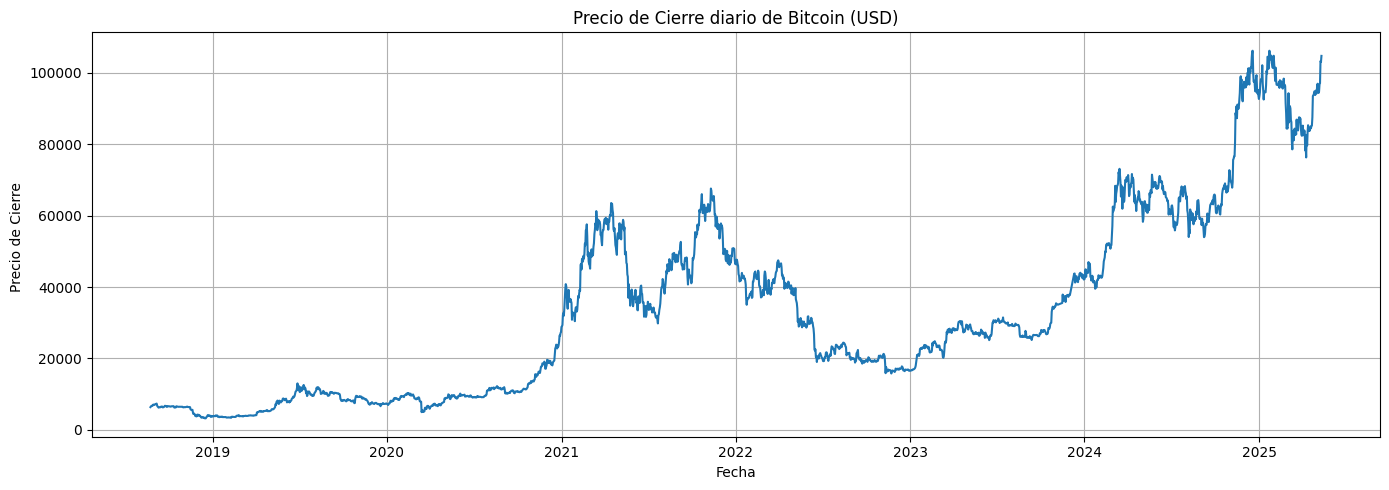

In [99]:


plt.figure(figsize=(14, 5))
plt.plot(BTC_USD['fecha'], BTC_USD['priceClose'], color='tab:blue')
plt.title('Precio de Cierre diario de Bitcoin (USD)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ')
plt.grid(True)
plt.tight_layout()
plt.show()



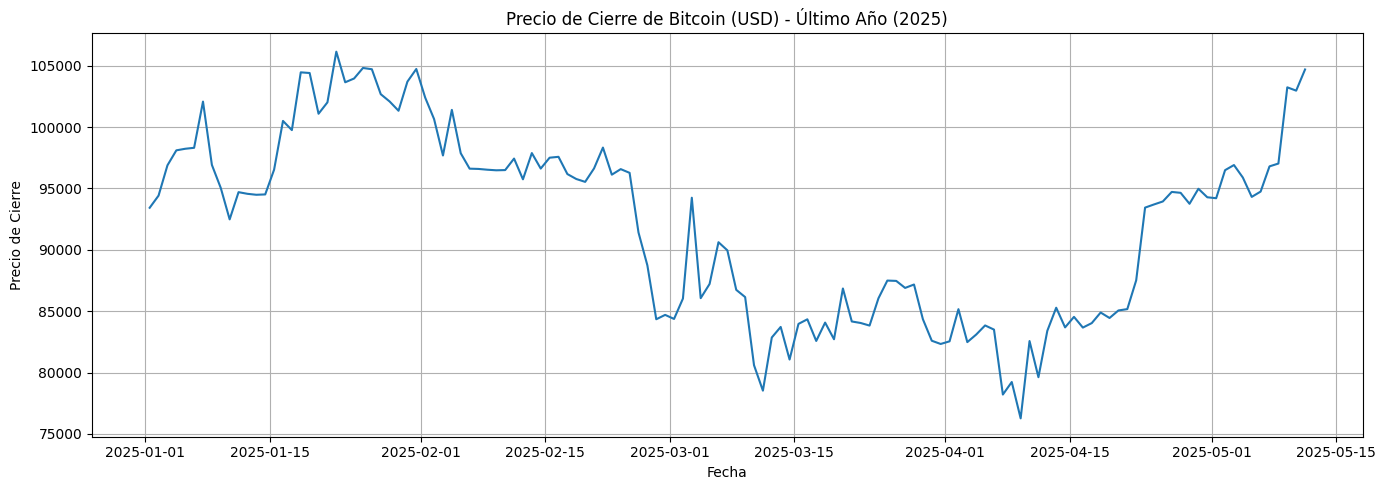

In [100]:
# Filtrar los datos del último año
last_year = BTC_USD[BTC_USD['fecha'].dt.year == BTC_USD['fecha'].dt.year.max()]

# Graficar el precio de cierre para el último año
plt.figure(figsize=(14, 5))
plt.plot(last_year['fecha'], last_year['priceClose'], color='tab:blue')
plt.title(f'Precio de Cierre de Bitcoin (USD) - Último Año ({last_year["fecha"].dt.year.max()})')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(True)
plt.tight_layout()
plt.show()


In [101]:
#eliminar los 2 primeros registros
#renombrar Price a Date
#utilizar solo la columna close de cada commodity



In [102]:
'''

todos los datos con el mismo formato y descargados de la misma fuente

'''


'\n\ntodos los datos con el mismo formato y descargados de la misma fuente\n\n'

In [5]:


BTC=pd.read_csv("./fin_data/BTC_USD.csv")
DJIA=pd.read_csv("./fin_data/DJIA.csv")
XAU=pd.read_csv("./fin_data/Gold.csv")
NASDAQ=pd.read_csv("./fin_data/NASDAQ.csv")
SP500=pd.read_csv("./fin_data/S&P_500.csv")
US10Y=pd.read_csv("./fin_data/US10Y.csv")
WTI=pd.read_csv("./fin_data/WTI_Crude_Oil.csv")



In [6]:
BTC.tail(10)


Price           Close            High             Low  \
2316  2025-05-04   94315.9765625    96318.921875   94173.4296875   
2317  2025-05-05   94748.0546875      95193.1875    93566.265625   
2318  2025-05-06   96802.4765625   96889.1796875    93399.859375   
2319  2025-05-07   97032.3203125   97625.8046875   95829.3359375   
2320  2025-05-08  103241.4609375  103969.5390625       96913.875   
2321  2025-05-09  102970.8515625  104297.4921875    102343.09375   
2322  2025-05-10   104696.328125   104961.765625   102830.484375   
2323  2025-05-11   104106.359375  104937.9921875  103364.7421875   
2324  2025-05-12   102812.953125   105747.453125    100814.40625   
2325  2025-05-13  102796.4296875  102809.5859375   101609.515625   

                Open       Volume  
2316      95877.1875  18198688416  
2317      94319.5625  25816260327  
2318   94748.3828125  26551275827  
2319   96800.1953125  76983822462  
2320        97034.25  69895404397  
2321      103239.125  58198593958  
2322  102973.7109375  42276713994  
2323  104701.0703125  46285517406  
2324  104106.9609375  63250475404  
2325  102809.5859375  61075505152

In [105]:
DJIA.tail(10)

Price           Close            High             Low  \
1590  2025-04-28  40227.58984375   40414.1796875   39869.1015625   
1591  2025-04-29  40527.62109375  40630.48828125   40222.1796875   
1592  2025-04-30    40669.359375  40777.16015625  39745.62890625   
1593  2025-05-01   40752.9609375  41099.51953125  40705.62890625   
1594  2025-05-02   41317.4296875  41386.19140625    40960.421875   
1595  2025-05-05    41218.828125  41445.91015625  41063.44140625   
1596  2025-05-06         40829.0    41164.328125  40759.41015625   
1597  2025-05-07     41113.96875  41266.91015625   40829.2890625   
1598  2025-05-08  41368.44921875     41773.21875  41167.76171875   
1599  2025-05-09  41249.37890625   41512.4296875  41150.73046875   

                Open     Volume  
1590  40171.73828125  475930000  
1591  40233.98046875  434830000  
1592  40290.41015625  599760000  
1593   40918.0390625  597270000  
1594    40960.421875  589870000  
1595  41173.37890625  413440000  
1596  41000.19140625  416110000  
1597    40956.078125  533870000  
1598   41312.5703125  514850000  
1599  41405.48046875  373930000

In [106]:
XAU

Price              Close               High                 Low  \
0         Ticker               GC=F               GC=F                GC=F   
1           Date                NaN                NaN                 NaN   
2     2019-01-02             1281.0             1286.0  1277.5999755859375   
3     2019-01-03  1291.800048828125             1292.0   1286.699951171875   
4     2019-01-04  1282.699951171875  1294.199951171875   1275.300048828125   
...          ...                ...                ...                 ...   
1596  2025-05-05  3311.300048828125  3315.699951171875   3239.699951171875   
1597  2025-05-06   3411.39990234375   3430.89990234375   3356.800048828125   
1598  2025-05-07   3381.39990234375  3418.699951171875   3364.699951171875   
1599  2025-05-08   3296.60009765625             3390.0   3288.699951171875   
1600  2025-05-09   3335.39990234375             3335.5              3299.0   

                   Open Volume  
0                  GC=F   GC=F  
1                   NaN    NaN  
2                1286.0    149  
3     1286.800048828125     10  
4     1294.199951171875     34  
...                 ...    ...  
1596  3242.699951171875    244  
1597             3365.5   2357  
1598  3418.699951171875   1080  
1599             3390.0    200  
1600             3299.0    200  

[1601 rows x 6 columns]

In [107]:
NASDAQ

Price             Close              High              Low  \
0         Ticker             ^IXIC             ^IXIC            ^IXIC   
1           Date               NaN               NaN              NaN   
2     2019-01-02  6665.93994140625   6693.7099609375  6506.8798828125   
3     2019-01-03            6463.5   6600.2099609375  6457.1298828125   
4     2019-01-04  6738.85986328125  6760.68994140625   6554.240234375   
...          ...               ...               ...              ...   
1595  2025-05-05   17844.240234375      17965.640625  17792.080078125   
1596  2025-05-06    17689.66015625   17830.349609375  17592.880859375   
1597  2025-05-07    17738.16015625     17820.2890625  17503.009765625   
1598  2025-05-08      17928.140625           18096.0          17776.0   
1599  2025-05-09   17928.919921875   18068.900390625   17853.83984375   

                  Open      Volume  
0                ^IXIC       ^IXIC  
1                  NaN         NaN  
2        6506.91015625  2261800000  
3     6584.77001953125  2631550000  
4     6567.14013671875  2596150000  
...                ...         ...  
1595   17817.009765625  7075320000  
1596     17623.2109375  6958220000  
1597   17706.830078125  7977870000  
1598   17920.150390625  8500390000  
1599    18022.55078125  8835140000  

[1600 rows x 6 columns]

In [108]:
SP500

Price              Close               High                Low  \
0         Ticker              ^GSPC              ^GSPC              ^GSPC   
1           Date                NaN                NaN                NaN   
2     2019-01-02  2510.030029296875  2519.489990234375  2467.469970703125   
3     2019-01-03  2447.889892578125  2493.139892578125    2443.9599609375   
4     2019-01-04   2531.93994140625  2538.070068359375     2474.330078125   
...          ...                ...                ...                ...   
1595  2025-05-05    5650.3798828125    5683.3798828125   5634.47998046875   
1596  2025-05-06      5606.91015625     5649.580078125    5586.0400390625   
1597  2025-05-07   5631.27978515625   5654.72998046875   5578.64013671875   
1598  2025-05-08   5663.93994140625   5720.10009765625    5635.3798828125   
1599  2025-05-09      5659.91015625   5691.68994140625   5644.14990234375   

                  Open      Volume  
0                ^GSPC       ^GSPC  
1                  NaN         NaN  
2      2476.9599609375  3733160000  
3       2491.919921875  3858830000  
4       2474.330078125  4234140000  
...                ...         ...  
1595  5655.31982421875  4358260000  
1596   5605.8701171875  4717260000  
1597  5614.18017578125  4987440000  
1598  5663.60009765625  5627400000  
1599  5679.64990234375  4645090000  

[1600 rows x 6 columns]

In [109]:
US10Y

Price               Close                High                 Low  \
0         Ticker                ^TNX                ^TNX                ^TNX   
1           Date                 NaN                 NaN                 NaN   
2     2019-01-02  2.6610000133514404   2.678999900817871  2.6489999294281006   
3     2019-01-03   2.553999900817871  2.6559998989105225   2.553999900817871   
4     2019-01-04  2.6589999198913574  2.6730000972747803  2.5969998836517334   
...          ...                 ...                 ...                 ...   
1595  2025-05-05  4.3429999351501465   4.370999813079834   4.297999858856201   
1596  2025-05-06   4.308000087738037    4.36299991607666   4.306000232696533   
1597  2025-05-07   4.275000095367432   4.328000068664551   4.260000228881836   
1598  2025-05-08   4.373000144958496   4.383999824523926  4.2829999923706055   
1599  2025-05-09               4.375  4.3979997634887695  4.3429999351501465   

                    Open Volume  
0                   ^TNX   ^TNX  
1                    NaN    NaN  
2     2.6519999504089355      0  
3     2.6540000438690186      0  
4     2.5989999771118164      0  
...                  ...    ...  
1595   4.301000118255615      0  
1596   4.336999893188477      0  
1597   4.320000171661377      0  
1598   4.300000190734863      0  
1599   4.392000198364258      0  

[1600 rows x 6 columns]

In [ ]:
WTI     

Price               Close                High                 Low  \
0         Ticker                CL=F                CL=F                CL=F   
1           Date                 NaN                 NaN                 NaN   
2     2019-01-02  46.540000915527344  47.779998779296875  44.349998474121094   
3     2019-01-03   47.09000015258789    47.4900016784668  45.349998474121094   
4     2019-01-04  47.959999084472656  49.220001220703125  46.650001525878906   
...          ...                 ...                 ...                 ...   
1596  2025-05-05  57.130001068115234   57.70000076293945   55.29999923706055   
1597  2025-05-06   59.09000015258789   59.84000015258789  57.029998779296875   
1598  2025-05-07   58.06999969482422    60.2599983215332  57.810001373291016   
1599  2025-05-08   59.90999984741211  60.290000915527344    57.7400016784668   
1600  2025-05-09   61.02000045776367   61.45000076293945   59.88999938964844   

                    Open  Volume  
0                   CL=F    CL=F  
1                    NaN     NaN  
2      45.79999923706055  850480  
3       46.2599983215332  788718  
4     46.900001525878906  817277  
...                  ...     ...  
1596    56.7599983215332  308387  
1597               57.25  343893  
1598   58.97999954223633  295238  
1599   57.93000030517578  281000  
1600               60.25  281000  

[1601 rows x 6 columns]

In [111]:
#eliminar los 2 primeros registros de los dataframes


   

In [7]:
dataframes = {
    "BTC": BTC,
    "DJIA": DJIA,
    "XAU": XAU,
    "NASDAQ": NASDAQ,
    "SP500": SP500,
    "US10Y": US10Y,
    "WTI": WTI
}

for name in dataframes:
    dataframes[name] = dataframes[name].iloc[2:].reset_index(drop=True)
    print(f"Se eliminaron los 2 primeros registros de: {name}")


Se eliminaron los 2 primeros registros de: BTC
Se eliminaron los 2 primeros registros de: DJIA
Se eliminaron los 2 primeros registros de: XAU
Se eliminaron los 2 primeros registros de: NASDAQ
Se eliminaron los 2 primeros registros de: SP500
Se eliminaron los 2 primeros registros de: US10Y
Se eliminaron los 2 primeros registros de: WTI


In [8]:
dataframes["XAU"]

Price              Close               High                 Low  \
0     2019-01-02             1281.0             1286.0  1277.5999755859375   
1     2019-01-03  1291.800048828125             1292.0   1286.699951171875   
2     2019-01-04  1282.699951171875  1294.199951171875   1275.300048828125   
3     2019-01-07  1286.800048828125  1286.800048828125  1286.5999755859375   
4     2019-01-08  1283.199951171875  1283.199951171875   1278.199951171875   
...          ...                ...                ...                 ...   
1594  2025-05-05  3311.300048828125  3315.699951171875   3239.699951171875   
1595  2025-05-06   3411.39990234375   3430.89990234375   3356.800048828125   
1596  2025-05-07   3381.39990234375  3418.699951171875   3364.699951171875   
1597  2025-05-08   3296.60009765625             3390.0   3288.699951171875   
1598  2025-05-09   3335.39990234375             3335.5              3299.0   

                   Open Volume  
0                1286.0    149  
1     1286.800048828125     10  
2     1294.199951171875     34  
3     1286.800048828125      2  
4                1280.5     54  
...                 ...    ...  
1594  3242.699951171875    244  
1595             3365.5   2357  
1596  3418.699951171875   1080  
1597             3390.0    200  
1598             3299.0    200  

[1599 rows x 6 columns]

In [ ]:
#para renombrar la columna
for name, df in dataframes.items():
    if "Price" in df.columns:
        df = df.rename(columns={"Price": "Date"})
        dataframes[name] = df
        print(f"{name}: renombrada columna 'Price' a 'Date'")

BTC: renombrada columna 'Price' a 'Date'
DJIA: renombrada columna 'Price' a 'Date'
XAU: renombrada columna 'Price' a 'Date'
NASDAQ: renombrada columna 'Price' a 'Date'
SP500: renombrada columna 'Price' a 'Date'
US10Y: renombrada columna 'Price' a 'Date'
WTI: renombrada columna 'Price' a 'Date'


In [10]:
for name, df in dataframes.items():
    if "Date" in df.columns:
        length = df["Date"].dropna().shape[0]  # Cuenta solo los valores no nulos
        print(f"{name}: {length} registros en la columna 'Date'")
    else:
        print(f"{name}: ⚠️ No contiene la columna 'Date'")

BTC: 2324 registros en la columna 'Date'
DJIA: 1598 registros en la columna 'Date'
XAU: 1599 registros en la columna 'Date'
NASDAQ: 1598 registros en la columna 'Date'
SP500: 1598 registros en la columna 'Date'
US10Y: 1598 registros en la columna 'Date'
WTI: 1599 registros en la columna 'Date'


In [ ]:
#  Asegurar que 'Date' en BTC es datetime
btc_dates = pd.to_datetime(dataframes["BTC"]["Date"])

#  Reindexar los demás DataFrames usando las fechas de BTC (manteniendo 'Date' como columna)
for name, df in dataframes.items():
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").reindex(btc_dates).ffill().reset_index()  # 'Date' vuelve a ser columna
    df.rename(columns={"index": "Date"}, inplace=True)  # renombrar columna si es necesario
    dataframes[name] = df
    print(f"{name}: alineado con fechas de BTC, valores imputados (forward fill)")

BTC: alineado con fechas de BTC, valores imputados (forward fill)
DJIA: alineado con fechas de BTC, valores imputados (forward fill)
XAU: alineado con fechas de BTC, valores imputados (forward fill)
NASDAQ: alineado con fechas de BTC, valores imputados (forward fill)
SP500: alineado con fechas de BTC, valores imputados (forward fill)
US10Y: alineado con fechas de BTC, valores imputados (forward fill)
WTI: alineado con fechas de BTC, valores imputados (forward fill)


In [17]:
dataframes["WTI"]

Date               Close                High                 Low  \
0    2019-01-02  46.540000915527344  47.779998779296875  44.349998474121094   
1    2019-01-03   47.09000015258789    47.4900016784668  45.349998474121094   
2    2019-01-04  47.959999084472656  49.220001220703125  46.650001525878906   
3    2019-01-05  47.959999084472656  49.220001220703125  46.650001525878906   
4    2019-01-06  47.959999084472656  49.220001220703125  46.650001525878906   
...         ...                 ...                 ...                 ...   
2319 2025-05-09   61.02000045776367   61.45000076293945   59.88999938964844   
2320 2025-05-10   61.02000045776367   61.45000076293945   59.88999938964844   
2321 2025-05-11   61.02000045776367   61.45000076293945   59.88999938964844   
2322 2025-05-12   61.02000045776367   61.45000076293945   59.88999938964844   
2323 2025-05-13   61.02000045776367   61.45000076293945   59.88999938964844   

                    Open  Volume  
0      45.79999923706055  850480  
1       46.2599983215332  788718  
2     46.900001525878906  817277  
3     46.900001525878906  817277  
4     46.900001525878906  817277  
...                  ...     ...  
2319               60.25  281000  
2320               60.25  281000  
2321               60.25  281000  
2322               60.25  281000  
2323               60.25  281000  

[2324 rows x 6 columns]

In [14]:
#contador de nulos
for name,df in dataframes.items():
    
    nulls=df.isnull().sum()
    print(f"{name}: {nulls} en el dataframe")


BTC: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe
DJIA: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe
XAU: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe
NASDAQ: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe
SP500: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe
US10Y: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe
WTI: Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64 en el dataframe


In [ ]:
#dataframe final

#  Crear base con fechas (usamos BTC como referencia)
combined_df = dataframes["BTC"][["Date"]].copy()

# Añadir la columna 'Close' de cada activo con su nombre como encabezado
for name, df in dataframes.items():
    combined_df[name] = df["Close"].values  


# Seleccionar todas las columnas menos la primera
columnas_a_convertir = combined_df.columns[1:]

# Convertir las columnas seleccionadas a float
combined_df[columnas_a_convertir] = combined_df[columnas_a_convertir].astype(float)



In [141]:
combined_df.tail(10)

Date            BTC          DJIA          XAU        NASDAQ  \
2314 2025-05-04   94315.976562  41317.429688  3231.899902  17977.730469   
2315 2025-05-05   94748.054688  41218.828125  3311.300049  17844.240234   
2316 2025-05-06   96802.476562  40829.000000  3411.399902  17689.660156   
2317 2025-05-07   97032.320312  41113.968750  3381.399902  17738.160156   
2318 2025-05-08  103241.460938  41368.449219  3296.600098  17928.140625   
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y        WTI  
2314  5686.669922  4.322  58.290001  
2315  5650.379883  4.343  57.130001  
2316  5606.910156  4.308  59.090000  
2317  5631.279785  4.275  58.070000  
2318  5663.939941  4.373  59.910000  
2319  5659.910156  4.375  61.020000  
2320  5659.910156  4.375  61.020000  
2321  5659.910156  4.375  61.020000  
2322  5659.910156  4.375  61.020000  
2323  5659.910156  4.375  61.020000

In [69]:

combined_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2324 non-null   datetime64[ns]
 1   BTC     2324 non-null   float64       
 2   DJIA    2324 non-null   float64       
 3   XAU     2324 non-null   float64       
 4   NASDAQ  2324 non-null   float64       
 5   SP500   2324 non-null   float64       
 6   US10Y   2324 non-null   float64       
 7   WTI     2324 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 145.4 KB


In [76]:
combined_df.describe()

Date            BTC          DJIA  \
count                           2324    2324.000000   2324.000000   
mean   2022-03-08 12:00:00.000000256   34999.467869  33014.848773   
min              2019-01-02 00:00:00    3399.471680  18591.929688   
25%              2020-08-04 18:00:00   10964.885986  28264.377441   
50%              2022-03-08 12:00:00   29044.939453  33557.818359   
75%              2023-10-10 06:00:00   51594.075195  35819.558594   
max              2025-05-13 00:00:00  106146.265625  45014.039062   
std                              NaN   25777.931580   5437.720371   

               XAU        NASDAQ        SP500        US10Y          WTI  
count  2324.000000   2324.000000  2324.000000  2324.000000  2324.000000  
mean   1914.460152  12830.833660  4134.924312     2.699849    68.700413  
min    1269.300049   6463.500000  2237.399902     0.499000   -37.630001  
25%    1717.424957  10485.957520  3329.620117     1.550000    57.107500  
50%    1840.800049  12998.500000  4132.040039     2.691000    70.739998  
75%    1991.425018  15085.469727  4632.222534     4.010000    79.690001  
max    3411.399902  20173.890625  6144.149902     4.988000   123.699997  
std     410.501470   3384.102167   930.580793     1.330599    18.639295

In [61]:
combined_df["BTC"]

0         3943.409424
1         3836.741211
2         3857.717529
3         3845.194580
4         4076.632568
            ...      
2319    102970.851562
2320    104696.328125
2321    104106.359375
2322    102812.953125
2323    102796.429688
Name: BTC, Length: 2324, dtype: float64

<Axes: >

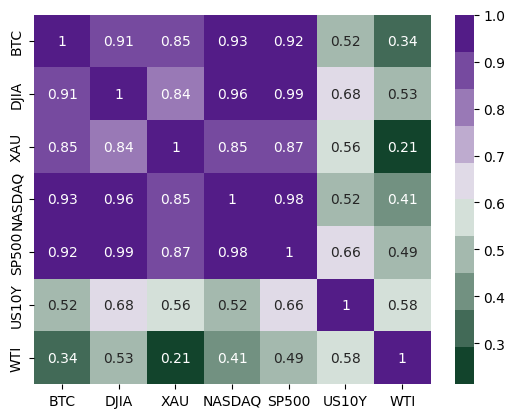

In [78]:
sns.heatmap(data=combined_df.iloc[:,1:].corr(),annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
)

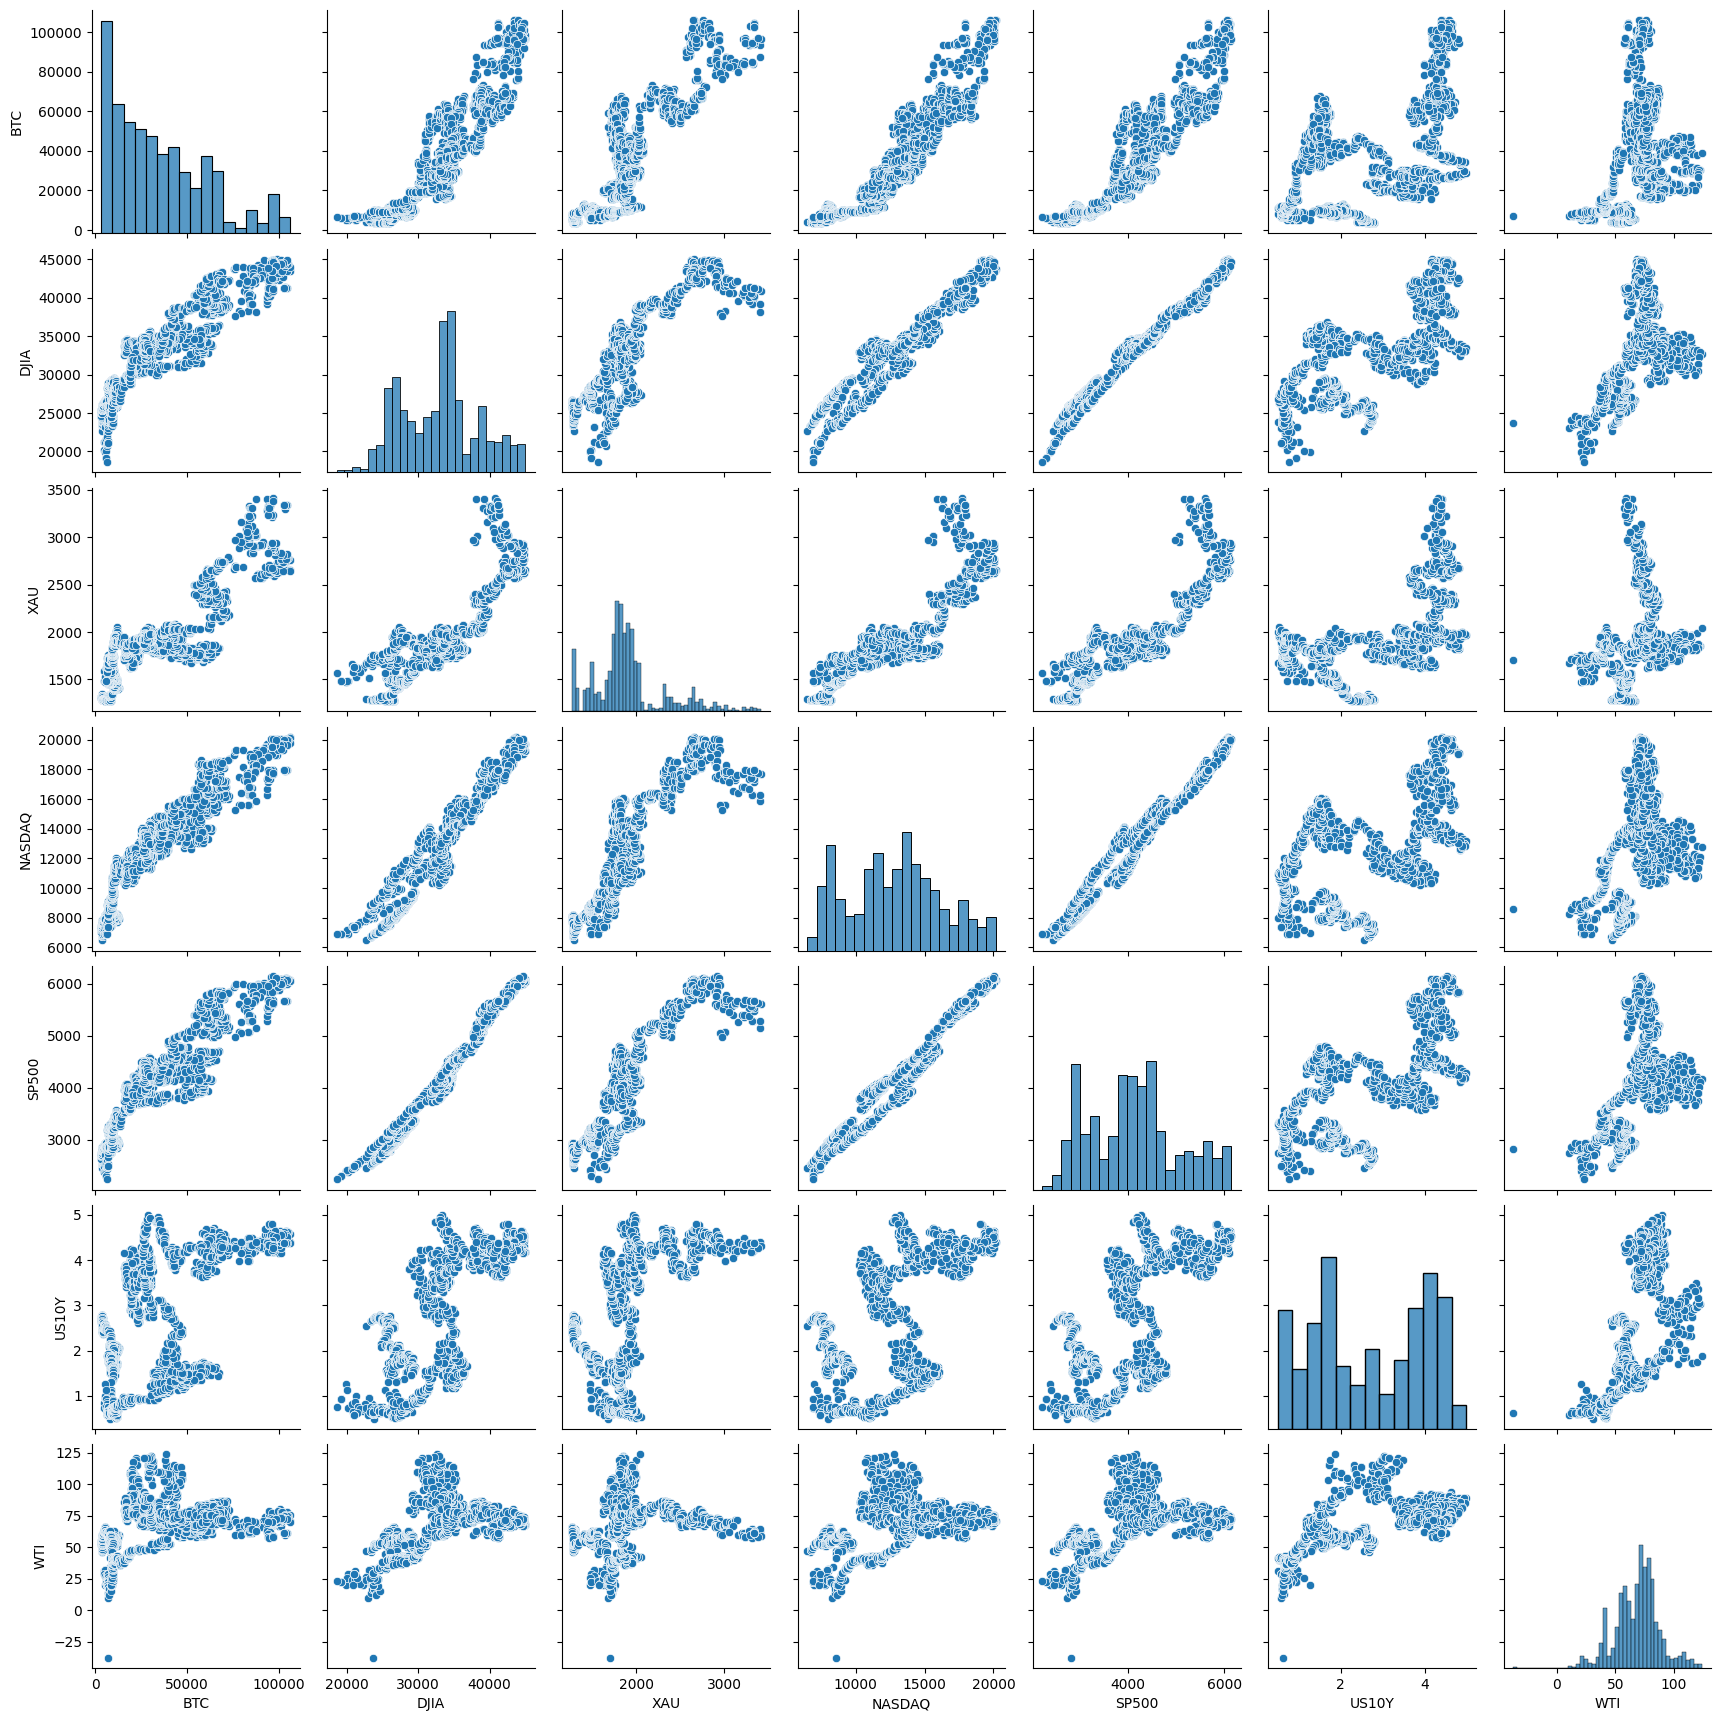

In [73]:
sns.pairplot(data=combined_df)

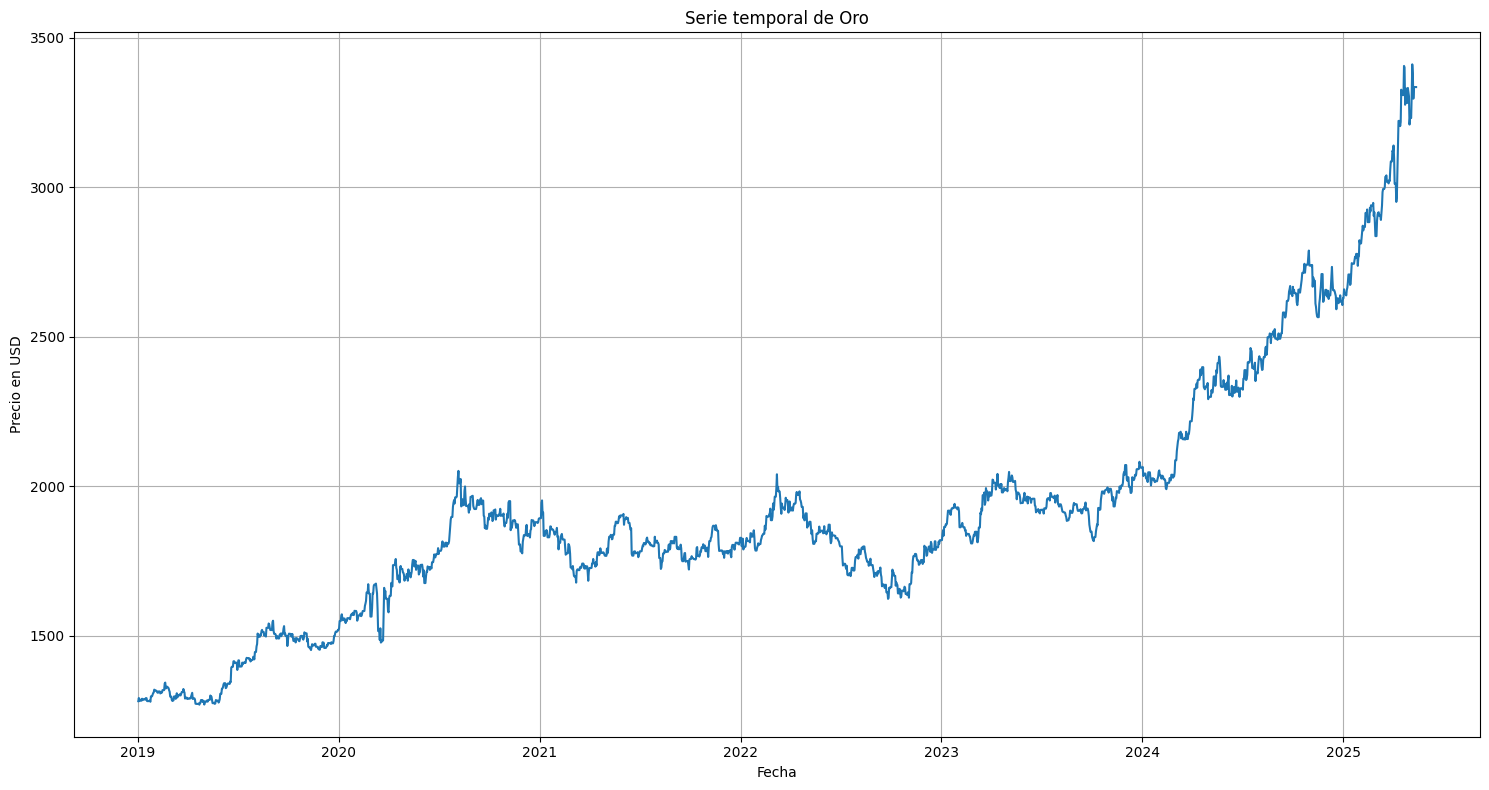

In [86]:
plt.figure(figsize=(15, 8))


   
plt.plot(combined_df["Date"], combined_df["XAU"],label=name)

plt.title("Serie temporal de Oro")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")

plt.grid(True)
plt.tight_layout()
plt.show()

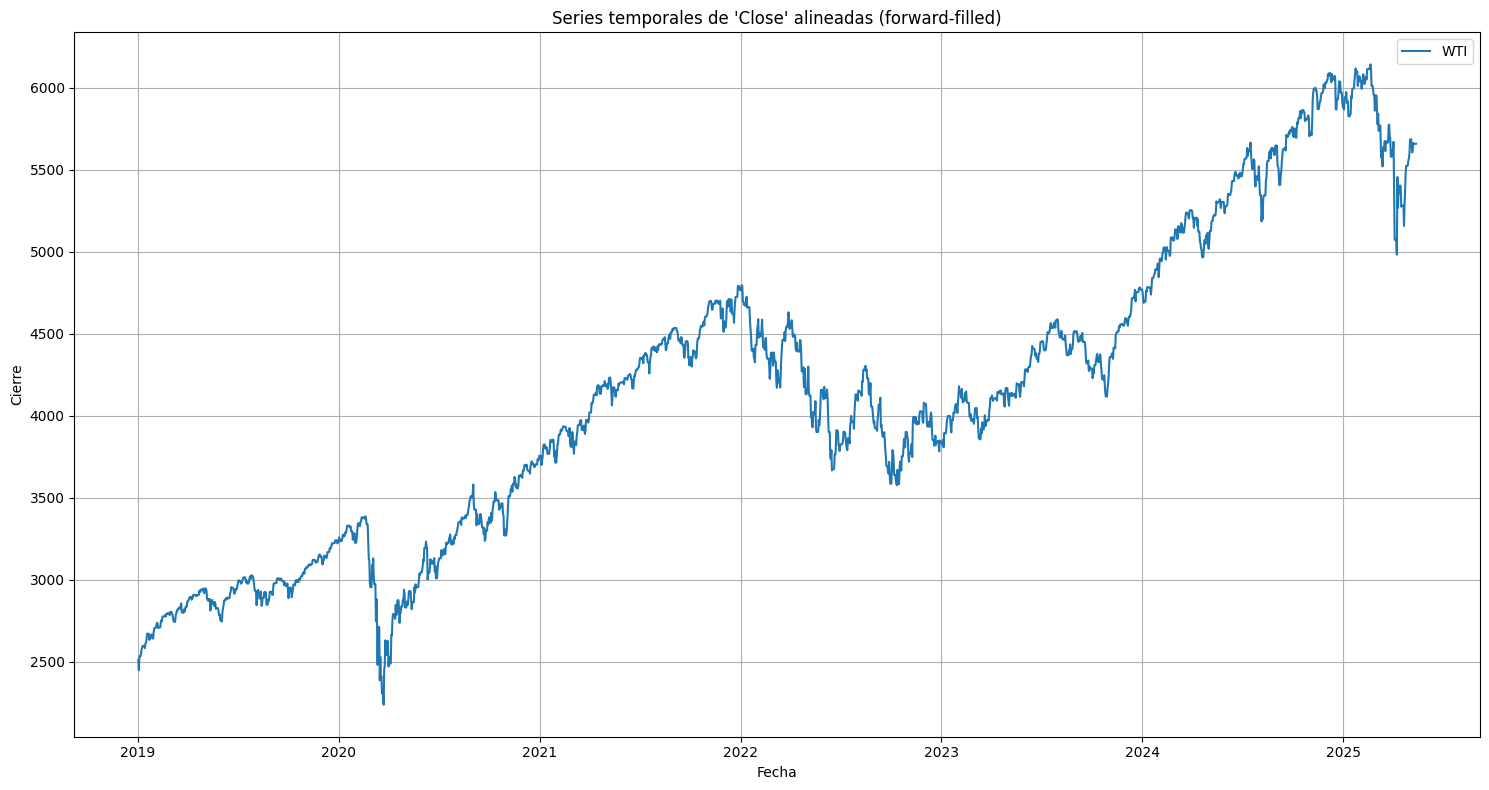

In [80]:
plt.figure(figsize=(15, 8))


   
plt.plot(combined_df["Date"], combined_df["SP500"],label=name)

plt.title("Series temporales de 'Close' alineadas (forward-filled)")
plt.xlabel("Fecha")
plt.ylabel("Cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

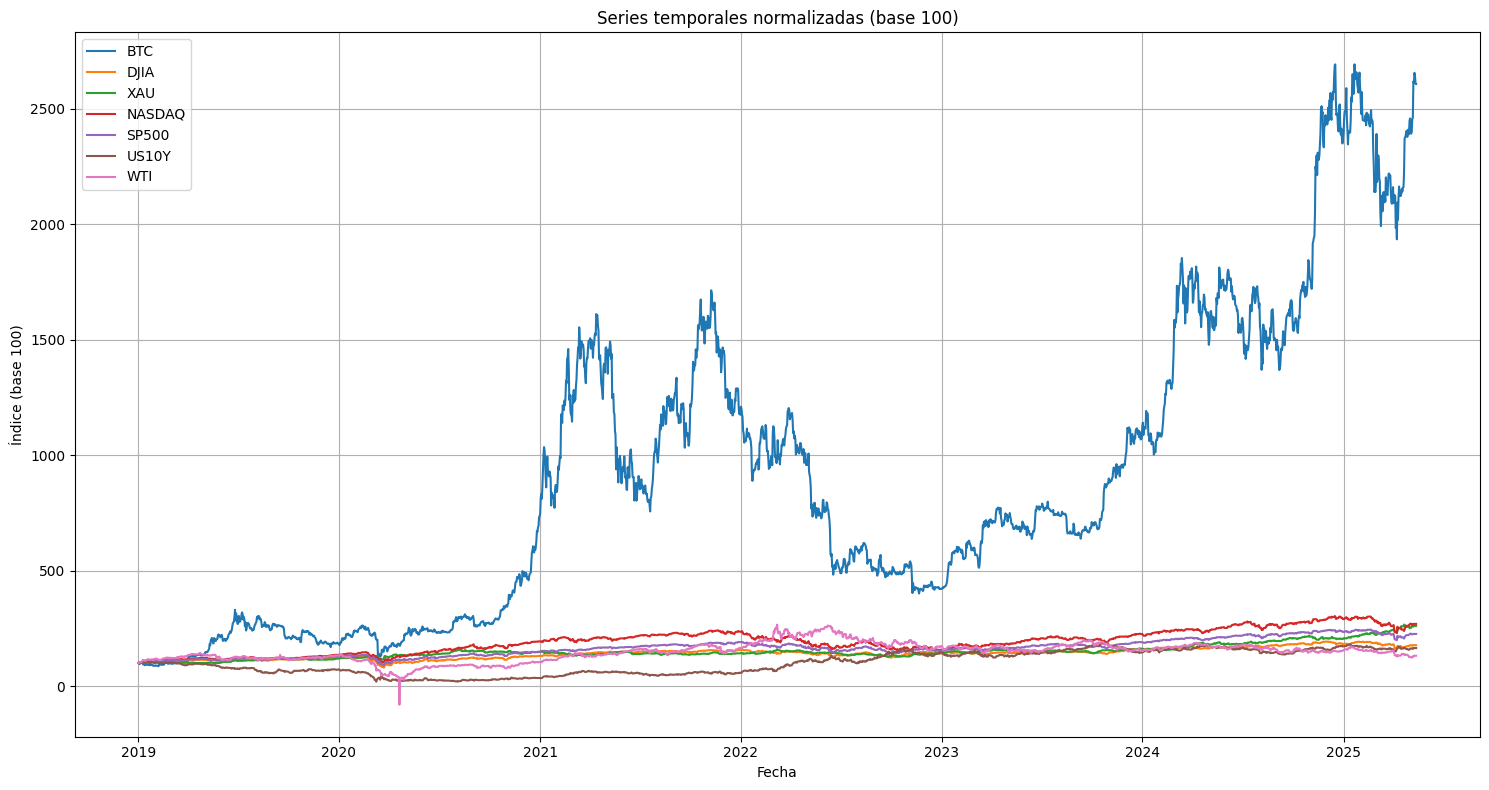

In [77]:


# 1. Crear una copia normalizada (porcentaje de cambio relativo al valor inicial)
plot_df = combined_df.copy()
assets = plot_df.columns.drop("Date")

# Normalizar precios al valor del primer día (inicia en 100)
plot_df[assets] = plot_df[assets] / plot_df[assets].iloc[0] * 100

# 2. Graficar
plt.figure(figsize=(15, 8))
for col in assets:
    plt.plot(plot_df["Date"], plot_df[col], label=col)

plt.title("Series temporales normalizadas (base 100)")
plt.xlabel("Fecha")
plt.ylabel("Índice (base 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


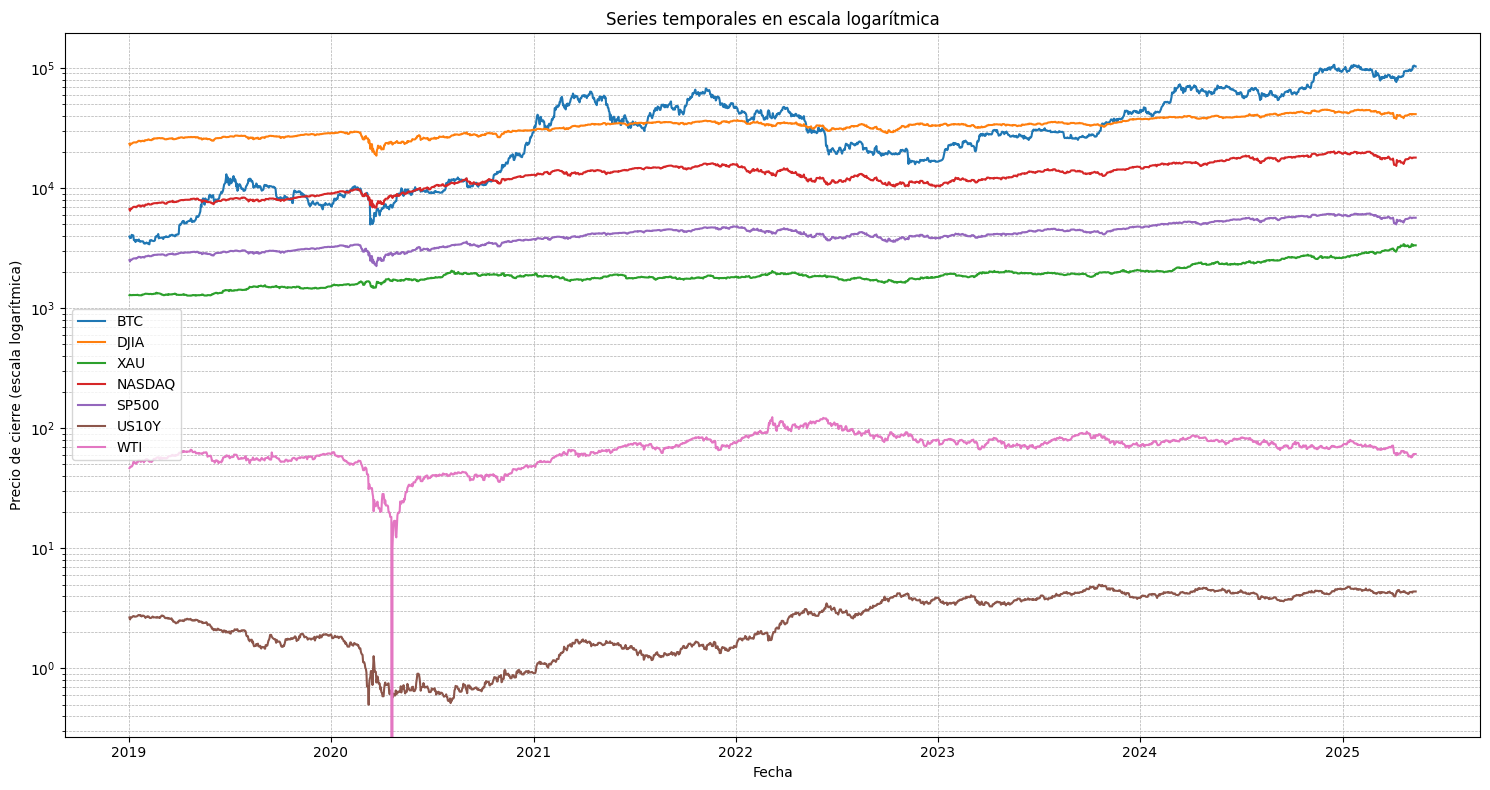

In [79]:


# 1. Crear copia del DataFrame con los datos reales
plot_df = combined_df.copy()
assets = plot_df.columns.drop("Date")

# 2. Graficar en escala logarítmica
plt.figure(figsize=(15, 8))

for col in assets:
    plt.plot(plot_df["Date"], plot_df[col], label=col)

plt.yscale("log")
plt.title("Series temporales en escala logarítmica")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (escala logarítmica)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [204]:
combined_df

Date            BTC          DJIA          XAU        NASDAQ  \
0    2019-01-02    3943.409424  23346.240234  1281.000000   6665.939941   
1    2019-01-03    3836.741211  22686.220703  1291.800049   6463.500000   
2    2019-01-04    3857.717529  23433.160156  1282.699951   6738.859863   
3    2019-01-05    3845.194580  23433.160156  1282.699951   6738.859863   
4    2019-01-06    4076.632568  23433.160156  1282.699951   6738.859863   
...         ...            ...           ...          ...           ...   
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y        WTI  
0     2510.030029  2.661  46.540001  
1     2447.889893  2.554  47.090000  
2     2531.939941  2.659  47.959999  
3     2531.939941  2.659  47.959999  
4     2531.939941  2.659  47.959999  
...           ...    ...        ...  
2319  5659.910156  4.375  61.020000  
2320  5659.910156  4.375  61.020000  
2321  5659.910156  4.375  61.020000  
2322  5659.910156  4.375  61.020000  
2323  5659.910156  4.375  61.020000  

[2324 rows x 8 columns]

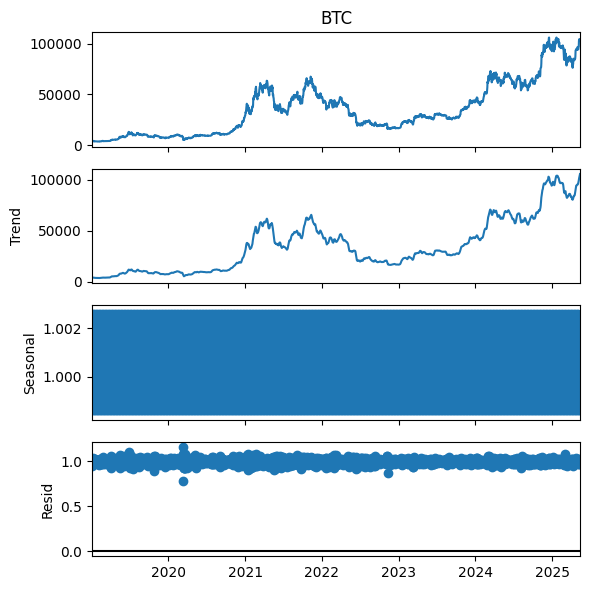

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#comprobamos la tendencia, estacionalidad y ruido

dadadada=combined_df.set_index(["Date"])

# Multiplicative Decomposition 
result_mul = seasonal_decompose(dadadada['BTC'], model = 'multiplicative', extrapolate_trend = 'freq')

# Additive Decomposition
result_add = seasonal_decompose(dadadada['BTC'], model = 'additive', extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul.plot();

In [ ]:
#comprobación de estacionalidad

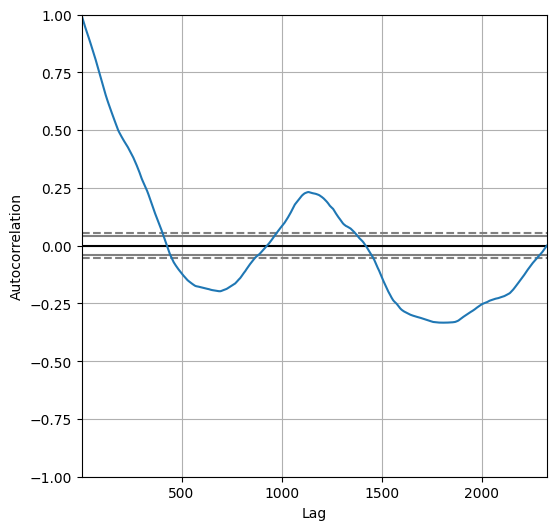

In [102]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(dadadada.BTC.values);

***primeros modelos***

In [94]:
#linear regressor, random forest, xgboost


Linear Regression:
 MSE: 1230594876.92
 MAE: 30777.40
 R²: -3.7042

Random Forest:
 MSE: 1321241949.53
 MAE: 32536.44
 R²: -4.0508

XGBoost:
 MSE: 1217825640.47
 MAE: 31400.49
 R²: -3.6554


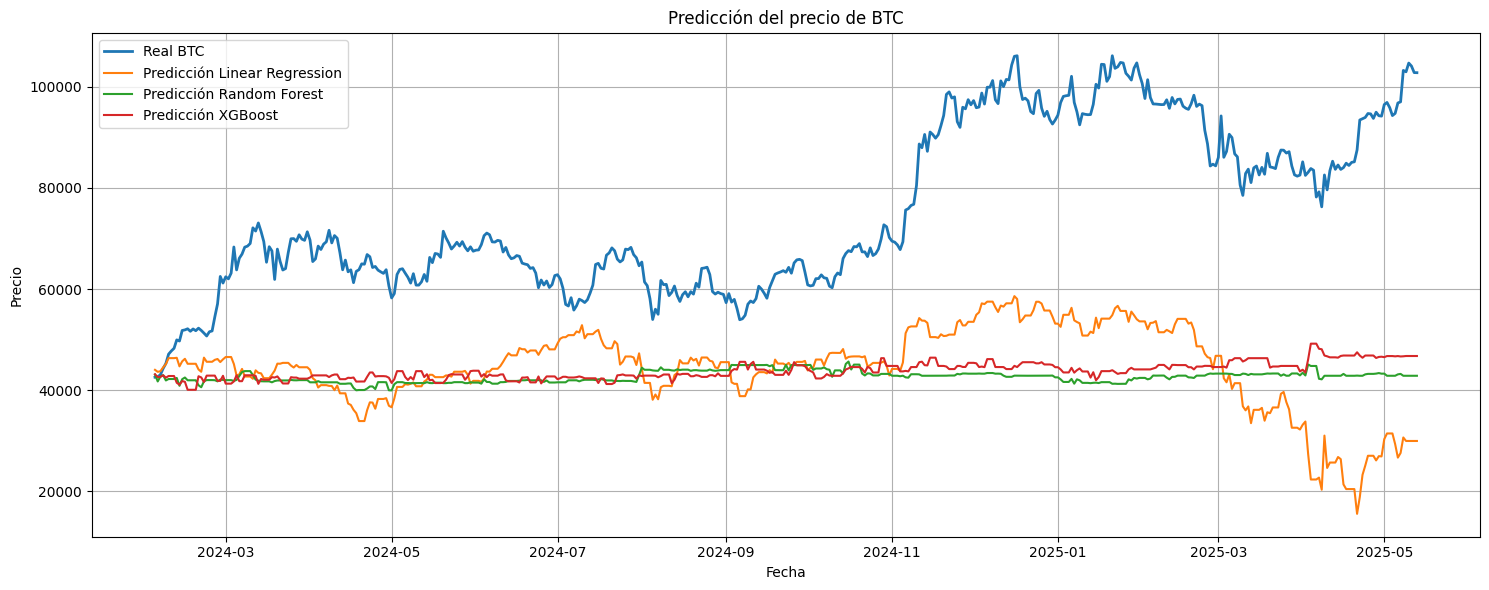

In [ ]:

# --- 1. Preparar datos ---
df = combined_df.copy()
df = df.dropna()  # Asegurar que no haya NaNs

# Objetivo: BTC, Features: todos los demás
X = df.drop(columns=["Date", "BTC"])
y = df["BTC"]

# --- 2. Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- 3. Modelos ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# --- 4. Entrenamiento y evaluación ---
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred),
        "Predicciones": y_pred
    }
    print(f"\n{name}:\n MSE: {results[name]['MSE']:.2f}\n MAE: {results[name]['MAE']:.2f}\n R²: {results[name]['R²']:.4f}")

# --- 5. Graficar predicción vs real ---
plt.figure(figsize=(15, 6))
plt.plot(df["Date"].iloc[y_test.index], y_test, label="Real BTC", linewidth=2)

for name in models:
    plt.plot(df["Date"].iloc[y_test.index], results[name]["Predicciones"], label=f"Predicción {name}")

plt.title("Predicción del precio de BTC")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#modelo ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31087.752, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31086.103, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31085.812, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31085.868, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31084.864, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.185 seconds
MAE: 32225.19, MSE: 1299849677.68


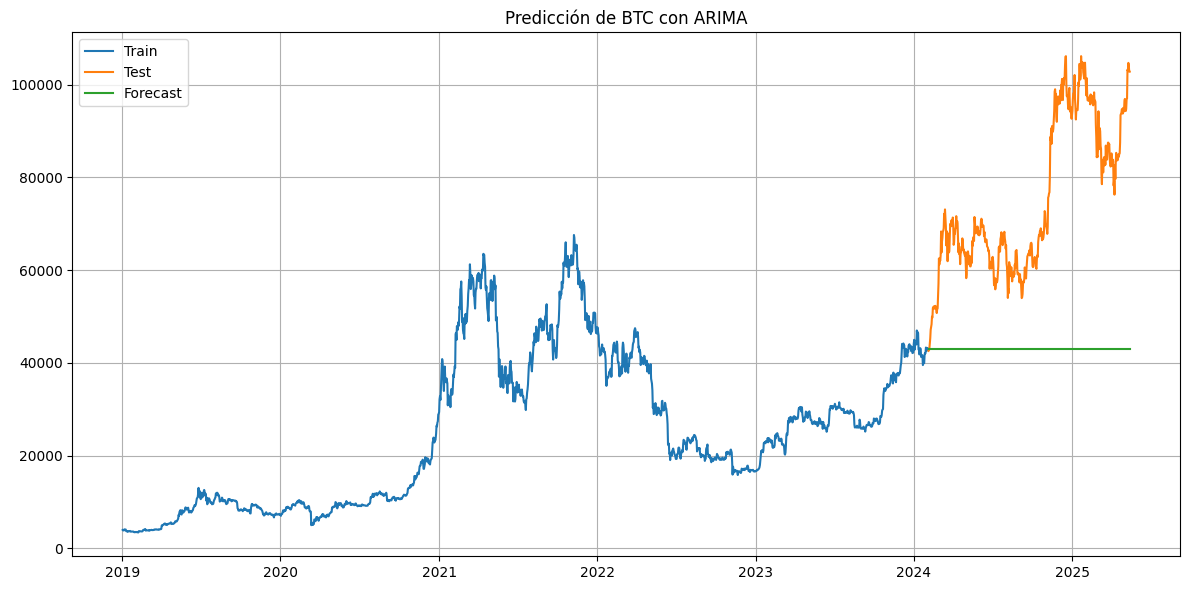

Proyección próximos 20 días:
2024-02-04    42992.25
2024-02-05    42992.25
2024-02-06    42992.25
2024-02-07    42992.25
2024-02-08    42992.25
2024-02-09    42992.25
2024-02-10    42992.25
2024-02-11    42992.25
2024-02-12    42992.25
2024-02-13    42992.25
2024-02-14    42992.25
2024-02-15    42992.25
2024-02-16    42992.25
2024-02-17    42992.25
2024-02-18    42992.25
2024-02-19    42992.25
2024-02-20    42992.25
2024-02-21    42992.25
2024-02-22    42992.25
2024-02-23    42992.25
Freq: D, dtype: float64

Proyección próximos 60 días:
2024-02-04    42992.25
2024-02-05    42992.25
2024-02-06    42992.25
2024-02-07    42992.25
2024-02-08    42992.25
2024-02-09    42992.25
2024-02-10    42992.25
2024-02-11    42992.25
2024-02-12    42992.25
2024-02-13    42992.25
2024-02-14    42992.25
2024-02-15    42992.25
2024-02-16    42992.25
2024-02-17    42992.25
2024-02-18    42992.25
2024-02-19    42992.25
2024-02-20    42992.25
2024-02-21    42992.25
2024-02-22    42992.25
2024-02-23    42992.

In [196]:



# 1. Cargar y preparar los datos
df = combined_df.copy()  # Asegúrate de tener combined_df ya cargado
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)
df.set_index("Date", inplace=True)

# Solo la serie de BTC
btc_series = df["BTC"].dropna()

# 2. División en entrenamiento y prueba
train_size = int(len(btc_series) * 0.8)
train, test = btc_series[:train_size], btc_series[train_size:]

# 3. Modelado automático con auto_arima
model = auto_arima(train,
                   start_p=1, start_q=1,
                   max_p=5, max_q=5,
                   d=1,
                   seasonal=False,
                   stepwise=True,
                   trace=True,
                   suppress_warnings=True)

# 4. Entrenamiento final
model.fit(train)

# 5. Predicción sobre el conjunto de prueba
n_test = len(test)
forecast = model.predict(n_periods=n_test)

# 6. Evaluación
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}")

# 7. Gráfica
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.title("Predicción de BTC con ARIMA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Proyección futura a 20 y 60 días
future_20 = model.predict(n_periods=20)
future_60 = model.predict(n_periods=60)

print("Proyección próximos 20 días:")
print(future_20)

print("\nProyección próximos 60 días:")
print(future_60)


In [197]:
#No hay estacionalidad ni variables externas
#Un ARIMA puro sin componentes estacionales ni features adicionales no capta dinámicas complejas. 
# En este caso, proyecta simplemente el último valor observado o una tendencia lineal mínima.

In [ ]:
#Modelo SARIMAX

In [ ]:


# 1. Cargar los datos (suponiendo que ya están en memoria)
btc_series = combined_df[['Date', 'BTC']].copy()
nasdaq_series = combined_df[['Date', 'NASDAQ']].copy()

# 2. Asegurar tipos y ordenar
btc_series['Date'] = pd.to_datetime(btc_series['Date'])
nasdaq_series['Date'] = pd.to_datetime(nasdaq_series['Date'])

btc_series.set_index('Date', inplace=True)
nasdaq_series.set_index('Date', inplace=True)

# 3. Alineación y sincronización
btc_series = btc_series.asfreq('D').ffill()
nasdaq_series = nasdaq_series.asfreq('D').ffill()

# 4. Unir y crear dataset final
df = pd.concat([btc_series, nasdaq_series], axis=1)
df.columns = ['BTC', 'NASDAQ']
df.dropna(inplace=True)

# 5. División en train/test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 6. Modelo SARIMAX (ajusta los hiperparámetros si es necesario)
model = SARIMAX(train['BTC'],
                exog=train[['NASDAQ']],
                order=(1, 1, 1),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# 7. Predicción en el test set
pred = results.predict(start=test.index[0], end=test.index[-1], exog=test[['NASDAQ']])

# 8. Evaluación
mse = mean_squared_error(test['BTC'], pred)
mae = mean_absolute_error(test['BTC'], pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

# 9. Gráfico predicción vs real
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train['BTC'][-100:], label='Train')
plt.plot(test.index, test['BTC'], label='Actual BTC')
plt.plot(test.index, pred, label='Predicted BTC', linestyle='--')
plt.legend()
plt.title("Predicción de BTC usando SARIMAX con NASDAQ como exógena")
plt.show()

# 10. Predicción a futuro (20 y 60 días)
future_nasdaq = nasdaq_series[-60:].copy()

# Simula valores futuros constantes (mejor si se proyecta NASDAQ por separado)
exog_future = pd.DataFrame({'NASDAQ': [future_nasdaq.iloc[-1]] * 60},
                           index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=60, freq='D'))

future_forecast = results.predict(start=len(df), end=len(df)+59, exog=exog_future)

# 11. Graficar proyección futura
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['BTC'].iloc[-100:], label='Histórico BTC')
plt.plot(exog_future.index[:20], future_forecast[:20], label='Proyección 20 días', linestyle='--')
plt.plot(exog_future.index, future_forecast, label='Proyección 60 días', linestyle=':')
plt.title("Proyección futura de BTC con SARIMAX")
plt.legend()
plt.show()


In [ ]:
#SARIMAX multivariable

In [ ]:


# 1. Preparar dataset
df = combined_df_extended[['Date', 'BTC', 'NASDAQ', 'SP500_F', 'US10Y']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D').ffill().dropna()

# 2. Separar en target y features
target_col = 'BTC'
feature_cols = ['NASDAQ', 'SP500_F', 'US10Y']

# 3. Split en entrenamiento y test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 4. Modelo SARIMAX multivariable
model = SARIMAX(train[target_col],
                exog=train[feature_cols],
                order=(1, 1, 1),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# 5. Predicción en test
pred = results.predict(start=test.index[0], end=test.index[-1], exog=test[feature_cols])

# 6. Evaluación
mse = mean_squared_error(test[target_col], pred)
mae = mean_absolute_error(test[target_col], pred)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

# 7. Graficar test vs predicción
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train[target_col][-100:], label='Train')
plt.plot(test.index, test[target_col], label='Actual BTC')
plt.plot(test.index, pred, label='Predicción BTC', linestyle='--')
plt.legend()
plt.title("BTC vs SARIMAX Prediction")
plt.show()

# 8. Proyección futura (20 y 60 días)
future_steps = 60

# Simular futuro de features usando último valor (puedes usar ARIMA para proyectarlos mejor)
last_known = df[feature_cols].iloc[-1]
future_exog = pd.DataFrame(
    [last_known.values] * future_steps,
    columns=feature_cols,
    index=pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=future_steps)
)

forecast = results.predict(start=len(df), end=len(df) + future_steps - 1, exog=future_exog)

# 9. Graficar proyección futura
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df[target_col][-100:], label='Histórico BTC')
plt.plot(forecast.index[:20], forecast[:20], label='Proyección 20 días', linestyle='--')
plt.plot(forecast.index, forecast, label='Proyección 60 días', linestyle=':')
plt.legend()
plt.title("Proyección futura BTC (SARIMAX multivariable)")
plt.show()



In [ ]:
#modelo LSTM

In [252]:
combined_df


Date            BTC          DJIA          XAU        NASDAQ  \
0    2019-01-02    3943.409424  23346.240234  1281.000000   6665.939941   
1    2019-01-03    3836.741211  22686.220703  1291.800049   6463.500000   
2    2019-01-04    3857.717529  23433.160156  1282.699951   6738.859863   
3    2019-01-05    3845.194580  23433.160156  1282.699951   6738.859863   
4    2019-01-06    4076.632568  23433.160156  1282.699951   6738.859863   
...         ...            ...           ...          ...           ...   
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y        WTI  
0     2510.030029  2.661  46.540001  
1     2447.889893  2.554  47.090000  
2     2531.939941  2.659  47.959999  
3     2531.939941  2.659  47.959999  
4     2531.939941  2.659  47.959999  
...           ...    ...        ...  
2319  5659.910156  4.375  61.020000  
2320  5659.910156  4.375  61.020000  
2321  5659.910156  4.375  61.020000  
2322  5659.910156  4.375  61.020000  
2323  5659.910156  4.375  61.020000  

[2324 rows x 8 columns]

## Modelo LSTM

### Modelo original

Epoch 1/20
12/12 [==============================] - 2s 45ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 2/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/20
12/12 [==============================] - 0s 14ms/step - loss: 9.6854e-04 - val_loss: 0.0015
Epoch 4/20
12/12 [==============================] - 0s 14ms/step - loss: 7.3219e-04 - val_loss: 6.6852e-04
Epoch 5/20
12/12 [==============================] - 0s 14ms/step - loss: 5.9077e-04 - val_loss: 4.3632e-04
Epoch 6/20
12/12 [==============================] - 0s 14ms/step - loss: 5.2069e-04 - val_loss: 4.2395e-04
Epoch 7/20
12/12 [==============================] - 0s 14ms/step - loss: 4.4921e-04 - val_loss: 4.7431e-04
Epoch 8/20
12/12 [==============================] - 0s 14ms/step - loss: 5.1838e-04 - val_loss: 6.3687e-04
Epoch 9/20
12/12 [==============================] - 0s 14ms/step - loss: 5.2295e-04 - val_loss: 2.6724e-04
Epoch 10/20
12/12 [==============================] - 0s 1

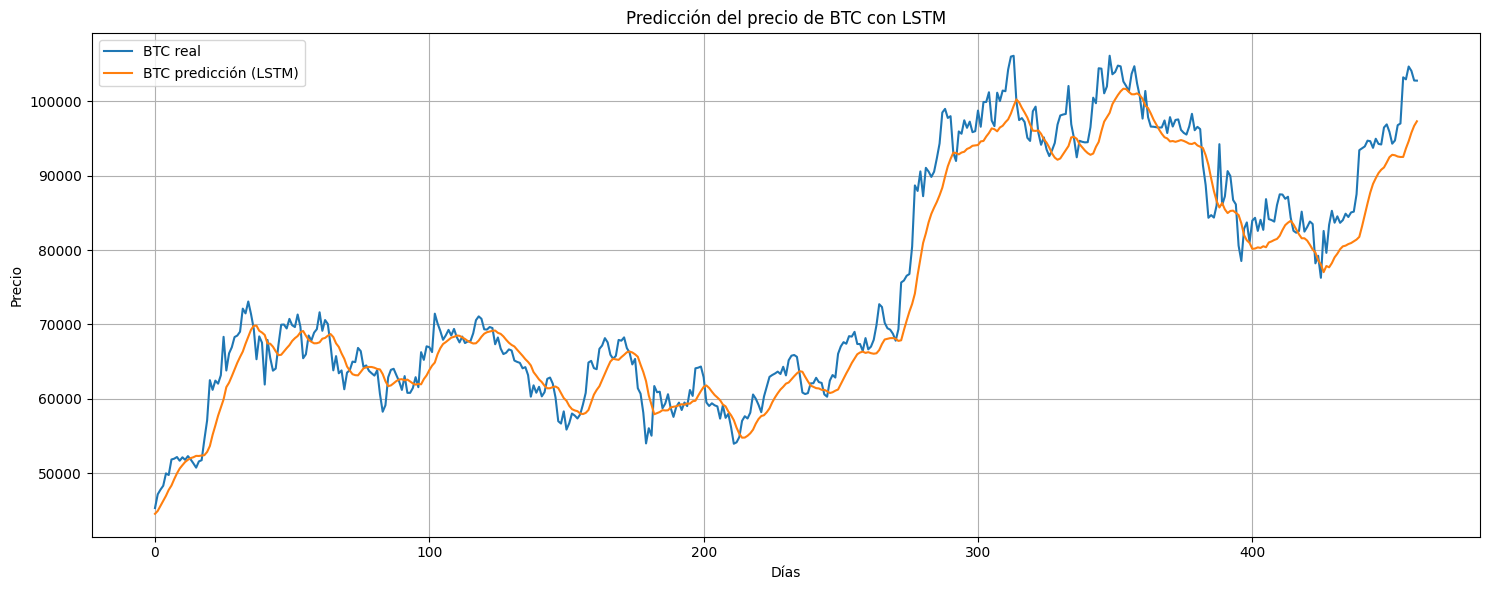

In [284]:

# 1. Preparar datos
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

# Escalar
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 2. Crear secuencias (X) y objetivos (y)
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[(i - lookback):i, :])  # secuencia multivariable
        y.append(data[i, 0])  # objetivo: columna 0 (BTC)
    return np.array(X), np.array(y)

#duración de la ventana de tiempo a predecir 
lookback = 20
X, y = create_sequences(scaled_data, lookback)

# 3. Separar en entrenamiento y prueba (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Construir el modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 5. Entrenar
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=150, validation_split=0.1, callbacks=[es], verbose=1)

# 6. Predecir
y_pred = model.predict(X_test)

# 7. Invertir escala para comparar
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_unscaled = scaler.inverse_transform(np.hstack([btc_scaled, np.zeros((len(btc_scaled), df.shape[1]-1))]))[:, 0]

y_test_unscaled = btc_unscaled[(lookback + split):]
y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), df.shape[1]-1))]))[:, 0]

# 8. Evaluación
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)

print(f"LSTM - MSE: {mse:.2f}, MAE: {mae:.2f}")

# 9. Gráfico
plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label="BTC real")
plt.plot(y_pred_unscaled, label="BTC predicción (LSTM)")
plt.title("Predicción del precio de BTC con LSTM")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [302]:


# 2. Crear secuencias (X) y objetivos (y)
def create_sequences(data, lookback=60,horizon= 20):
    X, y = [], []
    for i in range(lookback, len(data)-horizon):
        X.append(data[(i - lookback):i, :])  # secuencia multivariable
        y.append(data[i+horizon, 0])  # objetivo: columna 0 (BTC)
    return np.array(X), np.array(y)

#duración de la ventana de tiempo a predecir 
lookback = 20
horizon=5
X, y = create_sequences(scaled_data, lookback, horizon)

# 3. Separar en entrenamiento y prueba (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Construir el modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 5. Entrenar
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=150, validation_split=0.1, callbacks=[es], verbose=1)

# 6. Predecir
y_pred = model.predict(X_test)



Epoch 1/20
12/12 [==============================] - 2s 48ms/step - loss: 0.0542 - val_loss: 0.0182
Epoch 2/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 3/20
12/12 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 4/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 5/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 6/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/20
12/12 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 9.5525e-04
Epoch

In [271]:

# 7. Invertir escala para comparar
#btc_scaled = scaled_data[:, 0].reshape(-1, 1)
#btc_unscaled = scaler.inverse_transform(np.hstack([btc_scaled, np.zeros((len(btc_scaled), df.shape[1]-1))]))[:, 0]



LSTM - MSE: 50195392.19, MAE: 5455.34


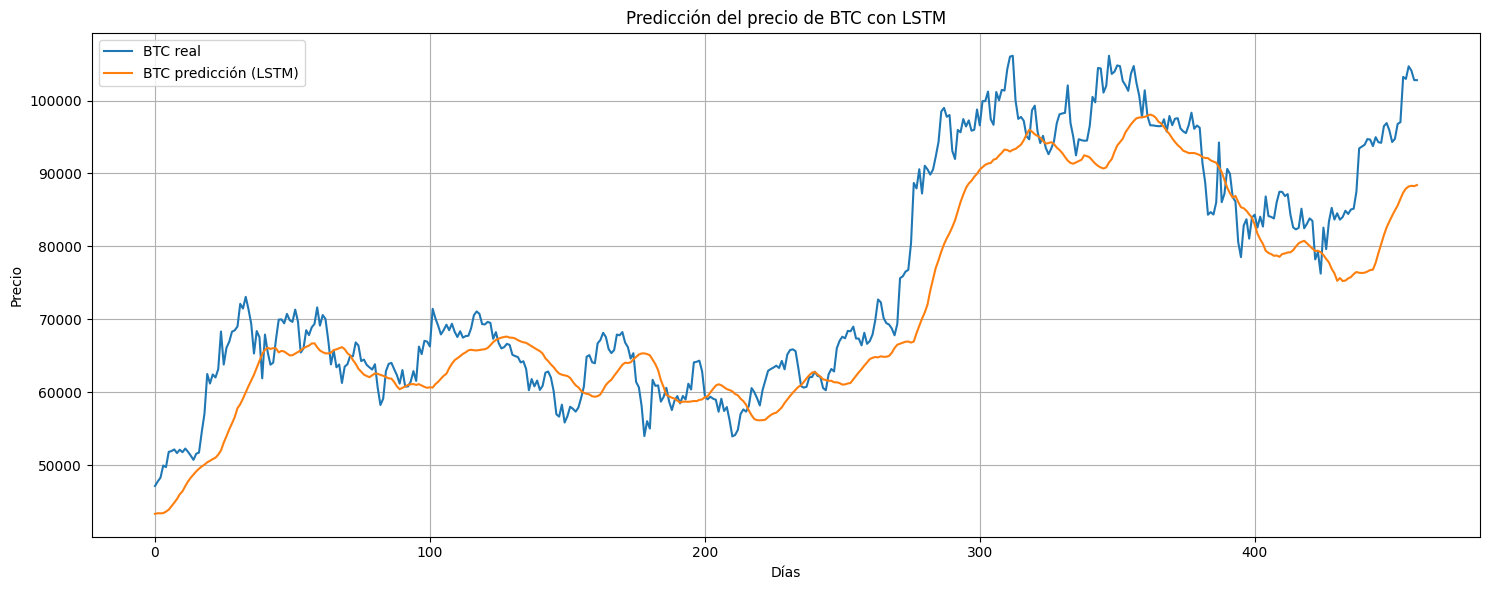

In [303]:
y_test_unscaled = btc_unscaled[(lookback + split+horizon):]
y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), df.shape[1]-1))]))[:, 0]

# 8. Evaluación
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)

print(f"LSTM - MSE: {mse:.2f}, MAE: {mae:.2f}")

# 9. Gráfico
plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label="BTC real")
plt.plot(y_pred_unscaled, label="BTC predicción (LSTM)")
plt.title("Predicción del precio de BTC con LSTM")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

LSTM - MSE: 0.02, MAE: 0.12


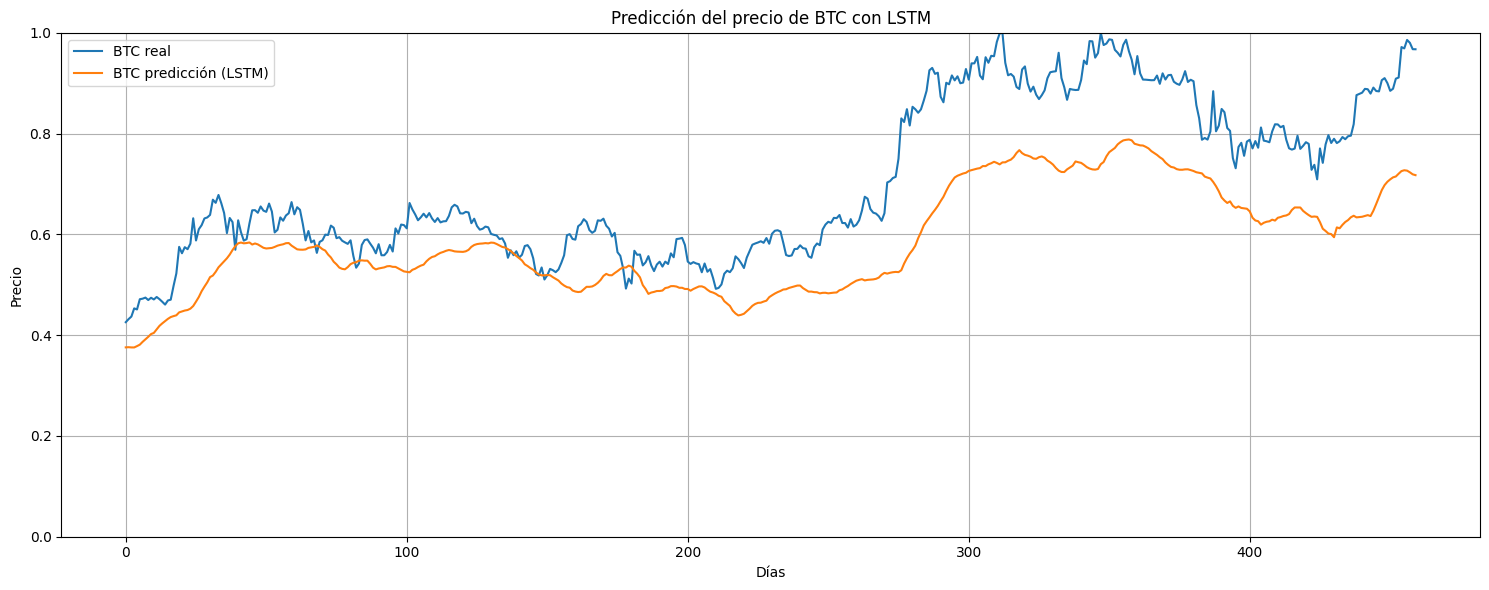

In [265]:


# 8. Evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"LSTM - MSE: {mse:.2f}, MAE: {mae:.2f}")

# 9. Gráfico
plt.figure(figsize=(15, 6))
plt.plot(y_test, label="BTC real")
plt.plot(y_pred, label="BTC predicción (LSTM)")
plt.title("Predicción del precio de BTC con LSTM")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim((0,1))
plt.show()



In [ ]:
#modelo LSTM 2
#Modelo LSTM mejorado (Bidireccional + Dropout)

In [111]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

Epoch 1/10
52/52 [==============================] - 5s 33ms/step - loss: 0.0092 - val_loss: 6.5830e-04
Epoch 2/10
52/52 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 3.7564e-04
Epoch 3/10
52/52 [==============================] - 1s 17ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/10
52/52 [==============================] - 1s 17ms/step - loss: 9.9087e-04 - val_loss: 2.6623e-04
Epoch 5/10
52/52 [==============================] - 1s 17ms/step - loss: 8.7333e-04 - val_loss: 9.6022e-04
Epoch 6/10
52/52 [==============================] - 1s 18ms/step - loss: 9.0060e-04 - val_loss: 2.5518e-04
Epoch 7/10
52/52 [==============================] - 1s 17ms/step - loss: 7.0357e-04 - val_loss: 2.0061e-04
Epoch 8/10
52/52 [==============================] - 1s 18ms/step - loss: 6.9852e-04 - val_loss: 5.3687e-04
Epoch 9/10
52/52 [==============================] - 1s 21ms/step - loss: 6.0414e-04 - val_loss: 7.9157e-04
Epoch 10/10
15/15 [==============================] - 

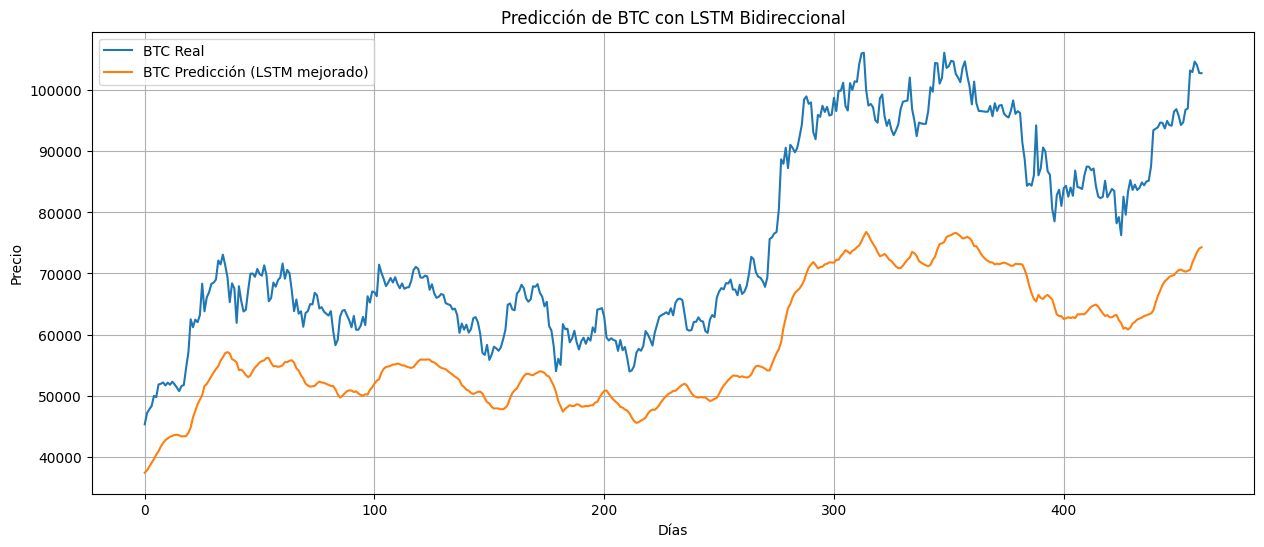

In [124]:

# 1. Cargar datos
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

# 2. Escalar
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 3. Crear secuencias
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])
        y.append(data[i, 0])  # BTC
    return np.array(X), np.array(y)

lookback = 20
X, y = create_sequences(scaled_data, lookback)

# 4. División entrenamiento/prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Modelo LSTM mejorado
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 6. Entrenar
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

# 7. Predecir
y_pred = model.predict(X_test)

# 8. Invertir escalado
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_full = np.hstack([btc_scaled, np.zeros((len(btc_scaled), df.shape[1]-1))])
btc_unscaled = scaler.inverse_transform(btc_full)[:, 0]

y_test_unscaled = btc_unscaled[lookback + split:]
y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), df.shape[1]-1))]))[:, 0]

# 9. Evaluación
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

# 10. Gráfico
plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label="BTC Real")
plt.plot(y_pred_unscaled, label="BTC Predicción (LSTM mejorado)")
plt.title("Predicción de BTC con LSTM Bidireccional")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()


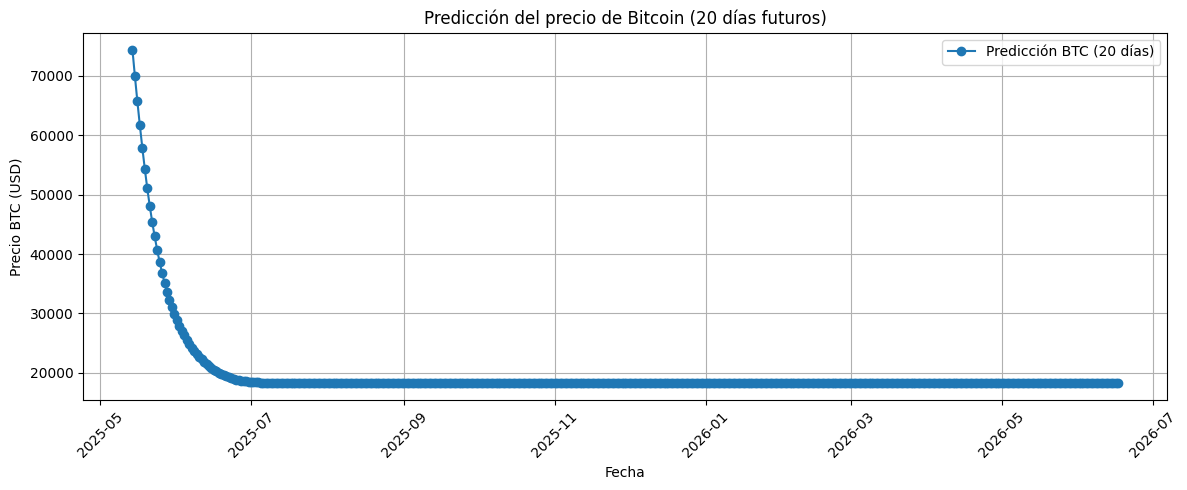

In [125]:
# Predicción de los próximos 20 días usando el modelo LSTM entrenado previamente

last_sequence = scaled_data[-lookback:]  # Últimos 60 días
future_predictions = []
current_sequence = last_sequence.copy()

for _ in range(400):
    input_seq = current_sequence.reshape(1, lookback, scaled_data.shape[1])
    next_pred = model.predict(input_seq, verbose=0)
    
    # Concatenar predicción con variables auxiliares
    next_input = np.append(next_pred, current_sequence[-1, 1:]).reshape(1, -1)
    current_sequence = np.vstack([current_sequence[1:], next_input])
    
    future_predictions.append(next_pred[0, 0])

# Inversión de escalado
future_predictions_scaled = np.array(future_predictions).reshape(-1, 1)
padding = np.zeros((len(future_predictions_scaled), df.shape[1] - 1))
future_input = np.hstack([future_predictions_scaled, padding])
future_prices = scaler.inverse_transform(future_input)[:, 0]

# Crear fechas futuras
last_date = pd.to_datetime(combined_df["Date"].iloc[-1])
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=400)

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_prices, marker='o', label="Predicción BTC (20 días)")
plt.title("Predicción del precio de Bitcoin (20 días futuros)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/75
52/52 [==============================] - 2s 12ms/step - loss: 0.0032 - val_loss: 4.2240e-04
Epoch 2/75
52/52 [==============================] - 0s 5ms/step - loss: 5.3077e-04 - val_loss: 2.8008e-04
Epoch 3/75
52/52 [==============================] - 0s 5ms/step - loss: 4.8246e-04 - val_loss: 2.8173e-04
Epoch 4/75
52/52 [==============================] - 0s 5ms/step - loss: 4.5225e-04 - val_loss: 2.7089e-04
Epoch 5/75
52/52 [==============================] - 0s 5ms/step - loss: 3.9591e-04 - val_loss: 4.8968e-04
Epoch 6/75
52/52 [==============================] - 0s 5ms/step - loss: 3.4237e-04 - val_loss: 1.8942e-04
Epoch 7/75
52/52 [==============================] - 0s 6ms/step - loss: 3.2725e-04 - val_loss: 1.8045e-04
Epoch 8/75
52/52 [==============================] - 0s 5ms/step - loss: 3.5382e-04 - val_loss: 1.7285e-04
Epoch 9/75
52/52 [==============================] - 0s 6ms/step - loss: 3.2708e-04 - val_loss: 1.6669e-04
Epoch 10/75
52/52 [==============================

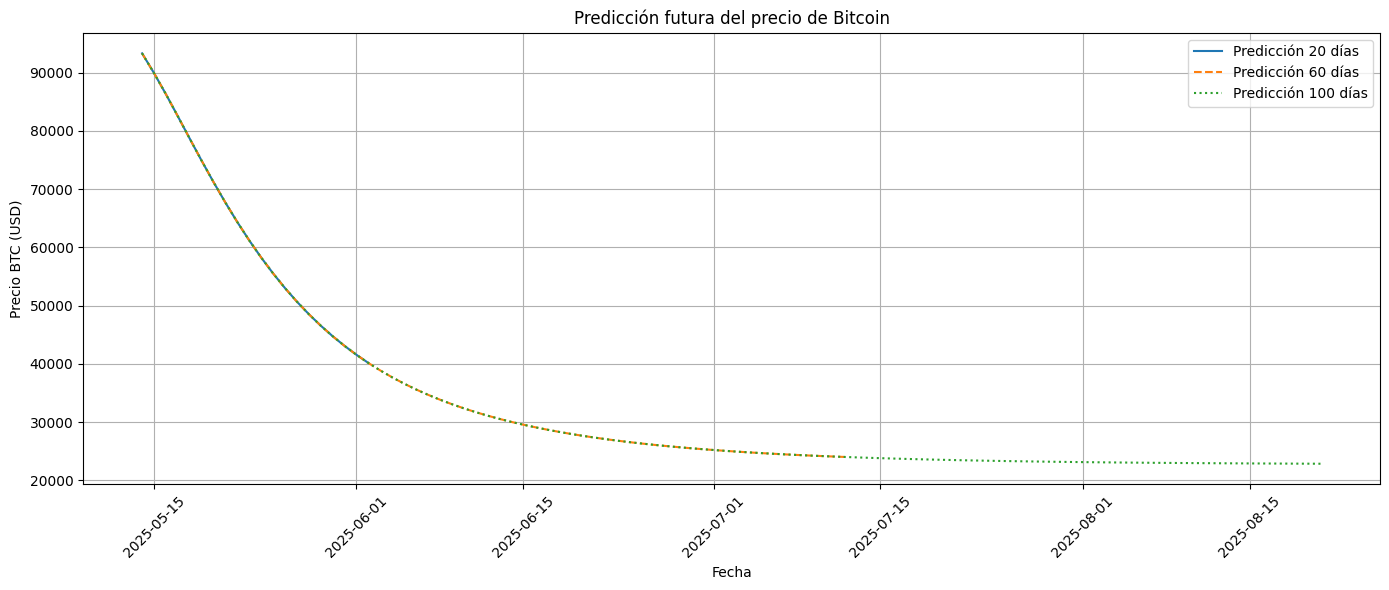

In [122]:

from tensorflow.keras.layers import LSTM, Dense


# -----------------------------------------
# 1. Asegúrate de tener el DataFrame combined_df
# Debe tener una columna "Date" y una columna "BTC"
# + otras series macroeconómicas alineadas en el tiempo.
# Ejemplo de carga:
# combined_df = pd.read_csv("your_combined_data.csv")
# -----------------------------------------

# 2. Preparar datos
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 3. Crear secuencias
def create_sequences(data, lookback=20):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])  # secuencia multivariable
        y.append(data[i, 0])  # objetivo: BTC
    return np.array(X), np.array(y)

lookback = 20
X, y = create_sequences(scaled_data, lookback)

# 4. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Construir el modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 6. Entrenar
es = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=75, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

# 7. Función para predecir futuros n días
def predict_future_days(model, last_sequence, steps, lookback, scaled_data, df, scaler):
    current_sequence = last_sequence.copy()
    future_predictions = []
    for _ in range(steps):
        input_seq = current_sequence.reshape(1, lookback, scaled_data.shape[1])
        next_pred = model.predict(input_seq, verbose=0)
        next_input = np.append(next_pred, current_sequence[-1, 1:]).reshape(1, -1)
        current_sequence = np.vstack([current_sequence[1:], next_input])
        future_predictions.append(next_pred[0, 0])
    
    # Invertir escala
    future_predictions_scaled = np.array(future_predictions).reshape(-1, 1)
    padding = np.zeros((len(future_predictions_scaled), df.shape[1] - 1))
    future_input = np.hstack([future_predictions_scaled, padding])
    future_prices = scaler.inverse_transform(future_input)[:, 0]
    return future_prices

# 8. Última secuencia
last_sequence = scaled_data[-lookback:]

# Predicciones
future_20 = predict_future_days(model, last_sequence, 20, lookback, scaled_data, df, scaler)
future_60 = predict_future_days(model, last_sequence, 60, lookback, scaled_data, df, scaler)
future_100 = predict_future_days(model, last_sequence, 100, lookback, scaled_data, df, scaler)

# 9. Crear fechas futuras
last_date = pd.to_datetime(combined_df["Date"].iloc[-1])
dates_20 = pd.date_range(last_date + pd.Timedelta(days=1), periods=20)
dates_60 = pd.date_range(last_date + pd.Timedelta(days=1), periods=60)
dates_100 = pd.date_range(last_date + pd.Timedelta(days=1), periods=100)

# 10. Graficar
plt.figure(figsize=(14, 6))
plt.plot(dates_20, future_20, label="Predicción 20 días")
plt.plot(dates_60, future_60, linestyle='--', label="Predicción 60 días")
plt.plot(dates_100, future_100, linestyle=':', label="Predicción 100 días")
plt.title("Predicción futura del precio de Bitcoin")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#LSTM univariado

Epoch 1/20
7/7 [==============================] - 2s 138ms/step - loss: 0.0450 - val_loss: 0.0082
Epoch 2/20
7/7 [==============================] - 0s 71ms/step - loss: 0.0079 - val_loss: 0.0040
Epoch 3/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 4/20
7/7 [==============================] - 1s 73ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 5/20
7/7 [==============================] - 1s 77ms/step - loss: 0.0014 - val_loss: 2.9697e-04
Epoch 6/20
7/7 [==============================] - 1s 75ms/step - loss: 0.0010 - val_loss: 2.3441e-04
Epoch 7/20
7/7 [==============================] - 0s 72ms/step - loss: 5.9063e-04 - val_loss: 7.7874e-04
Epoch 8/20
7/7 [==============================] - 1s 72ms/step - loss: 6.0993e-04 - val_loss: 2.7364e-04
Epoch 9/20
7/7 [==============================] - 1s 72ms/step - loss: 5.7341e-04 - val_loss: 3.0712e-04
Epoch 10/20
7/7 [==============================] - 1s 72ms/step - loss: 5.2813e-04 - val_loss:

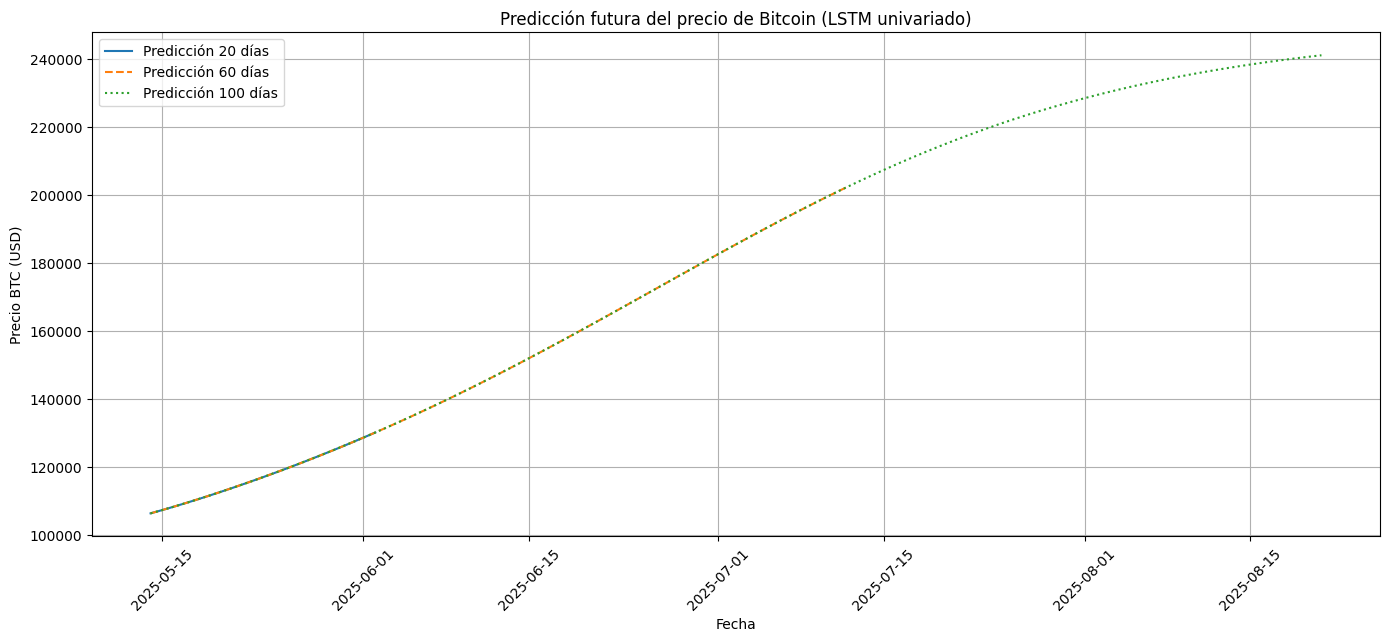

In [132]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Asegúrate de tener 'combined_df'
# con una columna 'Date' y 'BTC'
# -------------------------------

# 1. Preparar los datos
btc = combined_df[["Date", "BTC"]].copy()
btc.dropna(inplace=True)

scaler = MinMaxScaler()
btc_scaled = scaler.fit_transform(btc[["BTC"]])

# 2. Crear secuencias
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 120
X, y = create_sequences(btc_scaled, lookback)

# 3. Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Construir el modelo
model = Sequential([
    LSTM(64, input_shape=(lookback, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss='mse')

# 5. Entrenamiento
es = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=20, batch_size=220, validation_split=0.2, callbacks=[es], verbose=1)

# 6. Predicción futura
def predict_future(model, last_sequence, steps, scaler):
    future = []
    current = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(current.reshape(1, lookback, 1), verbose=0)[0][0]
        future.append(pred)
        current = np.append(current[1:], [[pred]], axis=0)
    future = scaler.inverse_transform(np.array(future).reshape(-1, 1)).flatten()
    return future

# Última secuencia
last_sequence = btc_scaled[-lookback:]

# Predicciones
future_20 = predict_future(model, last_sequence, 20, scaler)
future_60 = predict_future(model, last_sequence, 60, scaler)
future_100 = predict_future(model, last_sequence, 100, scaler)

# Fechas
last_date = pd.to_datetime(btc["Date"].iloc[-1])
dates_20 = pd.date_range(last_date + pd.Timedelta(days=1), periods=20)
dates_60 = pd.date_range(last_date + pd.Timedelta(days=1), periods=60)
dates_100 = pd.date_range(last_date + pd.Timedelta(days=1), periods=100)

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(dates_20, future_20, label="Predicción 20 días")
plt.plot(dates_60, future_60, '--', label="Predicción 60 días")
plt.plot(dates_100, future_100, ':', label="Predicción 100 días")
plt.title("Predicción futura del precio de Bitcoin (LSTM univariado)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [ ]:
#las predicciones a futuro no son realistas

In [ ]:
#optimización bayessiana y modelo LSTM de varias capas

In [ ]:
import keras_tuner as kt
#para hiperparametrizar los modelos secunciales 

In [134]:



# -----------------------------------
# 1. Preparar los datos
# -----------------------------------
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Crear secuencias
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])
        y.append(data[i, 0])  # Precio BTC
    return np.array(X), np.array(y)

lookback = 60
X, y = create_sequences(scaled_data, lookback)

# Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -----------------------------------
# 2. Modelo con optimización bayesiana
# -----------------------------------
def build_model(hp):
    model = Sequential()
    
    # Capa LSTM inicial
    model.add(LSTM(units=hp.Int("units_1", min_value=32, max_value=128, step=16),
                   return_sequences=True,
                   input_shape=(X.shape[1], X.shape[2])))
    
    # Segunda capa LSTM opcional
    if hp.Boolean("add_second_layer"):
        model.add(LSTM(units=hp.Int("units_2", min_value=32, max_value=128, step=16),
                       return_sequences=False))
    else:
        model.add(LSTM(units=hp.Int("units_2_alt", min_value=32, max_value=128, step=16),
                       return_sequences=False))

    # Dropout opcional
    if hp.Boolean("use_dropout"):
        model.add(Dropout(rate=hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model

# -----------------------------------
# 3. Tuning con Keras Tuner
# -----------------------------------
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='bayes_opt_dir',
    project_name='lstm_btc'
)

stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_split=0.2,
             callbacks=[stop],
             verbose=1)

# -----------------------------------
# 4. Entrenar el mejor modelo
# -----------------------------------
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(X_train, y_train,
                         epochs=100,
                         batch_size=32,
                         validation_split=0.2,
                         callbacks=[stop],
                         verbose=1)

# -----------------------------------
# 5. Predicción y evaluación
# -----------------------------------
y_pred = best_model.predict(X_test)

# Invertir escalado
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_unscaled = scaler.inverse_transform(np.hstack([btc_scaled, np.zeros((len(btc_scaled), df.shape[1] - 1))]))[:, 0]

y_test_unscaled = btc_unscaled[lookback + split:]
y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), df.shape[1] - 1))]))[:, 0]

# Métricas
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test_unscaled, y_pred_unscaled))
print("MSE:", mean_squared_error(y_test_unscaled, y_pred_unscaled))


Trial 20 Complete [00h 01m 00s]
val_loss: 0.00015337285003624856

Best val_loss So Far: 8.179301948985085e-05
Total elapsed time: 00h 28m 20s
Epoch 1/100
46/46 [==============================] - 5s 48ms/step - loss: 1.5633e-04 - val_loss: 2.4399e-04
Epoch 2/100
46/46 [==============================] - 2s 33ms/step - loss: 1.8231e-04 - val_loss: 1.5145e-04
Epoch 3/100
46/46 [==============================] - 2s 33ms/step - loss: 1.4008e-04 - val_loss: 7.9234e-05
Epoch 4/100
46/46 [==============================] - 2s 34ms/step - loss: 1.5735e-04 - val_loss: 8.9956e-05
Epoch 5/100
46/46 [==============================] - 2s 34ms/step - loss: 1.4148e-04 - val_loss: 1.0694e-04
Epoch 6/100
46/46 [==============================] - 2s 34ms/step - loss: 1.5912e-04 - val_loss: 1.2146e-04
Epoch 7/100
46/46 [==============================] - 2s 34ms/step - loss: 1.5688e-04 - val_loss: 1.8875e-04
Epoch 8/100
46/46 [==============================] - 2s 34ms/step - loss: 1.5500e-04 - val_loss: 1.703

13/13 [==============================] - 1s 20ms/step


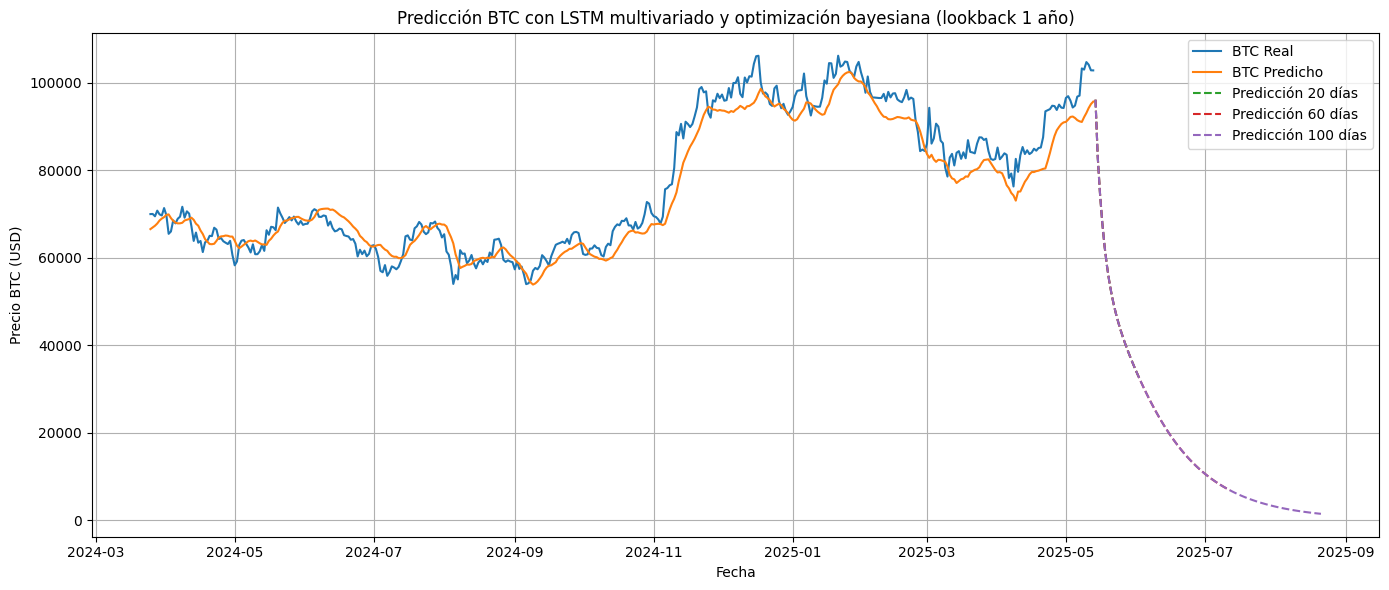

{'units_1': 64,
 'return_seq': False,
 'add_lstm': False,
 'use_dropout': False,
 'dropout_rate': 0.4}

In [ ]:

#predice el día siguiente en base a un lookback dado( mirada hacia atrás)


# Prepare the data
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences with lookback of 1 year (~252 days)
def create_sequences(data, lookback=252):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])
        y.append(data[i, 0])  # Predicting BTC (first column)
    return np.array(X), np.array(y)

lookback = 252
X, y = create_sequences(scaled_data, lookback)

# Split into train/test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define model builder for Bayesian Optimization
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32),
        return_sequences=hp.Boolean('return_seq'),
        input_shape=(X.shape[1], X.shape[2])
    ))
    if hp.Boolean('add_lstm'):
        model.add(LSTM(
            units=hp.Int('units_2', min_value=32, max_value=128, step=32)
        ))
    if hp.Boolean('use_dropout'):
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Bayesian tuner setup
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    directory='lstm_tuning',
    project_name='btc_price_prediction'
)

# Fit tuner
es = EarlyStopping(patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[es], verbose=0)

# Get best model
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

# Refit the best model
history = best_model.fit(X_train, y_train, epochs=25, validation_split=0.2, callbacks=[es], verbose=0,batch_size=300)

# Predict on test set
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actuals
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_unscaled = scaler.inverse_transform(np.hstack([btc_scaled, np.zeros((len(btc_scaled), df.shape[1] - 1))]))[:, 0]

y_test_unscaled = btc_unscaled[lookback + split:]
y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), df.shape[1] - 1))]))[:, 0]

# Predict next 100 days
future_preds = []
last_sequence = scaled_data[-lookback:]
current_seq = last_sequence.copy()

for _ in range(100):
    input_seq = np.expand_dims(current_seq, axis=0)
    next_pred = best_model.predict(input_seq, verbose=0)[0, 0]
    future_preds.append(next_pred)
    next_row = np.zeros((df.shape[1],))
    next_row[0] = next_pred
    current_seq = np.vstack([current_seq[1:], next_row])

future_preds_unscaled = scaler.inverse_transform(np.hstack([np.array(future_preds).reshape(-1, 1),
                                                             np.zeros((100, df.shape[1] - 1))]))[:, 0]

# Generate future dates
future_dates = pd.date_range(combined_df["Date"].iloc[-1], periods=101, freq="D")[1:]

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(combined_df["Date"].iloc[-len(y_test_unscaled):], y_test_unscaled, label="BTC Real")
plt.plot(combined_df["Date"].iloc[-len(y_test_unscaled):], y_pred_unscaled, label="BTC Predicho")
plt.plot(future_dates[:20], future_preds_unscaled[:20], "--", label="Predicción 20 días")
plt.plot(future_dates[:60], future_preds_unscaled[:60], "--", label="Predicción 60 días")
plt.plot(future_dates, future_preds_unscaled, "--", label="Predicción 100 días")
plt.title("Predicción BTC con LSTM multivariado y optimización bayesiana (lookback 1 año)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

best_hp.values


In [220]:


# --- Configuración ---
lookback = 252
forecast_horizon = 20  # Días futuros a predecir

# --- Preprocesamiento ---
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# --- Nueva función para secuencias multivariables + salida múltiple ---
def create_sequences(data, lookback=252, horizon=20):
    X, y = [], []
    for i in range(lookback, len(data) - horizon):
        X.append(data[i - lookback:i, :])
        y.append(data[i:i + horizon, 0])  # horizonte de predicción de BTC
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, lookback, forecast_horizon)

# --- Train/Test ---
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Modelo para Keras Tuner ---
def build_model(hp):
    model = Sequential()

    # Primera capa LSTM
    units_1 = hp.Int('units_1', 32, 128, step=32)
    add_lstm = hp.Boolean('add_lstm')

    return_sequences = True if add_lstm else False  # importante

    model.add(LSTM(
        units=units_1,
        return_sequences=return_sequences,
        input_shape=(X.shape[1], X.shape[2])
    ))

    # Segunda capa LSTM opcional
    if add_lstm:
        units_2 = hp.Int('units_2', 32, 128, step=32)
        model.add(LSTM(units=units_2))

    # Dropout opcional
    if hp.Boolean('use_dropout'):
        model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    # Capa de salida con horizonte de predicción
    model.add(Dense(forecast_horizon))

    model.compile(optimizer='adam', loss='mse')
    return model

   


# --- Tuner ---
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='lstm_tuning',
    project_name='btc_multiday_prediction'
)

es = EarlyStopping(patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=10, validation_split=0.1, callbacks=[es], verbose=0)

# --- Entrenamiento final ---
best_model = tuner.get_best_models(1)[0]
history = best_model.fit(X_train, y_train, epochs=25, validation_split=0.2, callbacks=[es], verbose=0, batch_size=300)

# --- Predicción ---
y_pred = best_model.predict(X_test)

# --- Inversión de escala ---
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_unscaled = scaler.inverse_transform(np.hstack([btc_scaled, np.zeros((len(btc_scaled), df.shape[1] - 1))]))[:, 0]

# Coincidir tamaño real y predicho
y_test_unscaled = np.array([btc_unscaled[i + lookback:i + lookback + forecast_horizon] for i in range(split, split + len(y_pred))])
y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), df.shape[1] - 1))]))[:, 0:forecast_horizon]

# --- Graficar una muestra ---
idx = 0  # puedes variar esto para ver distintas predicciones

plt.figure(figsize=(12, 6))
plt.plot(range(forecast_horizon), y_test_unscaled[idx], label="BTC Real")
plt.plot(range(forecast_horizon), y_pred_unscaled[idx], label="BTC Predicho")
plt.title(f"Predicción BTC {forecast_horizon} días")
plt.xlabel("Días a futuro")
plt.ylabel("Precio BTC (USD)")
plt.legend()
plt.grid(True)
plt.show()


Reloading Tuner from lstm_tuning\btc_multiday_prediction\tuner0.json
13/13 [==============================] - 1s 62ms/step


ValueError: operands could not be broadcast together with shapes (411,26) (7,) (411,26) 

Epoch 1/25
6/6 [==============================] - 6s 576ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 2/25
6/6 [==============================] - 3s 460ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 3/25
6/6 [==============================] - 3s 453ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 4/25
6/6 [==============================] - 3s 469ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 5/25
6/6 [==============================] - 3s 444ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 6/25
6/6 [==============================] - 3s 443ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 7/25
6/6 [==============================] - 3s 450ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 8/25
6/6 [==============================] - 3s 454ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 9/25
6/6 [==============================] - 3s 473ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/25
6/6 [==============================] - 3s 462ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 11/25
6/6 [==

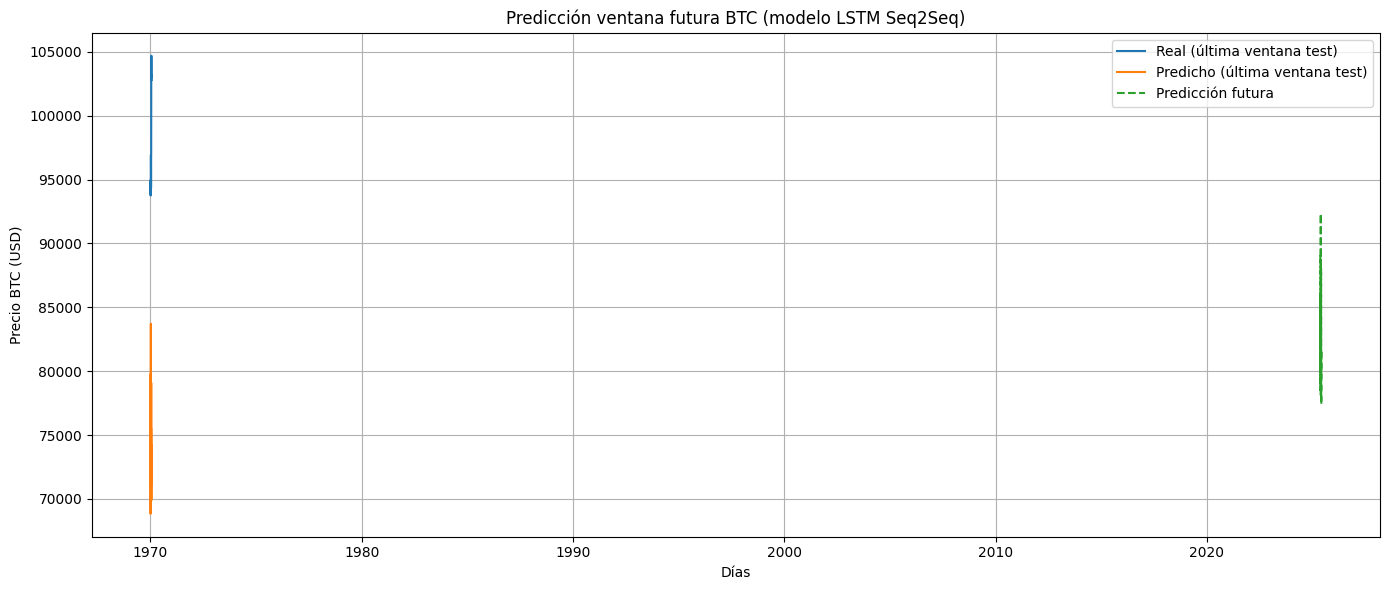

In [221]:


# 1. Preparar datos
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

# Escalar
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 2. Crear secuencias (lookback = 1 año) y ventanas futuras
def create_seq2seq_targets(data, lookback=252, horizon=20):
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X.append(data[i - lookback:i])
        y.append(data[i:i + horizon, 0])  # solo BTC
    return np.array(X), np.array(y)

lookback = 252
horizon = 20
X, y = create_seq2seq_targets(scaled_data, lookback, horizon)

# Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3. Modelo con optimización bayesiana
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        hp.Int("units1", 32, 128, step=32),
        return_sequences=True,
        input_shape=(X.shape[1], X.shape[2])
    ))
    if hp.Boolean("add_lstm2"):
        model.add(LSTM(hp.Int("units2", 32, 128, step=32)))
    else:
        model.add(LSTM(64))
    if hp.Boolean("dropout"):
        model.add(Dropout(hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))
    model.add(Dense(horizon))
    model.compile(optimizer="adam", loss="mse")
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=10,
    directory="lstm_tuning",
    project_name="btc_window_prediction"
)

es = EarlyStopping(patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, validation_split=0.2, epochs=5, callbacks=[es], verbose=0)

best_model = tuner.get_best_models(1)[0]

# Reentrenar
history = best_model.fit(X_train, y_train, epochs=25, batch_size=256, validation_split=0.2, callbacks=[es], verbose=1)

# 4. Predecir en test
y_pred = best_model.predict(X_test)

# 5. Inversión de escala
# y_test, y_pred → (n_samples, horizon)
n_samples = y_pred.shape[0]
y_pred_unscaled = []
y_test_unscaled = []

for i in range(n_samples):
    # rellenar para inverse_transform
    padded_pred = np.hstack([y_pred[i].reshape(-1, 1), np.zeros((horizon, df.shape[1] - 1))])
    padded_test = np.hstack([y_test[i].reshape(-1, 1), np.zeros((horizon, df.shape[1] - 1))])
    y_pred_unscaled.append(scaler.inverse_transform(padded_pred)[:, 0])
    y_test_unscaled.append(scaler.inverse_transform(padded_test)[:, 0])

y_pred_unscaled = np.array(y_pred_unscaled)
y_test_unscaled = np.array(y_test_unscaled)

# 6. Predicción futura (última secuencia)
last_seq = scaled_data[-lookback:]
current_seq = last_seq.reshape(1, lookback, df.shape[1])

future_preds = best_model.predict(current_seq)[0]  # (horizon, )

# Desescalar predicción futura
padded_future = np.hstack([future_preds.reshape(-1, 1), np.zeros((horizon, df.shape[1] - 1))])
future_unscaled = scaler.inverse_transform(padded_future)[:, 0]

# Fechas para graficar
last_date = combined_df["Date"].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon)

# 7. Graficar una muestra del test + predicción futura
plt.figure(figsize=(14, 6))
# Mostrar la última ventana de test real vs predicha
plt.plot(range(horizon), y_test_unscaled[-1], label="Real (última ventana test)")
plt.plot(range(horizon), y_pred_unscaled[-1], label="Predicho (última ventana test)")
# Predicción futura
plt.plot(future_dates, future_unscaled, "--", label="Predicción futura")

plt.title("Predicción ventana futura BTC (modelo LSTM Seq2Seq)")
plt.xlabel("Días")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Modelo LSTM Seq2Seq con Attention

15/15 [==============================] - 1s 9ms/step


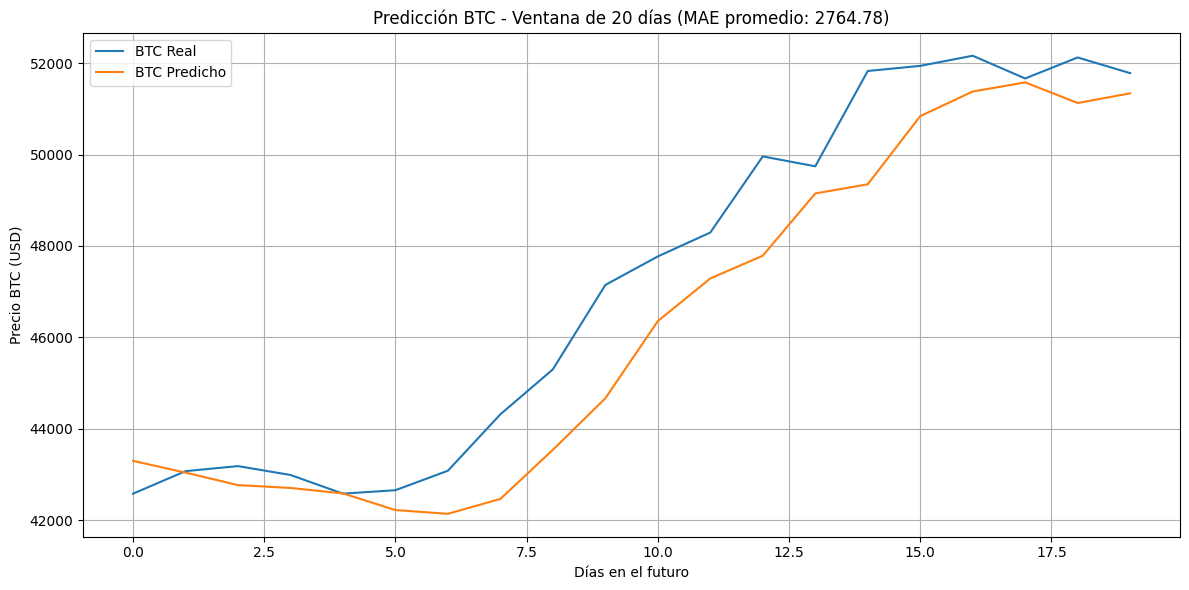

2764.7846593366808

In [356]:

from tensorflow.keras.layers import  Concatenate,Attention



df = combined_df
# Escalar datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["BTC", "NASDAQ"]])

# Crear secuencias para un modelo Seq2Seq con lookback
def create_seq2seq_data(data, lookback=60, horizon=7):
    X_enc, X_dec, y = [], [], []
    for i in range(lookback, len(data) - horizon):
        X_enc.append(data[i-lookback:i])
        X_dec.append(data[i-1:i+horizon-1])  # usar datos pasados como entrada del decoder
        y.append(data[i:i+horizon, 0])  # predicción de BTC
    return np.array(X_enc), np.array(X_dec), np.array(y)

lookback = 60
horizon = 20
X_enc, X_dec, y = create_seq2seq_data(scaled_data, lookback, horizon)

# Split
split = int(0.8 * len(X_enc))
X_enc_train, X_enc_test = X_enc[:split], X_enc[split:]
X_dec_train, X_dec_test = X_dec[:split], X_dec[split:]
y_train, y_test = y[:split], y[split:]

# Modelo Seq2Seq con atención
latent_dim = 64
encoder_inputs = Input(shape=(lookback, 2))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(horizon, 2))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

attention = Attention()([decoder_outputs, tf.expand_dims(encoder_outputs, 1)])
decoder_concat = Concatenate()([decoder_outputs, attention])
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_concat)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')

# Entrenar
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit([X_enc_train, X_dec_train], y_train[..., np.newaxis],
                    validation_split=0.1, epochs=50, batch_size=32,
                    callbacks=[es], verbose=0)

# Predecir
y_pred = model.predict([X_enc_test, X_dec_test])
y_pred = y_pred.squeeze()

# Desescalar
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_unscaled = scaler.inverse_transform(np.hstack([btc_scaled, np.zeros((len(btc_scaled), 1))]))[:, 0]

y_test_unscaled = []
y_pred_unscaled = []

for i in range(len(y_test)):
    y_block = np.hstack([y_test[i].reshape(-1, 1), np.zeros((horizon, 1))])
    y_pred_block = np.hstack([y_pred[i].reshape(-1, 1), np.zeros((horizon, 1))])
    y_test_unscaled.append(scaler.inverse_transform(y_block)[:, 0])
    y_pred_unscaled.append(scaler.inverse_transform(y_pred_block)[:, 0])

# MAE promedio por paso de tiempo
mae_per_timestep = np.mean([mean_absolute_error(y_true, y_pred)
                            for y_true, y_pred in zip(y_test_unscaled, y_pred_unscaled)])

# Plot ejemplo
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[0], label="BTC Real")
plt.plot(y_pred_unscaled[0], label="BTC Predicho")
plt.title(f"Predicción BTC - Ventana de {horizon} días (MAE promedio: {mae_per_timestep:.2f})")
plt.xlabel("Días en el futuro")
plt.ylabel("Precio BTC (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae_per_timestep


1/1 [==============================] - 0s 90ms/step


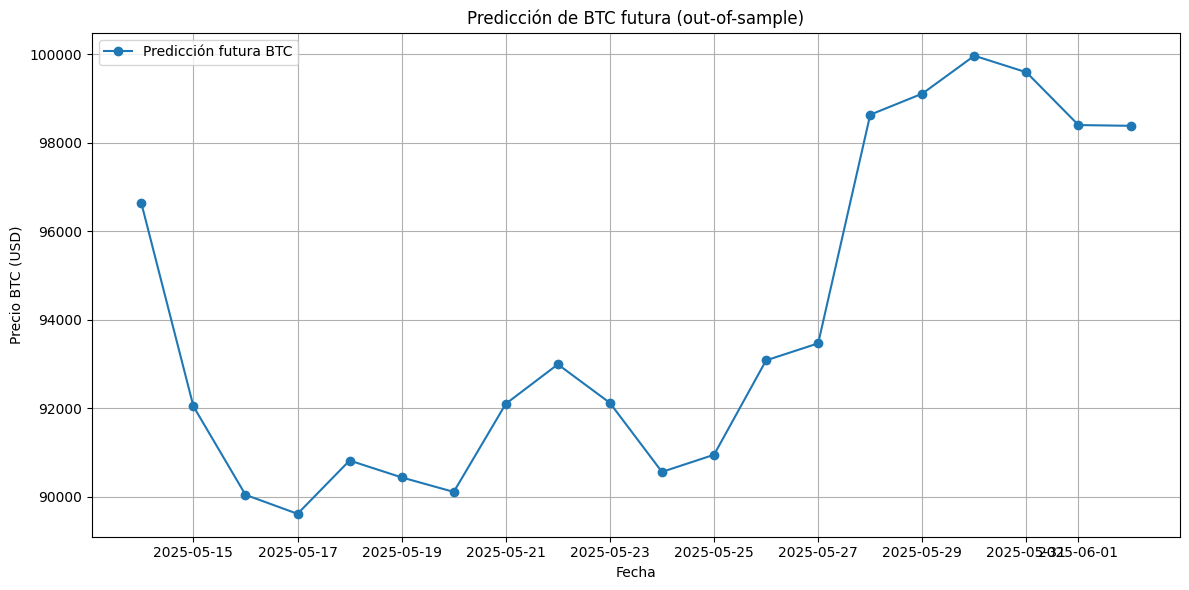

In [357]:
def predict_future_seq2seq(model, scaled_data, lookback, horizon, scaler):
    # Extraer las últimas secuencias
    encoder_input = scaled_data[-lookback:].reshape(1, lookback, 2)  # (1, lookback, 2)
    decoder_input = scaled_data[-horizon:].reshape(1, horizon, 2)   # (1, horizon, 2)

    # Predicción
    future_pred_scaled = model.predict([encoder_input, decoder_input])
    future_pred_scaled = future_pred_scaled.squeeze()  # (horizon,)

    # Desescalado solo del componente BTC
    future_pred = []
    for val in future_pred_scaled:
        row = scaler.inverse_transform([[val, 0]])[0][0]
        future_pred.append(row)

    # Establecer manualmente la última fecha del dataset
    last_date = pd.to_datetime("2025-05-13")
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon)

    return future_dates, np.array(future_pred)

# Ejecutar predicción
future_dates, future_btc_pred = predict_future_seq2seq(model, scaled_data, lookback, horizon, scaler)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_btc_pred, marker="o", label="Predicción futura BTC")
plt.title("Predicción de BTC futura (out-of-sample)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 25ms/step


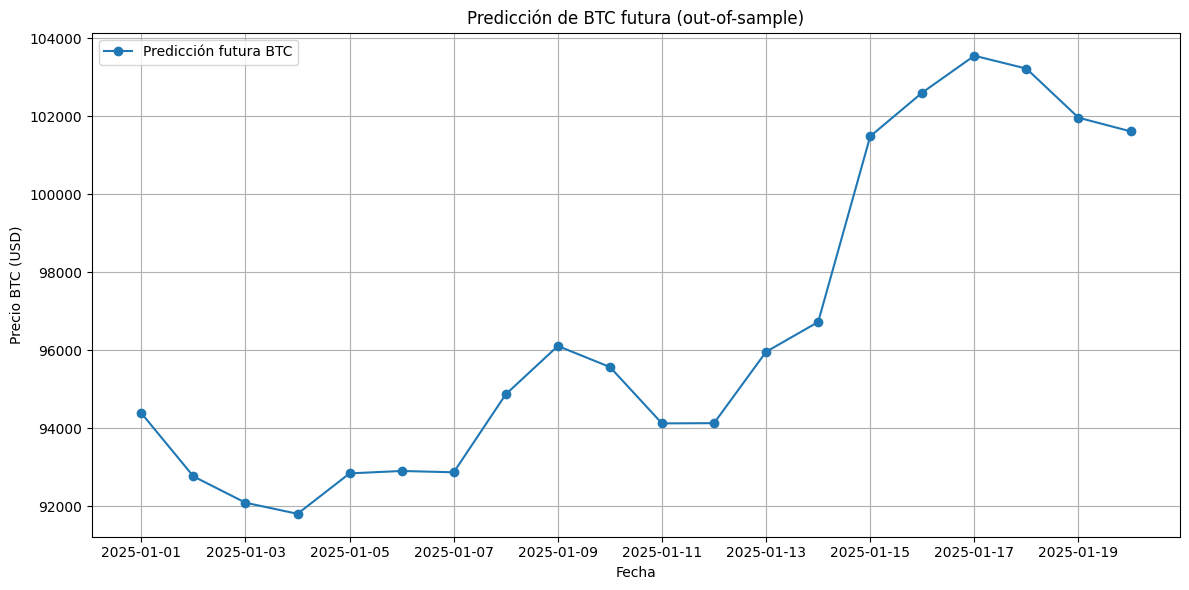

In [352]:
future_dates, future_btc_pred = predict_future_seq2seq(model, scaled_data, lookback, horizon, scaler)

plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_btc_pred, marker="o", label="Predicción futura BTC")
plt.title("Predicción de BTC futura (out-of-sample)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [354]:
combined_df.tail()


Date            BTC          DJIA          XAU        NASDAQ  \
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y    WTI  
2319  5659.910156  4.375  61.02  
2320  5659.910156  4.375  61.02  
2321  5659.910156  4.375  61.02  
2322  5659.910156  4.375  61.02  
2323  5659.910156  4.375  61.02

13/13 [==============================] - 2s 80ms/step
MAE multistep: 32356.3907
MSE multistep: 1243359351.9051


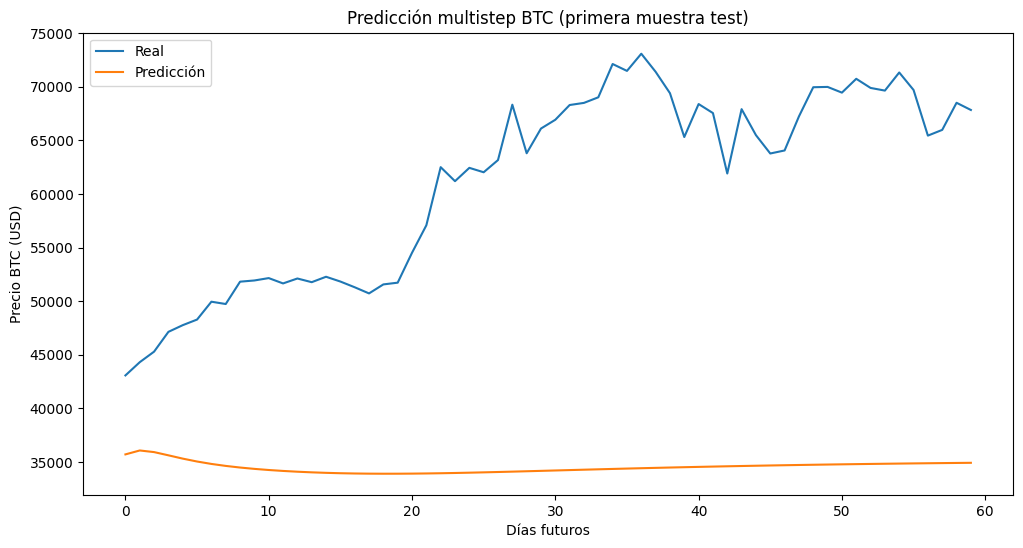

In [ ]:


from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam


# Supongamos que ya tenemos el DataFrame combinado
df = combined_df.drop(columns=["Date"]).copy()
df.dropna(inplace=True)

# Escalado
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Parámetros de secuencia
lookback = 252  # 1 año
forecast_horizon = 60  # Predicción de 60 días

# Crear secuencias para entrenamiento
def create_seq2seq_data(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(lookback, len(data) - forecast_horizon):
        X.append(data[i - lookback:i, :])
        y.append(data[i:i + forecast_horizon, 0])  # Solo BTC como target
    return np.array(X), np.array(y)

X, y = create_seq2seq_data(scaled_data, lookback, forecast_horizon)

# Separar en entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modelo Seq2Seq con atención
encoder_inputs = Input(shape=(lookback, X.shape[2]))
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = RepeatVector(forecast_horizon)(encoder_outputs)
decoder_lstm = LSTM(128, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

attention = Attention()([decoder_outputs, decoder_inputs])
decoder_concat_input = Concatenate()([decoder_outputs, attention])

decoder_dense = TimeDistributed(Dense(1))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train.reshape(*y_train.shape, 1), epochs=20, batch_size=32, validation_split=0.1, verbose=0)

# Predecir
y_pred = model.predict(X_test)
y_pred = y_pred.squeeze()

# Desescalar
btc_column_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_full_unscaled = scaler.inverse_transform(np.hstack([btc_column_scaled, np.zeros((len(btc_column_scaled), df.shape[1] - 1))]))[:, 0]

# Fechas
full_dates = pd.to_datetime(combined_df["Date"].values[lookback + forecast_horizon:])
test_dates = full_dates[split:]

# Reales y predichos desescalados
# Suponiendo que:
# y_pred.shape = (num_samples, forecast_horizon)
# df.shape[1] = número total de features

num_samples, forecast_horizon = y_pred.shape
num_features = df.shape[1]

# Aplanar y preparar matriz para desescalar
temp = np.zeros((num_samples * forecast_horizon, num_features))
temp[:, 0] = y_pred.flatten()  # colocar predicciones en la primera columna (BTC)

# Desescalar
temp_unscaled = scaler.inverse_transform(temp)

# Reconstruir array con forma (num_samples, forecast_horizon)
y_pred_unscaled = temp_unscaled[:, 0].reshape(num_samples, forecast_horizon)

# Preparar valores reales desescalados para test
# btc_full_unscaled debe contener solo la columna BTC ya desescalada
y_test_actual = np.array([
    btc_full_unscaled[i + lookback:i + lookback + forecast_horizon]
    for i in range(split, len(X))
])

# Calcular métricas para toda la ventana (multistep)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual.flatten(), y_pred_unscaled.flatten())
mse = mean_squared_error(y_test_actual.flatten(), y_pred_unscaled.flatten())

print(f"MAE multistep: {mae:.4f}")
print(f"MSE multistep: {mse:.4f}")

# Ahora puedes graficar. Ejemplo graficando la primera muestra del test:

plt.figure(figsize=(12,6))
plt.plot(y_test_actual[0], label="Real")
plt.plot(y_pred_unscaled[0], label="Predicción")
plt.title("Predicción multistep BTC (primera muestra test)")
plt.xlabel("Días futuros")
plt.ylabel("Precio BTC (USD)")
plt.legend()
plt.show()

# Para graficar todo el rango temporal (train + test) con predicciones,
# deberías juntar las series y ajustar las fechas correspondientes.



In [ ]:
#algo falla al predecir los siguientes instantes
#es posible que haya underfitting
#NO, el problema predice el día siguiente. Técnicamente está bien, pero no está bien ajustado.

In [ ]:
#para introducir señales anticipadas del sentimiento del mercado usaremos los mercados de futuros
#| Categoría          | Futuros útiles            |
#| ------------------ | ------------------------- |
#| Índices bursátiles | S\&P 500(ES=F), NASDAQ (NQ=F)  ,DOW (YM=F)  
#| Commodities        | Gold, Oil                 |
#| Divisas / Tipos    | DXY (DX-Y.NYB), US10Y                |
#| Criptomonedas      | BTC (CME)                 |


In [ ]:
#futuros: SP500, DOW, NASDAQ
#futuros de bonos del tesoro, Oro, y Cripto dan problemas

In [146]:
import yfinance as yf
import pandas as pd
from datetime import datetime

In [ ]:




#output_dir = "./fin_data"


# Diccionario de futuros a descargar
#tickers = {"SP500_Future": "ES=F", "NASDAQ_Future": "NQ=F","DOW_Future": "YM=F"}

# Fechas del periodo de estudio
#start_date = "2019-01-02"
#end_date = "2025-05-04"

# Descarga y guardado
#for name, symbol in tickers.items():
#   print(f"Descargando {name} ({symbol})...")
#    df = yf.download(symbol, start=start_date, end=end_date, interval="1d")
#    df.reset_index(inplace=True)  # Asegura que 'Date' sea columna
#    file_path = os.path.join(output_dir, f"{name}.csv")
#    df.to_csv(file_path, index=False)
#    print(f"Guardado en: {file_path}")

#print("✓ Todos los datos fueron descargados y guardados correctamente.")



Descargando SP500_Future (ES=F)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Guardado en: ./fin_data\SP500_Future.csv
Descargando NASDAQ_Future (NQ=F)...


[*********************100%***********************]  1 of 1 completed


Guardado en: ./fin_data\NASDAQ_Future.csv
Descargando DOW_Future (YM=F)...


[*********************100%***********************]  1 of 1 completed

Guardado en: ./fin_data\DOW_Future.csv
✓ Todos los datos fueron descargados y guardados correctamente.


In [149]:
SP500_F=pd.read_csv("./fin_data/SP500_Future.csv")
DOW_F=pd.read_csv("./fin_data/DOW_Future.csv")
NASDAQ_F=pd.read_csv("./fin_data/NASDAQ_Future.csv")

In [150]:
SP500_F

Date    Close     High      Low     Open   Volume
0            NaN     ES=F     ES=F     ES=F     ES=F     ES=F
1     2019-01-02   2511.0  2521.25  2452.25   2508.0  1969697
2     2019-01-03  2447.75   2493.5  2443.25  2482.25  2257341
3     2019-01-04  2531.25  2539.25   2438.5  2451.75  2350836
4     2019-01-07   2550.5   2567.5  2523.25  2537.25  1632131
...          ...      ...      ...      ...      ...      ...
1591  2025-04-28   5553.0  5578.75   5492.0   5544.0  1198801
1592  2025-04-29  5583.75  5597.25   5521.5   5543.0  1227182
1593  2025-04-30   5587.0  5626.25   5455.5   5579.5  1833646
1594  2025-05-01  5623.25   5682.5  5601.75   5617.5  1388619
1595  2025-05-02   5709.0  5724.75   5601.0   5608.5  1383367

[1596 rows x 6 columns]

In [152]:
DOW_F

Date    Close     High      Low     Open  Volume
0            NaN     YM=F     YM=F     YM=F     YM=F    YM=F
1     2019-01-02  23325.0  23417.0  22786.0  23320.0  315923
2     2019-01-03  22659.0  23123.0  22615.0  23065.0  346019
3     2019-01-04  23395.0  23504.0  22563.0  22708.0  320826
4     2019-01-07  23512.0  23668.0  23279.0  23470.0  238574
...          ...      ...      ...      ...      ...     ...
1591  2025-04-28  40368.0  40565.0  40012.0  40231.0   77484
1592  2025-04-29  40658.0  40775.0  40293.0  40332.0   83270
1593  2025-04-30  40770.0  40932.0  39867.0  40710.0  114915
1594  2025-05-01  40855.0  41222.0  40734.0  40841.0   78630
1595  2025-05-02  41427.0  41506.0  40766.0  40820.0   80975

[1596 rows x 6 columns]

In [153]:
NASDAQ_F

Date     Close      High       Low      Open  Volume
0            NaN      NQ=F      NQ=F      NQ=F      NQ=F    NQ=F
1     2019-01-02    6371.0   6409.25    6154.0    6349.5  659316
2     2019-01-03    6162.0   6304.25    6148.5   6242.75  714536
3     2019-01-04    6434.0    6462.0    6136.5   6168.75  696539
4     2019-01-07    6496.5   6535.75    6402.5   6451.25  516597
...          ...       ...       ...       ...       ...     ...
1591  2025-04-28   19528.0   19623.0  19257.25   19524.5  514474
1592  2025-04-29   19642.0   19688.5   19378.0  19478.25  565539
1593  2025-04-30   19658.5   19880.0  19103.75  19599.75  713642
1594  2025-05-01  19870.75  20125.75  19757.25   19834.0  588901
1595  2025-05-02  20195.25  20276.75   19749.5   19782.5  517806

[1596 rows x 6 columns]

In [ ]:


# 1. Eliminar primera fila redundante
SP500_F = SP500_F.iloc[1:].reset_index(drop=True)
DOW_F = DOW_F.iloc[1:].reset_index(drop=True)
NASDAQ_F = NASDAQ_F.iloc[1:].reset_index(drop=True)

# 2. Asegurar que 'Date' es tipo datetime
SP500_F["Date"] = pd.to_datetime(SP500_F["Date"])
DOW_F["Date"] = pd.to_datetime(DOW_F["Date"])
NASDAQ_F["Date"] = pd.to_datetime(NASDAQ_F["Date"])

# 3. Establecer fechas comunes como referencia
date_range = SP500_F["Date"]

# 4. Filtrar solo 'Close', renombrar columnas y reindexar con forward fill
def process(df, name):
    df = df[["Date", "Close"]].copy()
    df.rename(columns={"Close": name}, inplace=True)
    df = df.set_index("Date").reindex(date_range).ffill().reset_index()
    return df

SP500_F_processed = process(SP500_F, "SP500_F")
DOW_F_processed = process(DOW_F, "DOW_F")
NASDAQ_F_processed = process(NASDAQ_F, "NASDAQ_F")





# 5. Unirlos por la columna 'Date'
merged_futures = SP500_F_processed.merge(DOW_F_processed, on="Date").merge(NASDAQ_F_processed, on="Date")

# Resultado
print(merged_futures.head())


        Date  SP500_F    DOW_F NASDAQ_F
0 2019-01-02   2511.0  23325.0   6371.0
1 2019-01-03  2447.75  22659.0   6162.0
2 2019-01-04  2531.25  23395.0   6434.0
3 2019-01-07   2550.5  23512.0   6496.5
4 2019-01-08   2572.5  23743.0  6557.25


In [156]:
merged_futures

Date  SP500_F    DOW_F  NASDAQ_F
0    2019-01-02   2511.0  23325.0    6371.0
1    2019-01-03  2447.75  22659.0    6162.0
2    2019-01-04  2531.25  23395.0    6434.0
3    2019-01-07   2550.5  23512.0    6496.5
4    2019-01-08   2572.5  23743.0   6557.25
...         ...      ...      ...       ...
1590 2025-04-28   5553.0  40368.0   19528.0
1591 2025-04-29  5583.75  40658.0   19642.0
1592 2025-04-30   5587.0  40770.0   19658.5
1593 2025-05-01  5623.25  40855.0  19870.75
1594 2025-05-02   5709.0  41427.0  20195.25

[1595 rows x 4 columns]

In [161]:
# Convertir columnas numéricas de merged_futures a float
for col in ["SP500_F", "DOW_F", "NASDAQ_F"]:
    merged_futures[col] = pd.to_numeric(merged_futures[col])


In [162]:
# 1. Asegurar que las fechas son datetime en ambos DataFrames
combined_df["Date"] = pd.to_datetime(combined_df["Date"])
merged_futures["Date"] = pd.to_datetime(merged_futures["Date"])

# 2. Unir por la columna 'Date'
combined_df_extended = pd.merge(combined_df, merged_futures, on="Date", how="left")



# 3. Imputar valores faltantes si los hubiera tras la fusión (forward fill)
combined_df_extended.ffill(inplace=True)

# 4. Resultado
print(combined_df_extended.head())


        Date          BTC          DJIA          XAU       NASDAQ  \
0 2019-01-02  3943.409424  23346.240234  1281.000000  6665.939941   
1 2019-01-03  3836.741211  22686.220703  1291.800049  6463.500000   
2 2019-01-04  3857.717529  23433.160156  1282.699951  6738.859863   
3 2019-01-05  3845.194580  23433.160156  1282.699951  6738.859863   
4 2019-01-06  4076.632568  23433.160156  1282.699951  6738.859863   

         SP500  US10Y        WTI  SP500_F    DOW_F  NASDAQ_F  
0  2510.030029  2.661  46.540001  2511.00  23325.0    6371.0  
1  2447.889893  2.554  47.090000  2447.75  22659.0    6162.0  
2  2531.939941  2.659  47.959999  2531.25  23395.0    6434.0  
3  2531.939941  2.659  47.959999  2531.25  23395.0    6434.0  
4  2531.939941  2.659  47.959999  2531.25  23395.0    6434.0  


In [163]:
#dataframe original + adición de datos de futuros
combined_df_extended

Date            BTC          DJIA          XAU        NASDAQ  \
0    2019-01-02    3943.409424  23346.240234  1281.000000   6665.939941   
1    2019-01-03    3836.741211  22686.220703  1291.800049   6463.500000   
2    2019-01-04    3857.717529  23433.160156  1282.699951   6738.859863   
3    2019-01-05    3845.194580  23433.160156  1282.699951   6738.859863   
4    2019-01-06    4076.632568  23433.160156  1282.699951   6738.859863   
...         ...            ...           ...          ...           ...   
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y        WTI  SP500_F    DOW_F  NASDAQ_F  
0     2510.030029  2.661  46.540001  2511.00  23325.0   6371.00  
1     2447.889893  2.554  47.090000  2447.75  22659.0   6162.00  
2     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
3     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
4     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
...           ...    ...        ...      ...      ...       ...  
2319  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2320  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2321  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2322  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2323  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  

[2324 rows x 11 columns]

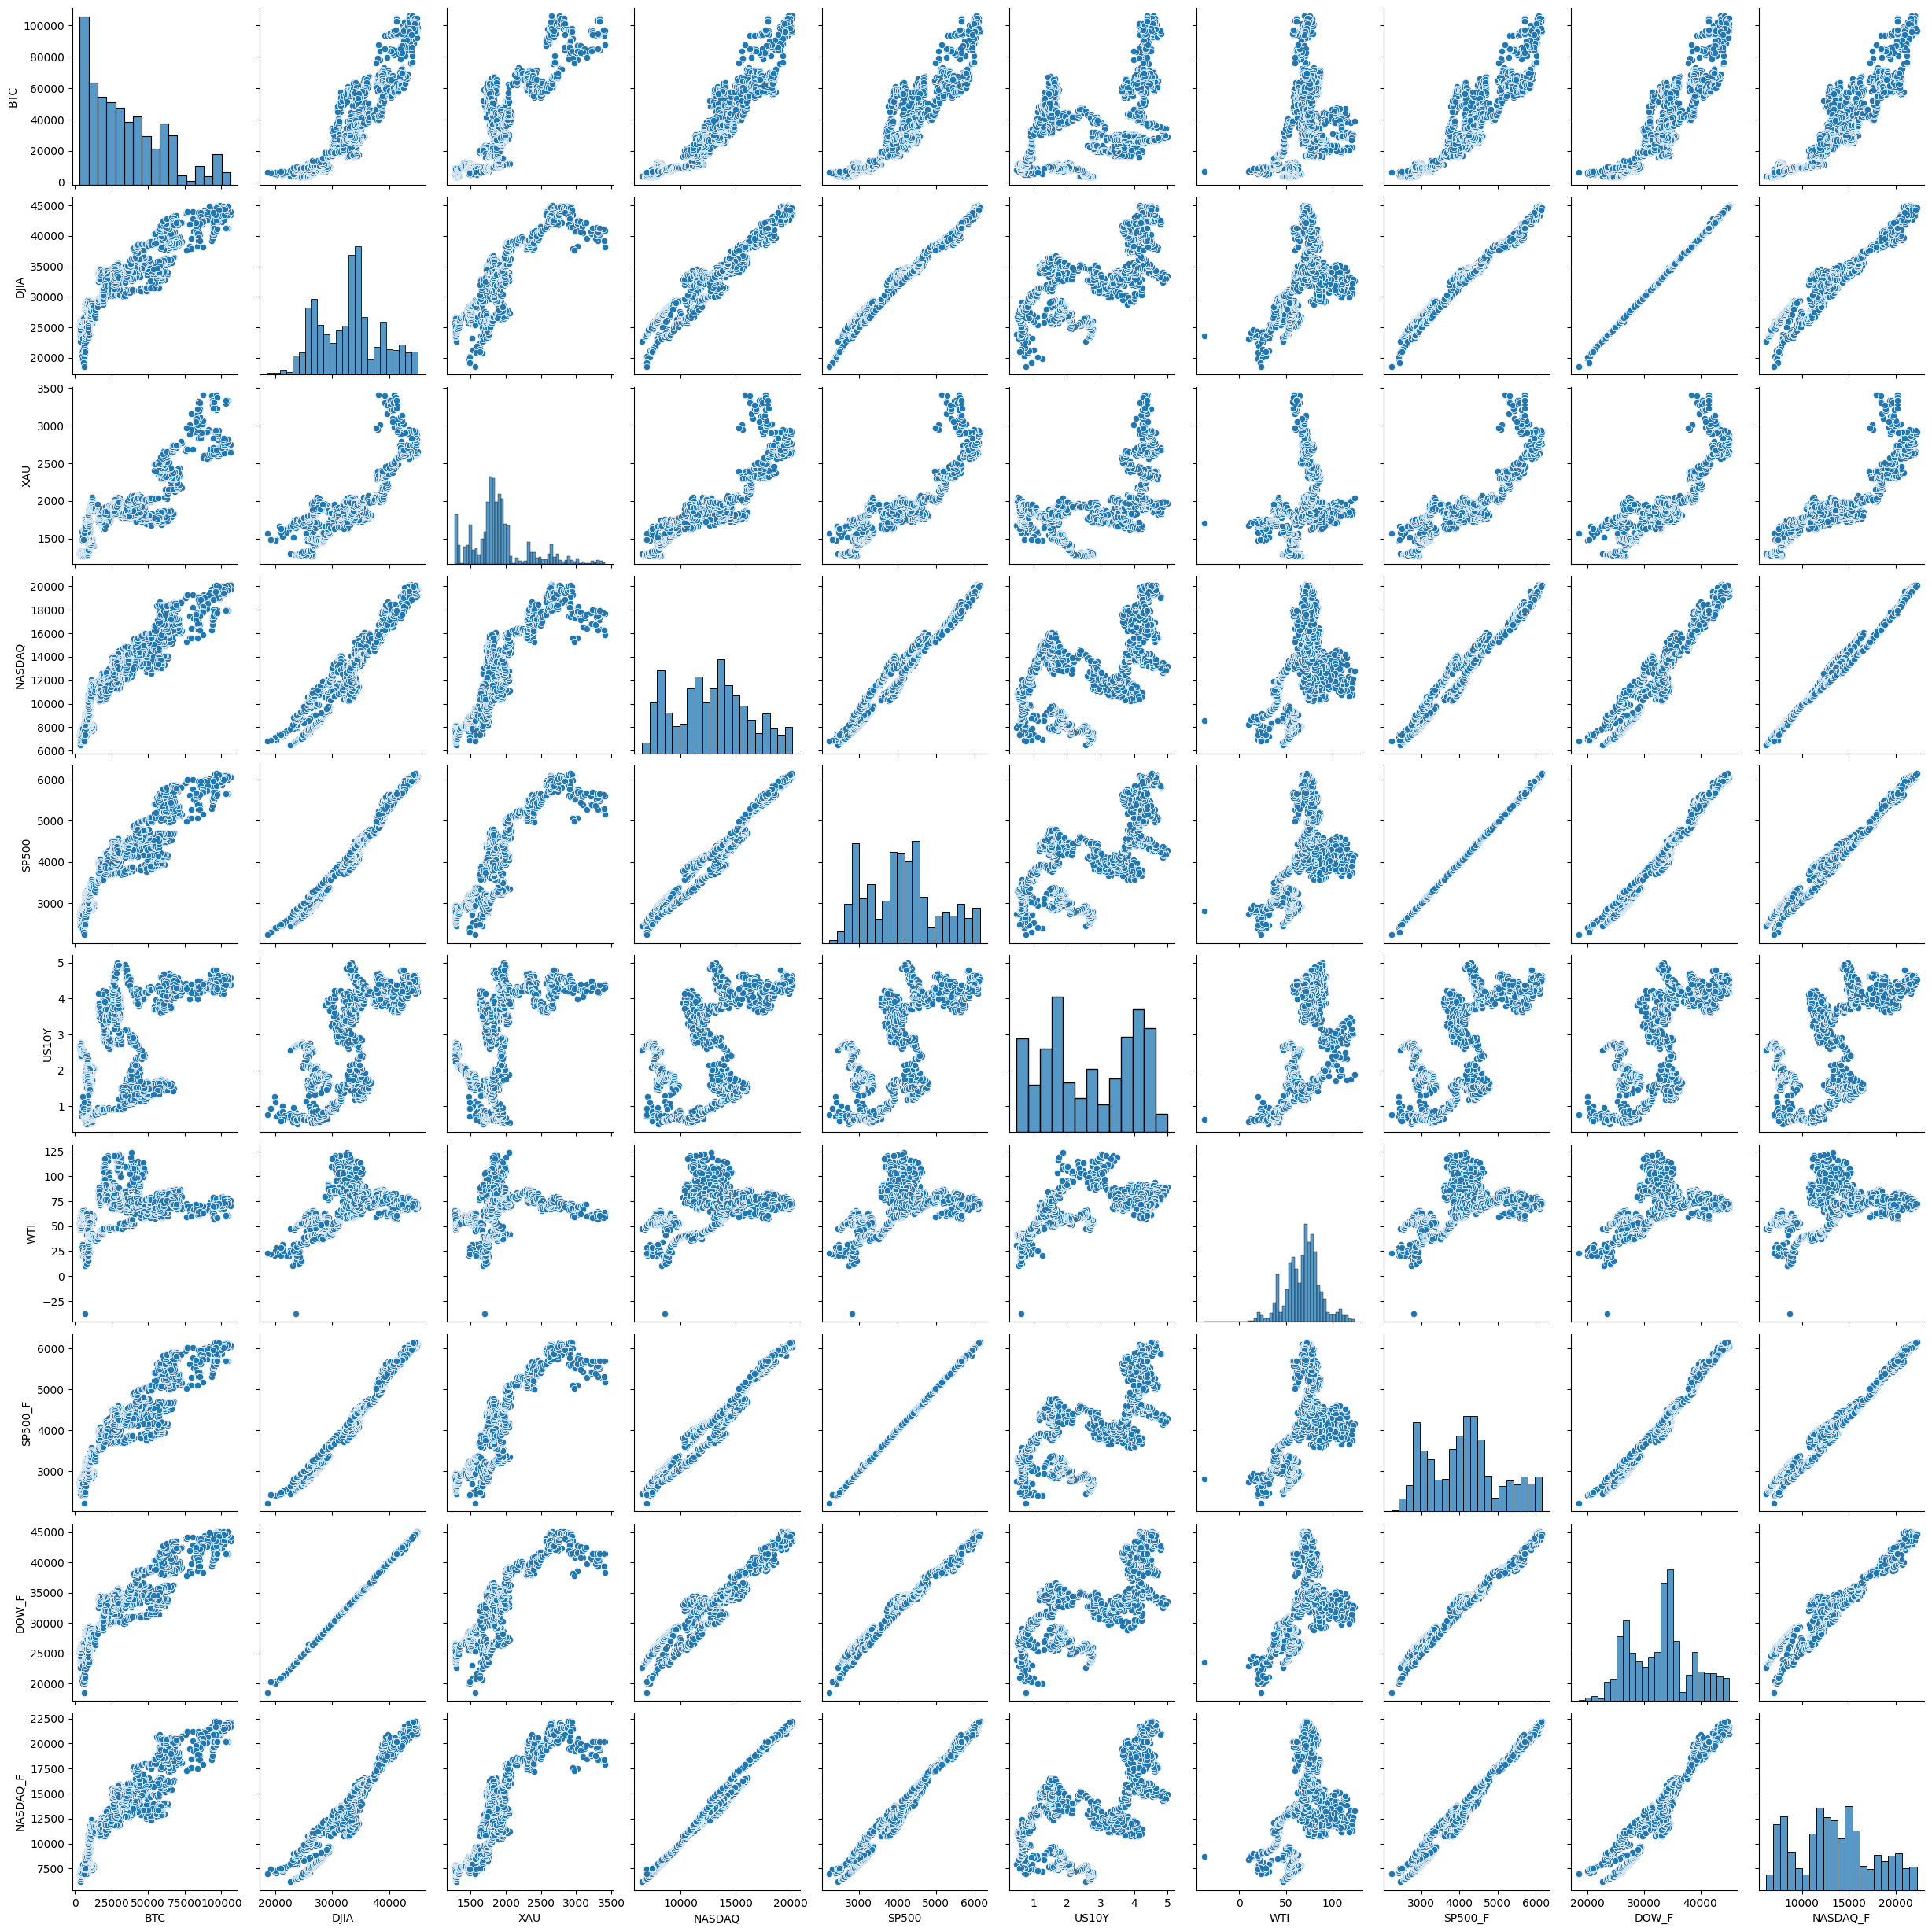

In [164]:
sns.pairplot(data=combined_df_extended)

<Axes: >

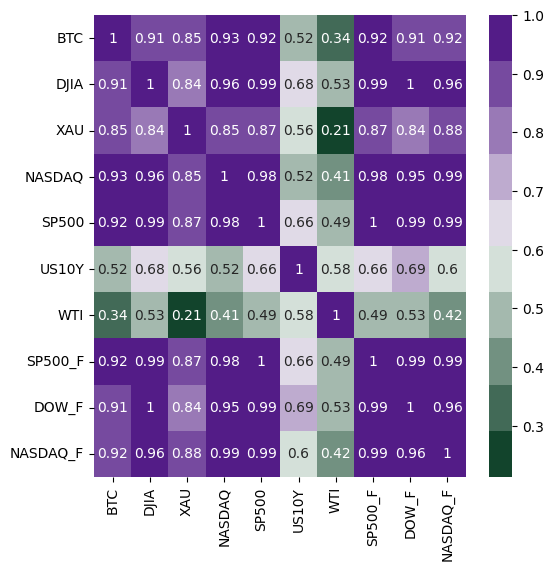

In [167]:
sns.heatmap(data=combined_df_extended.iloc[:,1:].corr(),annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
)

In [ ]:
#parece que hay aun más colinealidad

In [ ]:
#modelo LSTM con más features

In [170]:


# Asegurar que no hay NaNs
df = combined_df_extended.copy()
df.dropna(inplace=True)

# Guardar fechas para futuras predicciones
dates = df["Date"].reset_index(drop=True)

# Eliminar columna 'Date' para escalar
df_features = df.drop(columns=["Date"])

# Escalado
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_features)

# Crear secuencias
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, :])
        y.append(data[i, 0])  # Predecimos columna 0 = BTC
    return np.array(X), np.array(y)

lookback = 60  # Usamos 60 días de historial (2 meses)
X, y = create_sequences(scaled_data, lookback)


In [171]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [173]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(32, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=320,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)


Epoch 1/20
5/5 [==============================] - 3s 209ms/step - loss: 0.0125 - val_loss: 0.0100
Epoch 2/20
5/5 [==============================] - 0s 72ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 3/20
5/5 [==============================] - 0s 73ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 4/20
5/5 [==============================] - 0s 72ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/20
5/5 [==============================] - 0s 71ms/step - loss: 0.0019 - val_loss: 8.1165e-04
Epoch 6/20
5/5 [==============================] - 0s 71ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/20
5/5 [==============================] - 0s 70ms/step - loss: 0.0013 - val_loss: 8.1763e-04
Epoch 8/20
5/5 [==============================] - 0s 72ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 9/20
5/5 [==============================] - 0s 71ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/20
5/5 [==============================] - 0s 71ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 11/20
5/5 [===

In [174]:
y_pred = model.predict(X_test)

# Reconstruir precios originales
btc_scaled = scaled_data[:, 0].reshape(-1, 1)
btc_unscaled = scaler.inverse_transform(
    np.hstack([btc_scaled, np.zeros((len(btc_scaled), df_features.shape[1] - 1))])
)[:, 0]

y_test_unscaled = btc_unscaled[lookback + split:]
y_pred_unscaled = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((len(y_pred), df_features.shape[1] - 1))])
)[:, 0]

# Evaluación
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")


15/15 [==============================] - 1s 7ms/step
MSE: 305825675.04, MAE: 14804.52


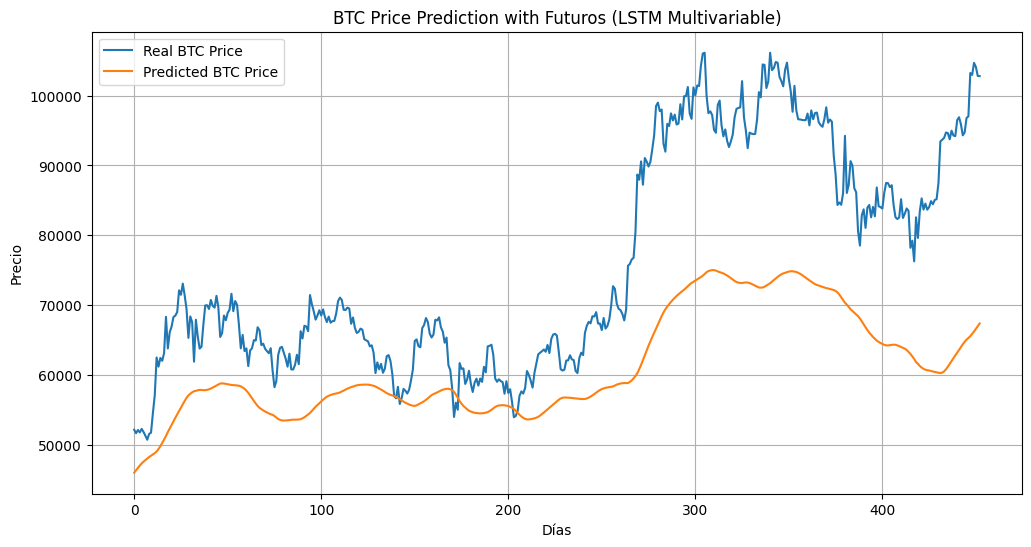

In [175]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled, label="Real BTC Price")
plt.plot(y_pred_unscaled, label="Predicted BTC Price")
plt.title("BTC Price Prediction with Futuros (LSTM Multivariable)")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#modelo LSTM con 1 sola feature

Epoch 1/15
4/4 [==============================] - 5s 789ms/step - loss: 0.0625 - val_loss: 0.0275
Epoch 2/15
4/4 [==============================] - 2s 595ms/step - loss: 0.0144 - val_loss: 0.0203
Epoch 3/15
4/4 [==============================] - 2s 599ms/step - loss: 0.0187 - val_loss: 0.0114
Epoch 4/15
4/4 [==============================] - 2s 610ms/step - loss: 0.0108 - val_loss: 0.0136
Epoch 5/15
4/4 [==============================] - 2s 612ms/step - loss: 0.0118 - val_loss: 0.0174
Epoch 6/15
4/4 [==============================] - 2s 603ms/step - loss: 0.0119 - val_loss: 0.0139
Epoch 7/15
4/4 [==============================] - 2s 595ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 8/15
4/4 [==============================] - 2s 603ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 9/15
4/4 [==============================] - 2s 594ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 10/15
4/4 [==============================] - 2s 602ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 11/15
4/4 [==

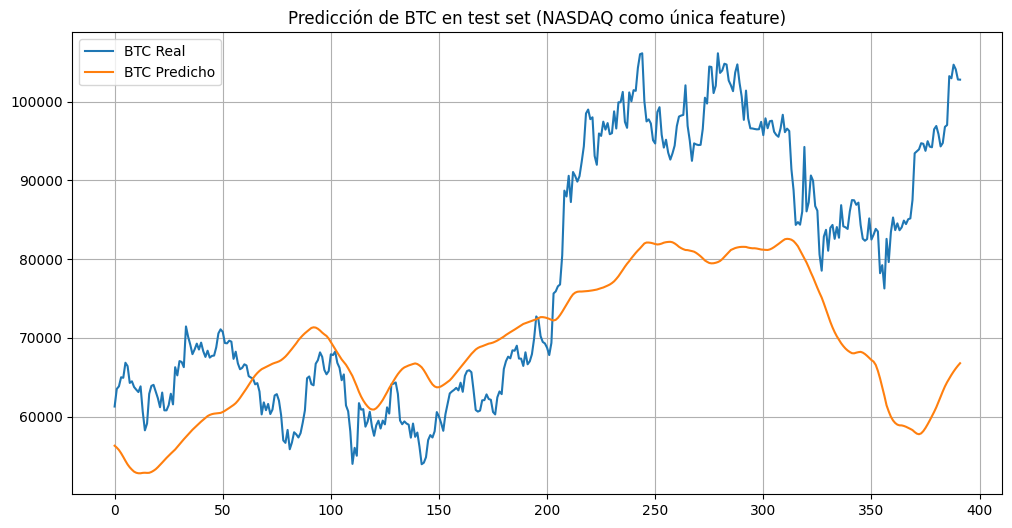

1/1 [==============================] - 0s 33ms/step


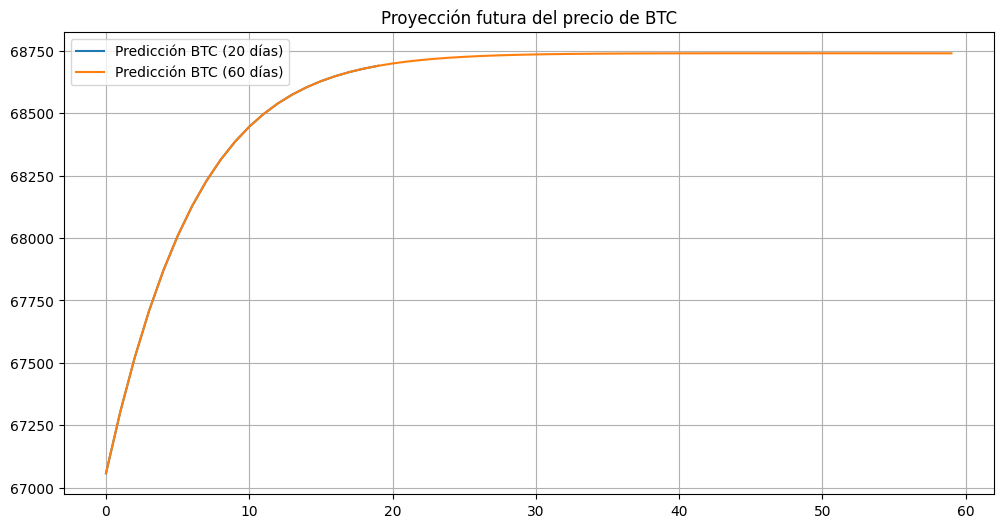

In [185]:





# ---------- 1. Preparar los datos ----------
# Supone que 'combined_df' contiene columnas: 'Date', 'BTC', 'NASDAQ_F'
df = combined_df[['Date', 'BTC', 'NASDAQ']].copy()
df.dropna(inplace=True)

# Escalar NASDAQ y BTC por separado
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['BTC', 'NASDAQ']])

# ---------- 2. Crear secuencias ----------
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 1].reshape(-1, 1))  # NASDAQ_F como input
        y.append(data[i, 0])  # BTC como objetivo
    return np.array(X), np.array(y)

lookback = 365
X, y = create_sequences(scaled_data, lookback)

# ---------- 3. División entrenamiento / test ----------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------- 4. Modelo LSTM multicapas ----------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(32, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(patience=10, restore_best_weights=True)

# ---------- 5. Entrenamiento ----------
history = model.fit(X_train, y_train, epochs=15, batch_size=320,
                    validation_split=0.2, callbacks=[es], verbose=1)

# ---------- 6. Predicción en test ----------
y_pred = model.predict(X_test)

# Inversión de escala para BTC
def inverse_btc(scaled_vals):
    temp = np.zeros((len(scaled_vals), 2))
    temp[:, 0] = scaled_vals.flatten()
    return scaler.inverse_transform(temp)[:, 0]

y_test_unscaled = inverse_btc(y_test)
y_pred_unscaled = inverse_btc(y_pred)

# ---------- 7. Visualización ----------
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='BTC Real')
plt.plot(y_pred_unscaled, label='BTC Predicho')
plt.title("Predicción de BTC en test set (NASDAQ como única feature)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 8. Proyección futura ----------
def forecast_future(model, last_window, n_days):
    future = []
    input_seq = last_window.copy()
    
    for _ in range(n_days):
        pred = model.predict(input_seq[np.newaxis, :, :])[0, 0]
        future.append(pred)
        
        next_input = np.append(input_seq[1:], [[input_seq[-1][0]]], axis=0)
        input_seq = next_input
    
    return inverse_btc(np.array(future))

last_nasdaq_scaled = scaled_data[-lookback:, 1].reshape(-1, 1)
future_20 = forecast_future(model, last_nasdaq_scaled, 20)
future_60 = forecast_future(model, last_nasdaq_scaled, 60)

# ---------- 9. Visualización de la proyección ----------
plt.figure(figsize=(12, 6))
plt.plot(future_20, label="Predicción BTC (20 días)")
plt.plot(future_60, label="Predicción BTC (60 días)")
plt.title("Proyección futura del precio de BTC")
plt.legend()
plt.grid(True)
plt.show()






14/14 [==============================] - 1s 8ms/step


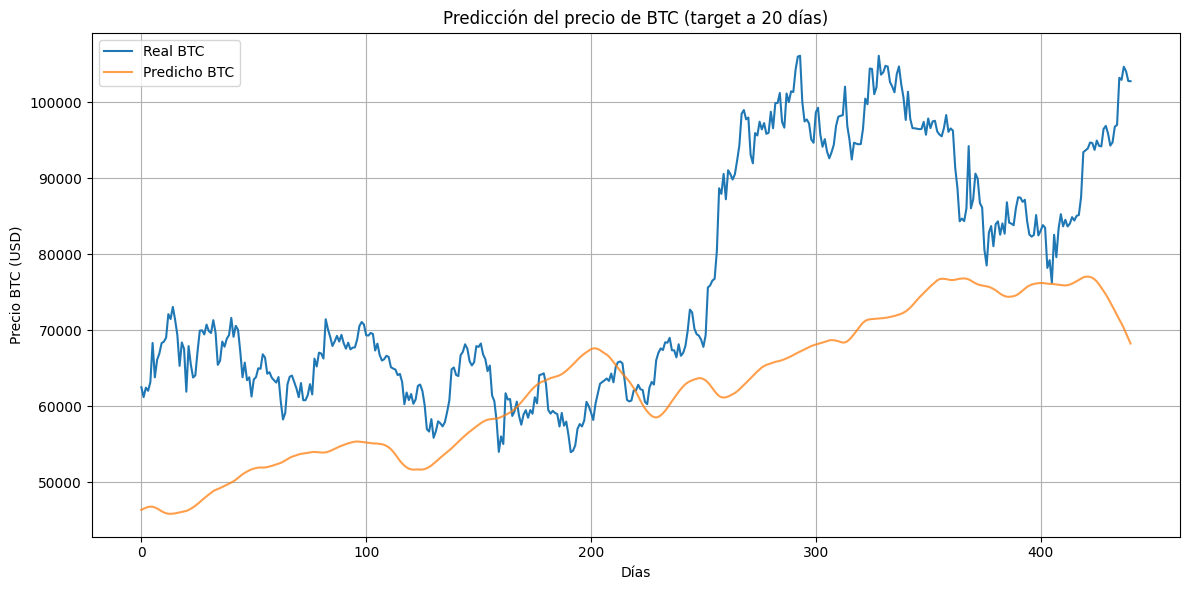

(322518935.51377296, 14969.935763888889)

In [189]:

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


dates = pd.date_range(start="2019-01-01", periods=1500)

df = combined_df[['Date', 'BTC', 'NASDAQ']].copy()
df.dropna(inplace=True)


# 1. Desplazar el objetivo hacia el futuro (predicción a 20 días)
lookahead = 60
df['BTC_target'] = df['BTC'].shift(-lookahead)
df.dropna(inplace=True)

# 2. Normalizar las características
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['NASDAQ']])
scaled_target = scaler.fit_transform(df[['BTC_target']])

# 3. Crear secuencias
lookback = 60

def create_sequences(features, target, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target, lookback)

# 4. Separar en entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Construir el modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Entrenamiento
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=320, validation_split=0.2, callbacks=[es], verbose=0)

# 7. Predicción
y_pred = model.predict(X_test)

# 8. Invertir escala
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 9. Evaluación
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

# 10. Graficar
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Real BTC')
plt.plot(y_pred_inv, label='Predicho BTC', alpha=0.75)
plt.title("Predicción del precio de BTC (target a 20 días)")
plt.legend()
plt.xlabel("Días")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

mse, mae


In [ ]:
#modelo LSTM que incluye RSI y EMA

Epoch 1/50
6/6 [==============================] - 3s 162ms/step - loss: 0.0240 - val_loss: 0.0044
Epoch 2/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 3/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 4/50
6/6 [==============================] - 0s 41ms/step - loss: 0.0022 - val_loss: 5.5557e-04
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0012 - val_loss: 9.4662e-04
Epoch 6/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 2.9838e-04
Epoch 7/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 3.8695e-04
Epoch 8/50
6/6 [==============================] - 0s 30ms/step - loss: 9.0599e-04 - val_loss: 3.3510e-04
Epoch 9/50
6/6 [==============================] - 0s 32ms/step - loss: 8.2735e-04 - val_loss: 2.7835e-04
Epoch 10/50
6/6 [==============================] - 0s 30ms/step - loss: 8.0144e-04 - val_loss:

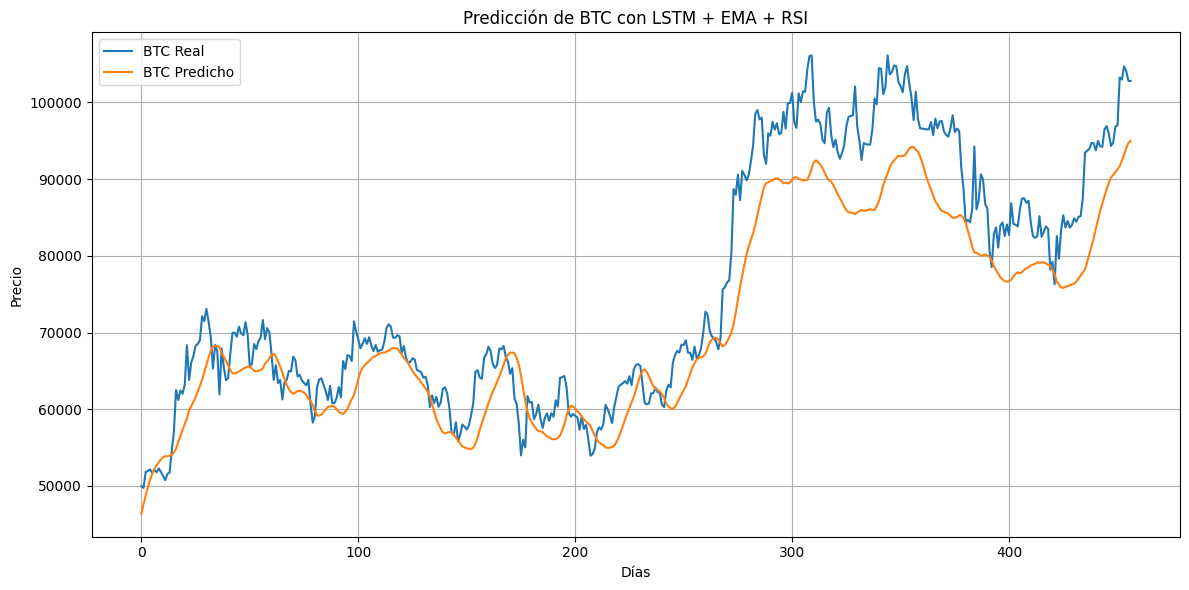

In [216]:
#ema period=20
#rsi=20
#lookback=20



df = combined_df_extended.copy()

# Calcular indicadores técnicos
def compute_technical_indicators(df, price_col='BTC', ema_period=14, rsi_period=14):
    df['EMA'] = df[price_col].ewm(span=ema_period, adjust=False).mean()
    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

df = compute_technical_indicators(df,ema_period=20,rsi_period=20)
df.dropna(inplace=True)

# Escalado
features = ['BTC', 'EMA', 'RSI']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Secuencias para LSTM
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 20
X, y = create_sequences(scaled_data, lookback)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modelo LSTM multivariable
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(patience=10, restore_best_weights=True)

# Entrenamiento
model.fit(X_train, y_train, epochs=50  , batch_size=320, validation_split=0.1, callbacks=[es], verbose=1)

# Predicción
y_pred = model.predict(X_test)

# Inversión de escalado
pad_pred = np.hstack([y_pred, np.zeros((len(y_pred), 2))])
pad_test = np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), 2))])
y_pred_unscaled = scaler.inverse_transform(pad_pred)[:, 0]
y_test_unscaled = scaler.inverse_transform(pad_test)[:, 0]

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='BTC Real')
plt.plot(y_pred_unscaled, label='BTC Predicho')
plt.title('Predicción de BTC con LSTM + EMA + RSI')
plt.xlabel('Días')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/100
43/43 [==============================] - 4s 30ms/step - loss: 0.0128 - val_loss: 7.5953e-04
Epoch 2/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 4.8866e-04
Epoch 3/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 4.5048e-04
Epoch 4/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 5.3427e-04
Epoch 5/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 6.3322e-04
Epoch 6/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 4.6340e-04
Epoch 7/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0016 - val_loss: 7.1261e-04
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 7.4152e-04
Epoch 9/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 4.5000e-04
Epoch 10/100
43/43 [==============================] - 1s 17ms/st

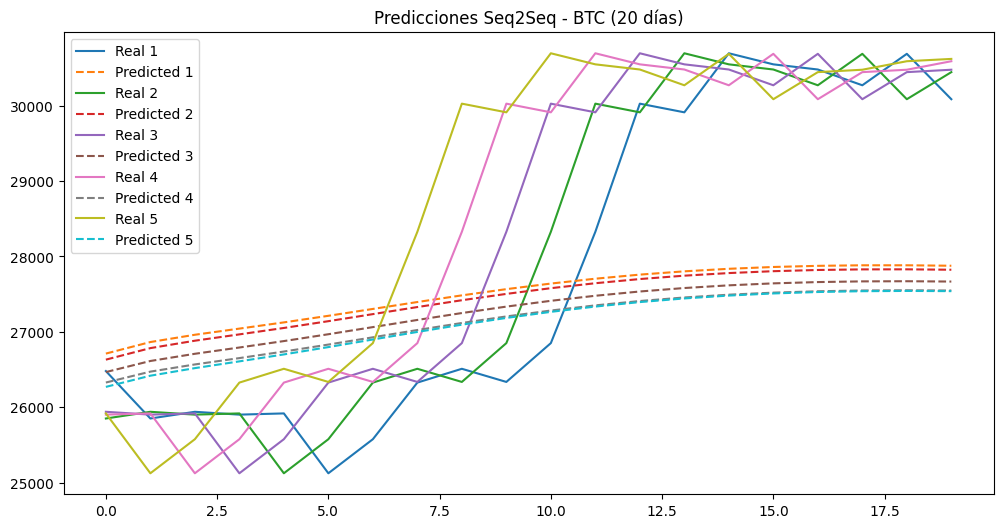

In [217]:

from tensorflow.keras.models import Model



# 1. Preparar los datos
features = ['BTC', 'NASDAQ']
df = combined_df_extended[features].copy()
df.dropna(inplace=True)

# Escalar los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=features)

# 2. Crear secuencias para Seq2Seq
def create_seq2seq_data(data, lookback=60, forecast_horizon=20):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon, 0])  # solo BTC como target
    return np.array(X), np.array(y)

lookback = 20
forecast_horizon = 20
X, y = create_seq2seq_data(scaled_data, lookback, forecast_horizon)

# 3. Dividir en train/test
split = int(len(X) * 0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Definir modelo Seq2Seq
encoder_inputs = Input(shape=(lookback, X.shape[2]))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(forecast_horizon, 1))
decoder_lstm = LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')

# 5. Preparar decoder inputs (cero + teacher forcing)
decoder_input_data = np.zeros((y_train.shape[0], forecast_horizon, 1))
decoder_input_test = np.zeros((y_test.shape[0], forecast_horizon, 1))

# 6. Entrenar modelo
es = EarlyStopping(patience=10, restore_best_weights=True)
model.fit([X_train, decoder_input_data], y_train.reshape((-1, forecast_horizon, 1)),
          validation_split=0.15, epochs=100, batch_size=32, callbacks=[es], verbose=1)

# 7. Predecir
y_pred_scaled = model.predict([X_test, decoder_input_test])

# Invertir escala
y_pred = []
y_real = []
for i in range(len(y_pred_scaled)):
    temp = np.zeros((forecast_horizon, len(features)))
    temp[:, 0] = y_pred_scaled[i].flatten()
    y_pred.append(scaler.inverse_transform(temp)[:, 0])

    temp_y = np.zeros((forecast_horizon, len(features)))
    temp_y[:, 0] = y_test[i].flatten()
    y_real.append(scaler.inverse_transform(temp_y)[:, 0])

# 8. Graficar algunos resultados
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(y_real[i], label=f'Real {i+1}')
    plt.plot(y_pred[i], linestyle='--', label=f'Predicted {i+1}')
plt.title('Predicciones Seq2Seq - BTC (20 días)')
plt.legend()
plt.show()


In [ ]:
#modelo GRU

In [235]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Attention
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Suponiendo que ya tienes X_train, y_train, X_test, y_test preparados ---
# X_train.shape = (num_train_samples, lookback, num_features)
# y_train.shape = (num_train_samples, forecast_horizon)

# Supongamos que y_train tiene shape (samples, forecast_horizon)

# 1. Expandir y_train para que sea 3D (samples, forecast_horizon, 1)
y_train_expanded = y_train[..., np.newaxis]  # Añade la dimensión de features

# 2. Crear decoder_input_data con la misma forma que y_train_expanded (zeros)
decoder_input_data = np.zeros_like(y_train_expanded)

# 3. Rellenar decoder_input_data desplazando y_train_expanded una posición hacia adelante
decoder_input_data[:, 1:, 0] = y_train[:, :-1]

# 4. El primer valor de cada secuencia es cero (start token)
decoder_input_data[:, 0, 0] = 0


# Parámetros
lookback = X_train.shape[1]
num_features = X_train.shape[2]
forecast_horizon = y_train.shape[1]

# Encoder
encoder_inputs = Input(shape=(lookback, num_features))
encoder_gru = GRU(64, return_sequences=True, return_state=True)
encoder_outputs, encoder_state = encoder_gru(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(forecast_horizon, 1))  # en inferencia se usa teacher forcing o zeros
decoder_gru = GRU(64, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Attention
attention = Attention()
attention_out = attention([decoder_outputs, encoder_outputs])

# Concatenar atención con salida decoder
from tensorflow.keras.layers import Concatenate, TimeDistributed

decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_out])

# Capa densa para predecir
decoder_dense = TimeDistributed(Dense(1))
decoder_pred = decoder_dense(decoder_concat_input)

# Modelo entrenamiento (teacher forcing)
model = Model([encoder_inputs, decoder_inputs], decoder_pred)
model.compile(optimizer='adam', loss='mse')

model.summary()

# --- Preparar decoder_inputs para entrenamiento (teacher forcing) ---
# Para entrenamiento: decoder_inputs son y_train desplazados una posición, con un cero al inicio
decoder_input_data = np.zeros_like(y_train)
decoder_input_data[:, 1:, 0] = y_train[:, :-1]
decoder_input_data[:, 0, 0] = 0  # primer valor 0

# Entrenamiento
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    [X_train, decoder_input_data], y_train[..., np.newaxis],
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# --- Inferencia ---
# Definir modelos encoder e inferencia decoder para predecir ventanas futuras

# Encoder modelo para inferencia
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_state])

# Decoder modelo para inferencia
decoder_state_input = Input(shape=(64,))
encoder_outputs_input = Input(shape=(lookback, 64))

decoder_outputs_inf, decoder_state_inf = decoder_gru(
    decoder_inputs, initial_state=decoder_state_input
)
attention_inf = attention([decoder_outputs_inf, encoder_outputs_input])
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_inf])
decoder_pred_inf = decoder_dense(decoder_concat_inf)

decoder_model = Model(
    [decoder_inputs, decoder_state_input, encoder_outputs_input],
    [decoder_pred_inf, decoder_state_inf]
)

# Función para predecir multistep sin teacher forcing
def predict_seq2seq_gru(encoder_input_seq, forecast_horizon):
    encoder_outs, state = encoder_model.predict(encoder_input_seq)
    target_seq = np.zeros((encoder_input_seq.shape[0], 1, 1))
    preds = []

    for _ in range(forecast_horizon):
        pred, state = decoder_model.predict([target_seq, state, encoder_outs])
        preds.append(pred[:, 0, 0])
        target_seq = pred

    return np.array(preds).T  # shape (batch_size, forecast_horizon)

# Predecir para test
y_pred = predict_seq2seq_gru(X_test, forecast_horizon)

# --- Desescalar predicciones y datos reales (igual que antes) ---
num_samples, forecast_horizon = y_pred.shape
temp = np.zeros((num_samples * forecast_horizon, num_features))
temp[:, 0] = y_pred.flatten()
y_pred_unscaled = scaler.inverse_transform(temp)[:, 0].reshape(num_samples, forecast_horizon)

y_test_actual = np.array([
    btc_full_unscaled[i + lookback:i + lookback + forecast_horizon]
    for i in range(split, len(X))
])

# Métricas
mae = mean_absolute_error(y_test_actual.flatten(), y_pred_unscaled.flatten())
mse = mean_squared_error(y_test_actual.flatten(), y_pred_unscaled.flatten())

print(f"MAE multistep GRU: {mae:.4f}")
print(f"MSE multistep GRU: {mse:.4f}")

# Gráfica ejemplo primera muestra test
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[0], label='Real')
plt.plot(y_pred_unscaled[0], label='Predicción GRU')
plt.title('Predicción GRU multistep BTC (primera muestra test)')
plt.xlabel('Días futuros')
plt.ylabel('Precio BTC (USD)')
plt.legend()
plt.show()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 252, 7)]             0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 60, 1)]              0         []                            
                                                                                                  
 gru_2 (GRU)                 [(None, 252, 64),            14016     ['input_11[0][0]']            
                              (None, 64)]                                                         
                                                                                                  
 gru_3 (GRU)                 [(None, 60, 64),             12864     ['input_12[0][0]',      

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [236]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# --- Supongamos que tienes ya X_train, y_train, X_test, y_test preparados ---
# X_train: (samples, lookback, features)
# y_train: (samples, forecast_horizon)
# lookback y forecast_horizon definidos (ejemplo: 252 y 20)

lookback = 252
forecast_horizon = 20
n_features = X_train.shape[2]

# Escalar datos si no está hecho
scaler = MinMaxScaler()
# Asumimos que df está definido para escalar (ajustar a tu código)

# --- Preparar decoder_input_data para entrenamiento (teacher forcing) ---
y_train_expanded = y_train[..., np.newaxis]  # (samples, forecast_horizon, 1)
decoder_input_data = np.zeros_like(y_train_expanded)
decoder_input_data[:, 1:, 0] = y_train[:, :-1]
decoder_input_data[:, 0, 0] = 0  # start token

# --- Modelo Seq2Seq con GRU ---

# Encoder
encoder_inputs = Input(shape=(lookback, n_features))
encoder_gru = GRU(64, return_state=True)
encoder_outputs, encoder_state = encoder_gru(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(forecast_horizon, 1))
decoder_gru = GRU(64, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)

decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')

# --- Entrenamiento ---
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    [X_train, decoder_input_data],
    y_train_expanded,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# --- Predicción en test ---
# Para predecir, generamos la secuencia paso a paso (inferencia)

def predict_sequence(model, encoder_input, forecast_horizon):
    # Obtener estado del encoder
    encoder_model = Model(encoder_inputs, encoder_state)

    # Decoder inputs (inicializamos con ceros)
    decoder_input = np.zeros((1, 1, 1))
    states = encoder_model.predict(encoder_input)

    outputs = []
    for _ in range(forecast_horizon):
        decoder_gru_layer = model.get_layer(index=3)  # cambiar si cambia el orden
        decoder_dense_layer = model.get_layer(index=4)

        # Predecir un paso
        output, states = decoder_gru_layer(decoder_input, initial_state=states)
        output = decoder_dense_layer(output)
        outputs.append(output[0, 0, 0])

        # Alimentar salida como entrada siguiente
        decoder_input = output

    return np.array(outputs)

# Predecir para todo el test set
y_pred = []
for i in range(len(X_test)):
    pred = predict_sequence(model, X_test[i:i+1], forecast_horizon)
    y_pred.append(pred)
y_pred = np.array(y_pred)

# --- Inversa escala y evaluación ---

# Aquí deberías escalar inversamente y_train y y_pred para comparar

# Ejemplo gráfico simple de la primera serie predicha:
plt.plot(y_test[0], label='Real')
plt.plot(y_pred[0], label='Predicción')
plt.legend()
plt.title('Predicción Seq2Seq GRU - primer ejemplo test')
plt.show()


Epoch 1/100


ValueError: in user code:

    File "c:\Users\MPozo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\MPozo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MPozo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\MPozo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\MPozo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\MPozo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_5" is incompatible with the layer: expected shape=(None, 20, 1), found shape=(None, 60, 1)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Parámetros
lookback = 252  # ventana de entrada (un año)
forecast_horizon = 20  # ventana de salida (20 días)

# --- Preparar datos ---
df = combined_df_extended.copy()
df.dropna(inplace=True)

# Escalar (sin la columna "Date")
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=["Date"]))

def create_seq_forecast(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(lookback, len(data) - forecast_horizon + 1):
        X.append(data[i - lookback:i, :])
        y.append(data[i:i + forecast_horizon, 0])  # BTC (columna 0)
    return np.array(X), np.array(y)

X, y = create_seq_forecast(scaled_data, lookback, forecast_horizon)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Expandir dimensiones para decoder input y target (samples, forecast_horizon, 1)
y_train_expanded = y_train[..., np.newaxis]
y_test_expanded = y_test[..., np.newaxis]

# --- Preparar decoder inputs (teacher forcing) ---
decoder_input_data = np.zeros_like(y_train_expanded)
decoder_input_data[:, 1:, 0] = y_train[:, :-1]  # shift a la derecha
decoder_input_data[:, 0, 0] = 0  # token de inicio

# --- Modelo Seq2Seq GRU ---
# Encoder
encoder_inputs = Input(shape=(lookback, scaled_data.shape[1]))
encoder_gru = GRU(64, return_state=True)
encoder_outputs, encoder_state = encoder_gru(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(forecast_horizon, 1))
decoder_gru = GRU(64, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_state)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo entrenamiento (encoder + decoder con teacher forcing)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Entrenamiento ---
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    [X_train, decoder_input_data], 
    y_train_expanded,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# --- Predicción test (inferencia paso a paso) ---
def predict_seq(model, encoder_input, forecast_horizon):
    # Codificar estado
    encoder_model = Model(encoder_inputs, encoder_state)

    # Decoder inputs para inferencia
    decoder_state_input = Input(shape=(64,))
    decoder_outputs_inf, decoder_state_inf = decoder_gru(decoder_inputs, initial_state=decoder_state_input)
    decoder_outputs_inf = decoder_dense(decoder_outputs_inf)
    decoder_model = Model(
        [decoder_inputs, decoder_state_input],
        [decoder_outputs_inf, decoder_state_inf]
    )

    # Predecir secuencia
    state = encoder_model.predict(encoder_input[np.newaxis, ...])
    target_seq = np.zeros((1, 1, 1))  # start token 0

    output_seq = []
    for _ in range(forecast_horizon):
        output_tokens, state = decoder_model.predict([target_seq, state])
        output_seq.append(output_tokens[0, 0, 0])
        target_seq = output_tokens

    return np.array(output_seq)

# Predicciones para todo test
y_pred = []
for i in range(len(X_test)):
    pred_seq = predict_seq(model, X_test[i], forecast_horizon)
    y_pred.append(pred_seq)
y_pred = np.array(y_pred)

# --- Invertir escalado ---
def invert_scaling(y_scaled, original_data, scaler, feature_index=0):
    # y_scaled shape: (samples, forecast_horizon)
    n_samples, horizon = y_scaled.shape
    y_inverted = []
    for i in range(n_samples):
        # Crear array con ceros para otras features
        full = np.zeros((horizon, original_data.shape[1]))
        full[:, feature_index] = y_scaled[i]
        inv = scaler.inverse_transform(full)[:, feature_index]
        y_inverted.append(inv)
    return np.array(y_inverted)

y_test_inv = invert_scaling(y_test, scaled_data, scaler)
y_pred_inv = invert_scaling(y_pred, scaled_data, scaler)

# --- Métricas ---
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
mse = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")

# --- Gráfica: todo periodo train+test + predicción test ---
import matplotlib.dates as mdates

dates = df["Date"].values[lookback + split : lookback + split + len(y_test_inv)]

plt.figure(figsize=(15,6))

# Plot real test values (primer día de cada ventana para simplificar)
plt.plot(dates, y_test_inv[:, 0], label="BTC Real (test)")

# Plot predicciones (primer día de cada ventana)
plt.plot(dates, y_pred_inv[:, 0], label="BTC Predicho (test)")

plt.title("Predicción BTC con Seq2Seq GRU (ventana 20 días)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.legend()
plt.grid()
plt.show()


## Otros modelos

 ### Modelo Prophet 

In [244]:
def calculate_mae(actual, predicted):
    """
    Calcula el MAE (Mean Absolute Error) entre dos series.
    
    Parámetros:
    - actual: valores reales (array-like o Serie)
    - predicted: valores predichos (array-like o Serie)
    
    Retorna:
    - mae: error absoluto medio
    """
    mae = mean_absolute_error(actual, predicted)
    return mae

13:43:30 - cmdstanpy - INFO - Chain [1] start processing
13:43:30 - cmdstanpy - INFO - Chain [1] done processing


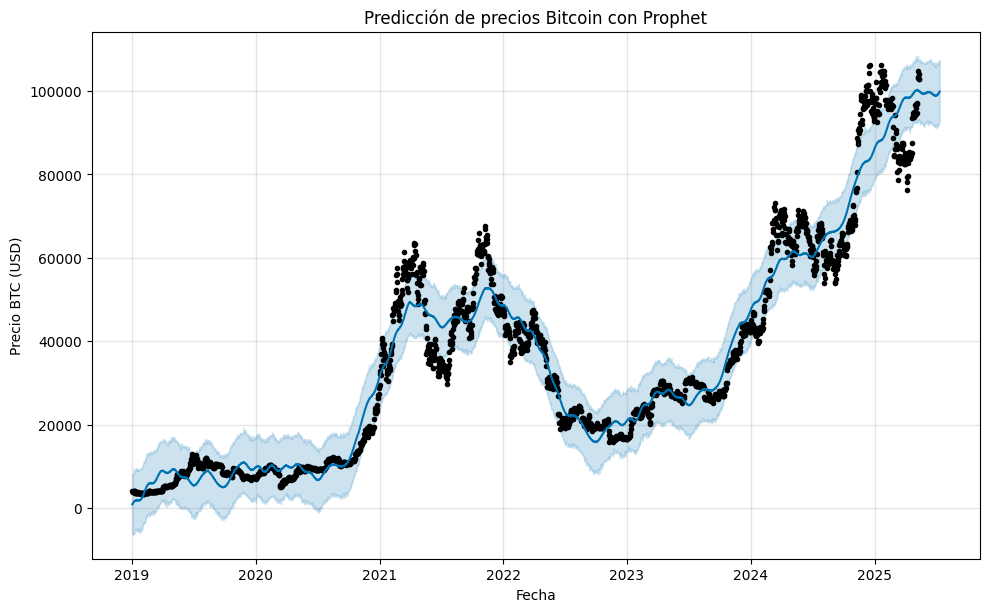

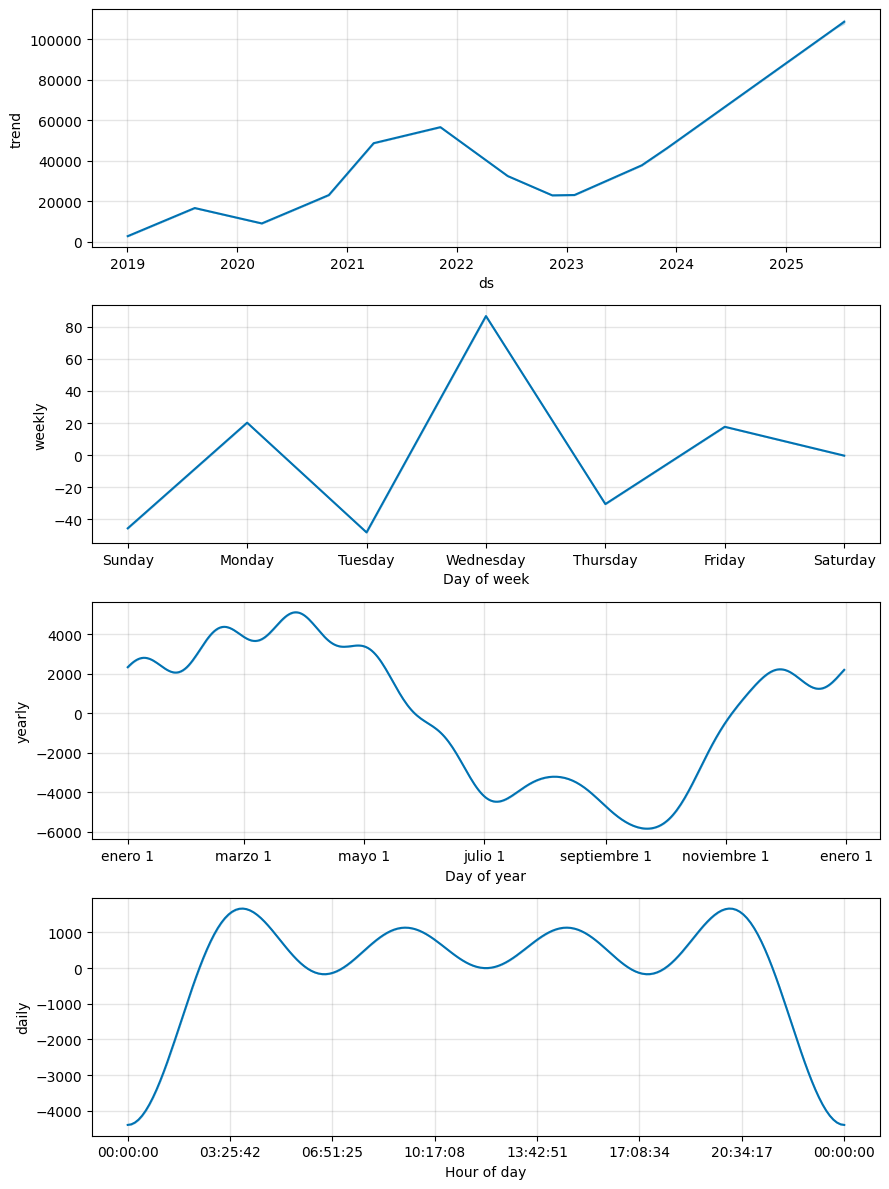

MAE del modelo Prophet: 4286.47


In [245]:




df_prophet = combined_df[['Date', 'BTC']].rename(columns={'Date':'ds', 'BTC':'y'})

# Crear y entrenar modelo
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Hacer predicción a futuro (ej: 60 días)
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

# Graficar resultados
model.plot(forecast)
plt.title("Predicción de precios Bitcoin con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.show()

# Para ver componentes de la predicción (tendencia, estacionalidad)
model.plot_components(forecast)
plt.show()

y_true = df_prophet['y']
y_pred = forecast['yhat'][:len(y_true)]

mae = calculate_mae(y_true, y_pred)
print(f"MAE del modelo Prophet: {mae:.2f}")


### Modelo Prophet con regresor "NASDAQ"
Predicción a 60 días

09:44:01 - cmdstanpy - INFO - Chain [1] start processing
09:44:02 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

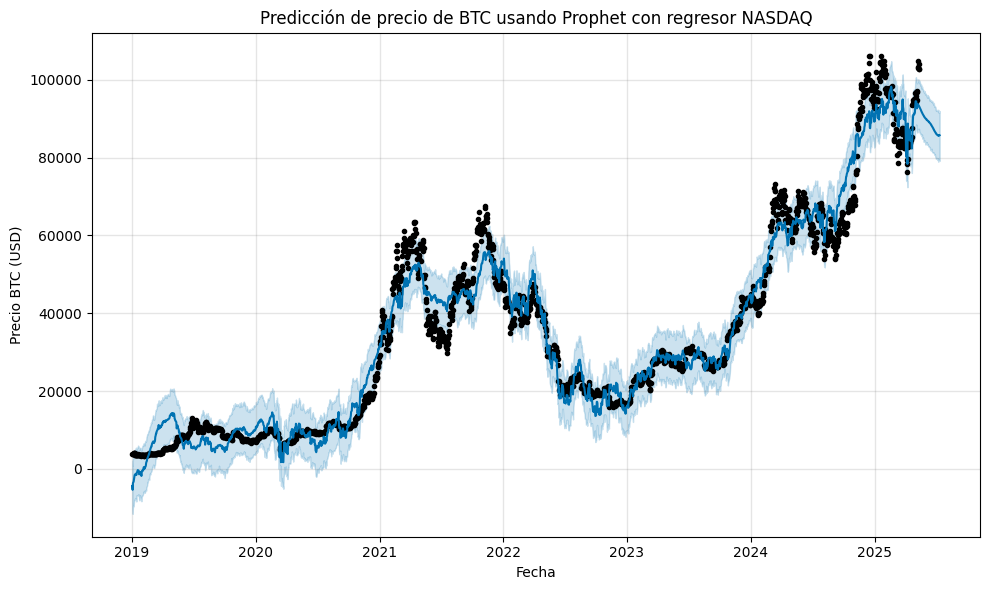

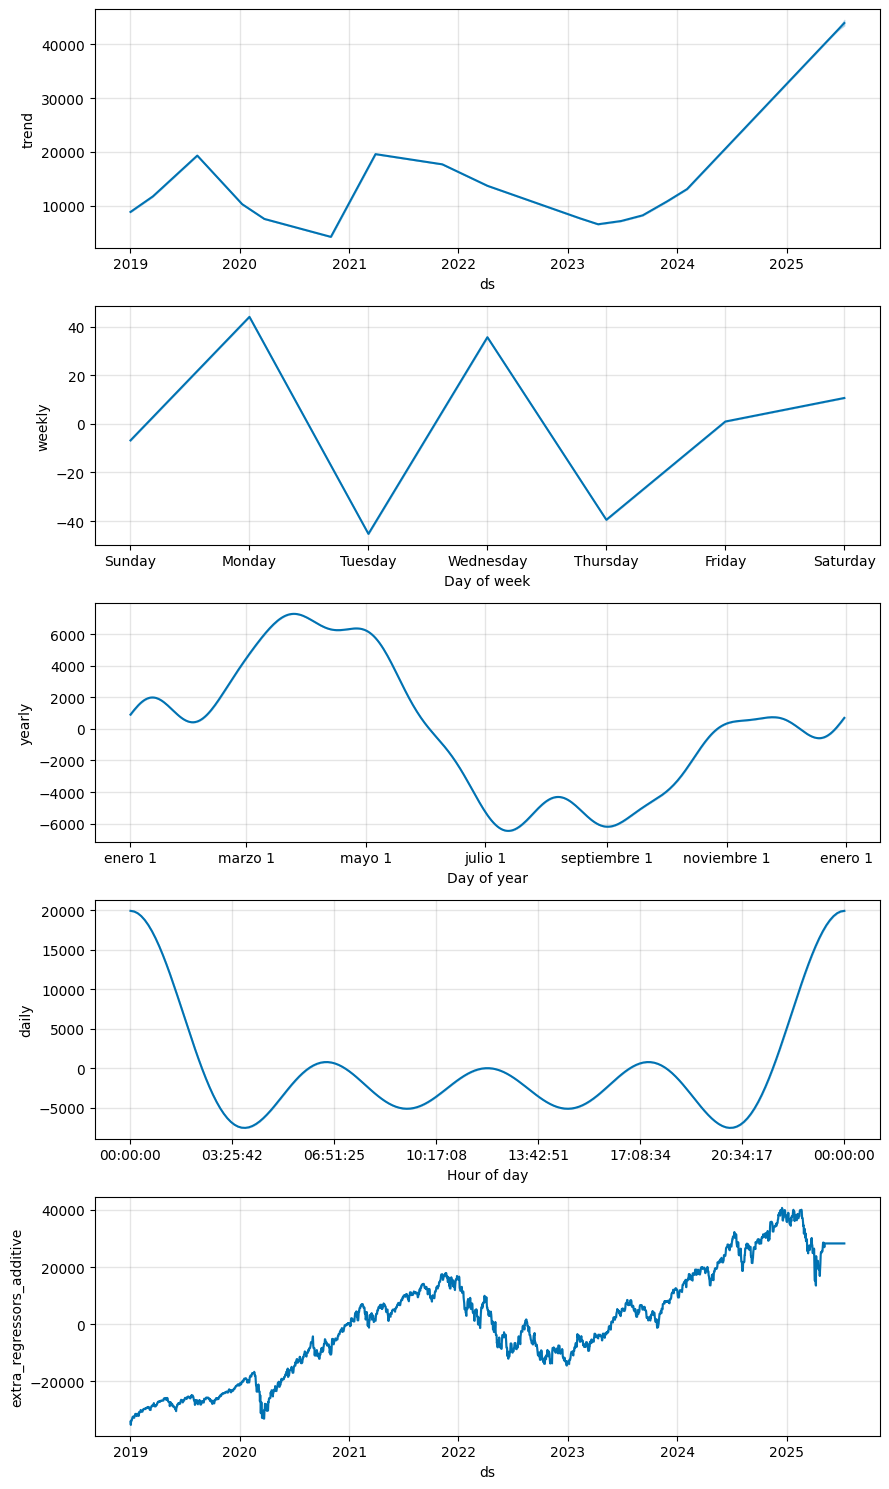

MAE del modelo Prophet: 3807.66


In [322]:


# --- Preparar datos ---
df = combined_df.copy()
df = df[['Date', 'BTC', 'NASDAQ']].dropna()
df.rename(columns={'Date': 'ds', 'BTC': 'y', 'NASDAQ': 'nasdaq'}, inplace=True)

# --- Crear modelo con regresor NASDAQ ---
model = Prophet(daily_seasonality=True)
model.add_regressor('nasdaq')

# --- Entrenar modelo ---
model.fit(df)

# --- Crear futuro con regresor externo ---
#predicción a 60 días

future = model.make_future_dataframe(periods=60)
# Añadir valores futuros de NASDAQ (simplemente repetimos los últimos conocidos si no hay futuros)
last_known_nasdaq = df['nasdaq'].iloc[-1]
future['nasdaq'] = list(df['nasdaq']) + [last_known_nasdaq] * (len(future) - len(df))

# --- Predecir ---
forecast = model.predict(future)

# --- Graficar ---
plt.figure(figsize=(12,6))
model.plot(forecast)
plt.title("Predicción de precio de BTC usando Prophet con regresor NASDAQ")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USD)")
plt.grid(True)
plt.tight_layout()

plt.show()



# --- Componentes ---
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Solo comparar hasta donde hay datos reales
y_true = df['y']
y_pred = forecast['yhat'][:len(y_true)]

mae = calculate_mae(y_true, y_pred)
print(f"MAE del modelo Prophet: {mae:.2f}")



In [324]:
y_true

0         3943.409424
1         3836.741211
2         3857.717529
3         3845.194580
4         4076.632568
            ...      
2319    102970.851562
2320    104696.328125
2321    104106.359375
2322    102812.953125
2323    102796.429688
Name: y, Length: 2324, dtype: float64

In [329]:
forecast["yhat"].tail(61)

2323    93020.813913
2324    92924.017821
2325    92664.243162
2326    92515.395874
2327    92332.714078
            ...     
2379    85615.392090
2380    85679.101238
2381    85604.776096
2382    85664.703247
2383    85712.285526
Name: yhat, Length: 61, dtype: float64

- La predicción de la serie histórica tiene un margen de error considerable

- Supuesto irreal: regresor NASDAQ se mantiene constante tras el último valor conocido

- Según las predicciones, BTC perdería aproximadamente un 8% de su valor en 60 días, lo cual es una variación razonable en la serie histórica.
- No obstante, el modelo claramente no es correcto no son correctas a vista de los acontecimientos recientes: guerra comercial , aranceles ,subsecuente relajación y acuerdos, dando lugar a expectativas alcistas.


# Modelo Prophet con todos los regresores

In [250]:
combined_df_extended.columns

Index(['Date', 'BTC', 'DJIA', 'XAU', 'NASDAQ', 'SP500', 'US10Y', 'WTI',
       'SP500_F', 'DOW_F', 'NASDAQ_F'],
      dtype='object')

In [267]:
combined_df_extended

Date            BTC          DJIA          XAU        NASDAQ  \
0    2019-01-02    3943.409424  23346.240234  1281.000000   6665.939941   
1    2019-01-03    3836.741211  22686.220703  1291.800049   6463.500000   
2    2019-01-04    3857.717529  23433.160156  1282.699951   6738.859863   
3    2019-01-05    3845.194580  23433.160156  1282.699951   6738.859863   
4    2019-01-06    4076.632568  23433.160156  1282.699951   6738.859863   
...         ...            ...           ...          ...           ...   
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y        WTI  SP500_F    DOW_F  NASDAQ_F  
0     2510.030029  2.661  46.540001  2511.00  23325.0   6371.00  
1     2447.889893  2.554  47.090000  2447.75  22659.0   6162.00  
2     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
3     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
4     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
...           ...    ...        ...      ...      ...       ...  
2319  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2320  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2321  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2322  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2323  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  

[2324 rows x 11 columns]

In [268]:
combined_df_extended.isnull().sum()

Date        0
BTC         0
DJIA        0
XAU         0
NASDAQ      0
SP500       0
US10Y       0
WTI         0
SP500_F     0
DOW_F       0
NASDAQ_F    0
dtype: int64

In [ ]:


# Prepara el dataframe para Prophet
#df_prophet = combined_df_extended[['Date', 'BTC', 'DJIA', 'XAU', 'NASDAQ', 'SP500', 'US10Y', 'WTI','SP500_F', 'DOW_F', 'NASDAQ_F']].copy()


df_prophet=combined_df_extended.copy()
df_prophet.rename(columns={'Date': 'ds', 'BTC': 'y'}, inplace=True)

# Inicializa el modelo Prophet
model = Prophet()

# Añade los regresores externos
regressors = ['DJIA', 'XAU', 'NASDAQ', 'SP500', 'US10Y', 'WTI', 'SP500_F', 'DOW_F', 'NASDAQ_F']
for reg in regressors:
    model.add_regressor(reg)

# Entrena el modelo
model.fit(df_prophet)

# Para predecir, primero crea un dataframe con las fechas futuras y los regresores
# Aquí predecimos para el periodo del dataset, puedes extenderlo
future = model.make_future_dataframe(periods=60)
#predice a un día

# Añade los regresores al dataframe future (los valores históricos o futuros que tengas)
for reg in regressors:
    future[reg] = df_prophet[reg]

# Realiza la predicción
forecast = model.predict(future)

# Muestra las predicciones para el precio BTC


#plt.figure(figsize=(12,6))
#plt.plot(df_prophet['ds'], df_prophet['y'], label='Real BTC')
#plt.plot(forecast['ds'], forecast['yhat'], label='Predicción BTC')
#plt.legend()
#plt.title('Predicción Bitcoin con Prophet y regresores')
#plt.xlabel('Fecha')
#plt.ylabel('Precio BTC')
#plt.show()


In [336]:
combined_df_extended["DJIA"].isnull().sum()

0

In [338]:
combined_df_extended

Date            BTC          DJIA          XAU        NASDAQ  \
0    2019-01-02    3943.409424  23346.240234  1281.000000   6665.939941   
1    2019-01-03    3836.741211  22686.220703  1291.800049   6463.500000   
2    2019-01-04    3857.717529  23433.160156  1282.699951   6738.859863   
3    2019-01-05    3845.194580  23433.160156  1282.699951   6738.859863   
4    2019-01-06    4076.632568  23433.160156  1282.699951   6738.859863   
...         ...            ...           ...          ...           ...   
2319 2025-05-09  102970.851562  41249.378906  3335.399902  17928.919922   
2320 2025-05-10  104696.328125  41249.378906  3335.399902  17928.919922   
2321 2025-05-11  104106.359375  41249.378906  3335.399902  17928.919922   
2322 2025-05-12  102812.953125  41249.378906  3335.399902  17928.919922   
2323 2025-05-13  102796.429688  41249.378906  3335.399902  17928.919922   

            SP500  US10Y        WTI  SP500_F    DOW_F  NASDAQ_F  
0     2510.030029  2.661  46.540001  2511.00  23325.0   6371.00  
1     2447.889893  2.554  47.090000  2447.75  22659.0   6162.00  
2     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
3     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
4     2531.939941  2.659  47.959999  2531.25  23395.0   6434.00  
...           ...    ...        ...      ...      ...       ...  
2319  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2320  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2321  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2322  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  
2323  5659.910156  4.375  61.020000  5709.00  41427.0  20195.25  

[2324 rows x 11 columns]